In [1]:
#Import external functions
from image_processing import *
from utils import *
from custom_models import *

from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [2]:
# Load images for training
path_to_images = 'data_generator/UCF-101-flow'
weight_file_path = 'saved_models/pretrained_model.h5'

target_size = (240,320)
batch_size = 32


train_folder = path_to_images + '/train'
train_datagen = ImageDataGenerator(rotation_range=10,
                                   preprocessing_function=preprocess_input_flow,
                                   rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.33)
training_batches2 = train_datagen.flow_from_directory(train_folder,
                                                     target_size=target_size,
                                                     batch_size=batch_size,
                                                     interpolation='bicubic',
                                                     subset='training')
training_batches = crop_generator(training_batches2, crop_width, crop_height, random=True)

validation_batches2 = train_datagen.flow_from_directory(train_folder,
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       interpolation='bicubic',
                                                       subset='validation')
validation_batches = crop_generator(validation_batches2, crop_width, crop_height, random=True)

test_folder = path_to_images + '/test'
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_flow, rescale=1./255)
testing_batches2 = test_datagen.flow_from_directory(test_folder,
                                                   target_size=target_size,
                                                   batch_size=batch_size,
                                                   interpolation='bicubic')
testing_batches = crop_generator(testing_batches2, crop_width, crop_height, random=False)

classes_dictionary = {}
for cls, idx in training_batches2.class_indices.items():
    classes_dictionary[idx] = cls

Found 956573 images belonging to 101 classes.
Found 471071 images belonging to 101 classes.
Found 540949 images belonging to 101 classes.


In [3]:
# Single frame model definition
input_shape = (crop_height,crop_width,3)

#SGD Optimizer Parameters
base_lr = 0.001
momentum = 0.9

#Step-based LearningRate Parameters
epochs = 10000#120 # 450000
gamma = 0.1
stepsize = 4000#40 # 100000

In [4]:
# Load pretrained (ILSVRC2012) model weights
pm_dict = get_h5_weights(weight_file_path)

In [5]:
model = CaffeDonahueFunctional(input_shape, num_labels)

# Load Pretrained weights into model
model = load_pretrained_weights(model, pm_dict)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 227, 227, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 111, 111, 96) 14208       input_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 55, 55, 96)   0           conv1[0][0]                      
__________________________________________________________________________________________________
norm1 (LRN2D)                   (None, 55, 55, 96)   0           pool1[0][0]                      
__________________________________________________________________________________________________
lambda_1 (

In [6]:
def freeze_all_but_top(model):
    # Used to train just the top layers of the model.
    for layer in model.layers[:23]:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def freeze_all_but_mid_and_top(model):
    # After we fine-tune the dense layers, train deeper.
    for layer in model.layers[:1]:
        layer.trainable = False
    for layer in model.layers[1:]:
        layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate 0.001
    model = model_compile(model, base_lr, momentum)

    return model

In [7]:
def train_model(model, nb_epoch, train_generator, validation_generator , callbacks=[]):
    history = model.fit_generator(train_generator,
                                  steps_per_epoch=100,
                                  validation_data=validation_generator,
                                  validation_steps=10,
                                  epochs=nb_epoch,
                                  callbacks=callbacks)

    return history,model

In [8]:
model = freeze_all_but_top(model)
history1, model = train_model(model, 100, training_batches, validation_batches)

Epoch 1/100
100/100 [==============================] - 41s 407ms/step - loss: 5.7788 - acc: 0.0194 - val_loss: 5.2673 - val_acc: 0.0281
Epoch 2/100
100/100 [==============================] - 35s 352ms/step - loss: 5.3579 - acc: 0.0166 - val_loss: 5.3255 - val_acc: 0.0219
Epoch 3/100
100/100 [==============================] - 35s 348ms/step - loss: 5.3828 - acc: 0.0234 - val_loss: 5.3223 - val_acc: 0.0250
Epoch 4/100
100/100 [==============================] - 35s 345ms/step - loss: 5.3801 - acc: 0.0234 - val_loss: 5.3055 - val_acc: 0.0250
Epoch 5/100
100/100 [==============================] - 34s 344ms/step - loss: 5.3966 - acc: 0.0275 - val_loss: 5.3354 - val_acc: 0.0187
Epoch 6/100
100/100 [==============================] - 35s 345ms/step - loss: 5.3901 - acc: 0.0353 - val_loss: 5.3006 - val_acc: 0.0250
Epoch 7/100
100/100 [==============================] - 34s 345ms/step - loss: 5.4200 - acc: 0.0306 - val_loss: 5.3990 - val_acc: 0.0187
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 34s 342ms/step - loss: 5.1031 - acc: 0.0503 - val_loss: 5.0549 - val_acc: 0.0656
Epoch 62/100
100/100 [==============================] - 38s 377ms/step - loss: 5.0800 - acc: 0.0628 - val_loss: 5.0356 - val_acc: 0.0750
Epoch 63/100
100/100 [==============================] - 34s 343ms/step - loss: 5.0507 - acc: 0.0722 - val_loss: 5.0594 - val_acc: 0.0781
Epoch 64/100
100/100 [==============================] - 34s 343ms/step - loss: 5.0924 - acc: 0.0594 - val_loss: 5.1024 - val_acc: 0.0500
Epoch 65/100
100/100 [==============================] - 34s 342ms/step - loss: 5.0574 - acc: 0.0684 - val_loss: 5.0306 - val_acc: 0.0656
Epoch 66/100
100/100 [==============================] - 34s 341ms/step - loss: 5.0839 - acc: 0.0625 - val_loss: 5.1384 - val_acc: 0.0750
Epoch 67/100
100/100 [==============================] - 34s 343ms/step - loss: 5.0717 - acc: 0.0638 - val_loss: 4.9000 - val_acc: 0.1000
Epoch 68/100
100/100 [===================

In [9]:
#### STEP-BASED DECAY
# To Keras ston SGD apo mono tou kanei time-based decay
# Protimoume Step decay, giati emfanizei kalutero convergence
# Isws 8a mporousa na dokimasw kai Adaptive Learning
#
# Possible solution : https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
# Possible solution : https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
####
def step_decay(epoch):
    initial_lrate = base_lr
    drop = gamma
    epochs_drop = stepsize
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

In [10]:
filepath = 'saved_models/caffenet_single_flow.hdf5'
checkpointer = ModelCheckpoint(filepath=filepath,verbose=1,save_best_only=True)
# early_stopper = EarlyStopping(patience=30)
# tensorboard = TensorBoard(log_dir='logs')
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay,verbose=1)


model = freeze_all_but_mid_and_top(model)
history, model = train_model(model, epochs, training_batches, validation_batches,
                             [loss_history,lrate, checkpointer,])

Epoch 1/10000

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 41s 411ms/step - loss: 5.0562 - acc: 0.0672 - top_k_categorical_accuracy: 0.2266 - val_loss: 4.8116 - val_acc: 0.1000 - val_top_k_categorical_accuracy: 0.2969

Epoch 00001: val_loss improved from inf to 4.81161, saving model to saved_models/caffenet_single_flow.hdf5
Epoch 2/10000

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 344ms/step - loss: 4.9440 - acc: 0.0806 - top_k_categorical_accuracy: 0.2550 - val_loss: 4.9475 - val_acc: 0.0781 - val_top_k_categorical_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 4.81161
Epoch 3/10000

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 353ms/step - loss: 4.9433 - acc: 0.0875 - top_k_categorical_accuracy: 0.2525 - val_loss: 4.8874 - val_acc: 0.0844 - val_top_k_categorical_accur


Epoch 00023: val_loss did not improve from 4.50561
Epoch 24/10000

Epoch 00024: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 346ms/step - loss: 4.6875 - acc: 0.1006 - top_k_categorical_accuracy: 0.2941 - val_loss: 4.6367 - val_acc: 0.1000 - val_top_k_categorical_accuracy: 0.3125

Epoch 00024: val_loss did not improve from 4.50561
Epoch 25/10000

Epoch 00025: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 346ms/step - loss: 4.6354 - acc: 0.1050 - top_k_categorical_accuracy: 0.3075 - val_loss: 4.6704 - val_acc: 0.1031 - val_top_k_categorical_accuracy: 0.2875

Epoch 00025: val_loss did not improve from 4.50561
Epoch 26/10000

Epoch 00026: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 345ms/step - loss: 4.6508 - acc: 0.1091 - top_k_categorical_accuracy: 0.2975 - val_loss: 4.5926 - val_acc: 0.1094 - val_top_k_categorical_accura


Epoch 00070: val_loss did not improve from 4.19135
Epoch 71/10000

Epoch 00071: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 346ms/step - loss: 4.3676 - acc: 0.1294 - top_k_categorical_accuracy: 0.3603 - val_loss: 4.3345 - val_acc: 0.1219 - val_top_k_categorical_accuracy: 0.3500

Epoch 00071: val_loss did not improve from 4.19135
Epoch 72/10000

Epoch 00072: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 345ms/step - loss: 4.3819 - acc: 0.1278 - top_k_categorical_accuracy: 0.3541 - val_loss: 4.1957 - val_acc: 0.1719 - val_top_k_categorical_accuracy: 0.3750

Epoch 00072: val_loss did not improve from 4.19135
Epoch 73/10000

Epoch 00073: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 346ms/step - loss: 4.3534 - acc: 0.1253 - top_k_categorical_accuracy: 0.3716 - val_loss: 4.2801 - val_acc: 0.1531 - val_top_k_categorical_accura

100/100 [==============================] - 35s 347ms/step - loss: 4.1515 - acc: 0.1509 - top_k_categorical_accuracy: 0.4022 - val_loss: 4.0514 - val_acc: 0.1938 - val_top_k_categorical_accuracy: 0.4094

Epoch 00118: val_loss did not improve from 4.03087
Epoch 119/10000

Epoch 00119: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 347ms/step - loss: 4.1522 - acc: 0.1484 - top_k_categorical_accuracy: 0.4116 - val_loss: 4.0418 - val_acc: 0.1562 - val_top_k_categorical_accuracy: 0.4406

Epoch 00119: val_loss did not improve from 4.03087
Epoch 120/10000

Epoch 00120: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 349ms/step - loss: 4.1607 - acc: 0.1475 - top_k_categorical_accuracy: 0.4019 - val_loss: 4.0712 - val_acc: 0.1656 - val_top_k_categorical_accuracy: 0.4219

Epoch 00120: val_loss did not improve from 4.03087
Epoch 121/10000

Epoch 00121: LearningRateScheduler setting learning r

100/100 [==============================] - 35s 345ms/step - loss: 3.9941 - acc: 0.1759 - top_k_categorical_accuracy: 0.4403 - val_loss: 3.8638 - val_acc: 0.1969 - val_top_k_categorical_accuracy: 0.4625

Epoch 00142: val_loss improved from 3.86552 to 3.86376, saving model to saved_models/caffenet_single_flow.hdf5
Epoch 143/10000

Epoch 00143: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 354ms/step - loss: 4.0114 - acc: 0.1722 - top_k_categorical_accuracy: 0.4400 - val_loss: 3.9364 - val_acc: 0.1969 - val_top_k_categorical_accuracy: 0.4656

Epoch 00143: val_loss did not improve from 3.86376
Epoch 144/10000

Epoch 00144: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 351ms/step - loss: 4.0185 - acc: 0.1684 - top_k_categorical_accuracy: 0.4409 - val_loss: 3.9420 - val_acc: 0.1938 - val_top_k_categorical_accuracy: 0.4719

Epoch 00144: val_loss did not improve from 3.86376
Epoch 145/

100/100 [==============================] - 35s 346ms/step - loss: 3.9252 - acc: 0.1766 - top_k_categorical_accuracy: 0.4588 - val_loss: 3.9706 - val_acc: 0.1594 - val_top_k_categorical_accuracy: 0.4719

Epoch 00166: val_loss did not improve from 3.80676
Epoch 167/10000

Epoch 00167: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 346ms/step - loss: 3.8973 - acc: 0.1956 - top_k_categorical_accuracy: 0.4706 - val_loss: 3.8496 - val_acc: 0.1969 - val_top_k_categorical_accuracy: 0.4719

Epoch 00167: val_loss did not improve from 3.80676
Epoch 168/10000

Epoch 00168: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 346ms/step - loss: 3.8793 - acc: 0.1938 - top_k_categorical_accuracy: 0.4784 - val_loss: 4.0149 - val_acc: 0.1844 - val_top_k_categorical_accuracy: 0.4531

Epoch 00168: val_loss did not improve from 3.80676
Epoch 169/10000

Epoch 00169: LearningRateScheduler setting learning r

Epoch 190/10000

Epoch 00190: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 36s 364ms/step - loss: 3.7806 - acc: 0.2069 - top_k_categorical_accuracy: 0.4975 - val_loss: 4.0377 - val_acc: 0.1656 - val_top_k_categorical_accuracy: 0.4188

Epoch 00190: val_loss did not improve from 3.66488
Epoch 191/10000

Epoch 00191: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 346ms/step - loss: 3.8078 - acc: 0.1997 - top_k_categorical_accuracy: 0.4956 - val_loss: 3.9227 - val_acc: 0.1656 - val_top_k_categorical_accuracy: 0.4719

Epoch 00191: val_loss did not improve from 3.66488
Epoch 192/10000

Epoch 00192: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 346ms/step - loss: 3.7238 - acc: 0.2147 - top_k_categorical_accuracy: 0.5122 - val_loss: 3.7269 - val_acc: 0.2313 - val_top_k_categorical_accuracy: 0.5281

Epoch 00192: val_loss did not improve

100/100 [==============================] - 34s 342ms/step - loss: 3.6628 - acc: 0.2178 - top_k_categorical_accuracy: 0.5187 - val_loss: 3.7283 - val_acc: 0.2031 - val_top_k_categorical_accuracy: 0.5156

Epoch 00214: val_loss did not improve from 3.64687
Epoch 215/10000

Epoch 00215: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 343ms/step - loss: 3.6115 - acc: 0.2250 - top_k_categorical_accuracy: 0.5372 - val_loss: 3.6362 - val_acc: 0.2219 - val_top_k_categorical_accuracy: 0.5406

Epoch 00215: val_loss improved from 3.64687 to 3.63622, saving model to saved_models/caffenet_single_flow.hdf5
Epoch 216/10000

Epoch 00216: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 349ms/step - loss: 3.6981 - acc: 0.2206 - top_k_categorical_accuracy: 0.5153 - val_loss: 3.6618 - val_acc: 0.1938 - val_top_k_categorical_accuracy: 0.5281

Epoch 00216: val_loss did not improve from 3.63622
Epoch 217/

100/100 [==============================] - 34s 343ms/step - loss: 3.5595 - acc: 0.2487 - top_k_categorical_accuracy: 0.5472 - val_loss: 3.7023 - val_acc: 0.2156 - val_top_k_categorical_accuracy: 0.5062

Epoch 00238: val_loss did not improve from 3.55280
Epoch 239/10000

Epoch 00239: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 342ms/step - loss: 3.5799 - acc: 0.2441 - top_k_categorical_accuracy: 0.5487 - val_loss: 3.6331 - val_acc: 0.2375 - val_top_k_categorical_accuracy: 0.5312

Epoch 00239: val_loss did not improve from 3.55280
Epoch 240/10000

Epoch 00240: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 343ms/step - loss: 3.5527 - acc: 0.2500 - top_k_categorical_accuracy: 0.5531 - val_loss: 3.5752 - val_acc: 0.2313 - val_top_k_categorical_accuracy: 0.5656

Epoch 00240: val_loss did not improve from 3.55280
Epoch 241/10000

Epoch 00241: LearningRateScheduler setting learning r

100/100 [==============================] - 34s 343ms/step - loss: 3.3591 - acc: 0.2716 - top_k_categorical_accuracy: 0.5944 - val_loss: 3.5498 - val_acc: 0.2375 - val_top_k_categorical_accuracy: 0.5687

Epoch 00286: val_loss did not improve from 3.35995
Epoch 287/10000

Epoch 00287: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 342ms/step - loss: 3.3642 - acc: 0.2728 - top_k_categorical_accuracy: 0.5941 - val_loss: 3.3379 - val_acc: 0.3000 - val_top_k_categorical_accuracy: 0.6375

Epoch 00287: val_loss improved from 3.35995 to 3.33789, saving model to saved_models/caffenet_single_flow.hdf5
Epoch 288/10000

Epoch 00288: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 351ms/step - loss: 3.3971 - acc: 0.2719 - top_k_categorical_accuracy: 0.5797 - val_loss: 3.2923 - val_acc: 0.3219 - val_top_k_categorical_accuracy: 0.6188

Epoch 00288: val_loss improved from 3.33789 to 3.29234, savin

100/100 [==============================] - 34s 341ms/step - loss: 3.2615 - acc: 0.3044 - top_k_categorical_accuracy: 0.6197 - val_loss: 3.5298 - val_acc: 0.2250 - val_top_k_categorical_accuracy: 0.5469

Epoch 00310: val_loss did not improve from 3.29234
Epoch 311/10000

Epoch 00311: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 341ms/step - loss: 3.2543 - acc: 0.3050 - top_k_categorical_accuracy: 0.6234 - val_loss: 3.3319 - val_acc: 0.2625 - val_top_k_categorical_accuracy: 0.6094

Epoch 00311: val_loss did not improve from 3.29234
Epoch 312/10000

Epoch 00312: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 342ms/step - loss: 3.3024 - acc: 0.3028 - top_k_categorical_accuracy: 0.6141 - val_loss: 3.4194 - val_acc: 0.2938 - val_top_k_categorical_accuracy: 0.6188

Epoch 00312: val_loss did not improve from 3.29234
Epoch 313/10000

Epoch 00313: LearningRateScheduler setting learning r

100/100 [==============================] - 34s 342ms/step - loss: 3.1164 - acc: 0.3253 - top_k_categorical_accuracy: 0.6578 - val_loss: 3.4064 - val_acc: 0.2812 - val_top_k_categorical_accuracy: 0.6406

Epoch 00358: val_loss did not improve from 3.18645
Epoch 359/10000

Epoch 00359: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 341ms/step - loss: 3.0981 - acc: 0.3294 - top_k_categorical_accuracy: 0.6613 - val_loss: 3.3821 - val_acc: 0.2719 - val_top_k_categorical_accuracy: 0.6094

Epoch 00359: val_loss did not improve from 3.18645
Epoch 360/10000

Epoch 00360: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 342ms/step - loss: 3.0895 - acc: 0.3403 - top_k_categorical_accuracy: 0.6538 - val_loss: 3.3893 - val_acc: 0.2719 - val_top_k_categorical_accuracy: 0.5750

Epoch 00360: val_loss did not improve from 3.18645
Epoch 361/10000

Epoch 00361: LearningRateScheduler setting learning r

100/100 [==============================] - 34s 344ms/step - loss: 2.9570 - acc: 0.3656 - top_k_categorical_accuracy: 0.6813 - val_loss: 3.1093 - val_acc: 0.3219 - val_top_k_categorical_accuracy: 0.6531

Epoch 00406: val_loss improved from 3.12295 to 3.10926, saving model to saved_models/caffenet_single_flow.hdf5
Epoch 407/10000

Epoch 00407: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 36s 358ms/step - loss: 3.0093 - acc: 0.3597 - top_k_categorical_accuracy: 0.6709 - val_loss: 3.4538 - val_acc: 0.2594 - val_top_k_categorical_accuracy: 0.5813

Epoch 00407: val_loss did not improve from 3.10926
Epoch 408/10000

Epoch 00408: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 342ms/step - loss: 2.9694 - acc: 0.3719 - top_k_categorical_accuracy: 0.6744 - val_loss: 3.2529 - val_acc: 0.3063 - val_top_k_categorical_accuracy: 0.6344

Epoch 00408: val_loss did not improve from 3.10926
Epoch 409/

100/100 [==============================] - 34s 343ms/step - loss: 2.9689 - acc: 0.3722 - top_k_categorical_accuracy: 0.6847 - val_loss: 3.3192 - val_acc: 0.3250 - val_top_k_categorical_accuracy: 0.6156

Epoch 00430: val_loss did not improve from 3.05558
Epoch 431/10000

Epoch 00431: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 343ms/step - loss: 2.9382 - acc: 0.3700 - top_k_categorical_accuracy: 0.6947 - val_loss: 3.0749 - val_acc: 0.3406 - val_top_k_categorical_accuracy: 0.6750

Epoch 00431: val_loss did not improve from 3.05558
Epoch 432/10000

Epoch 00432: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 343ms/step - loss: 2.9135 - acc: 0.3822 - top_k_categorical_accuracy: 0.7016 - val_loss: 3.3080 - val_acc: 0.2906 - val_top_k_categorical_accuracy: 0.5875

Epoch 00432: val_loss did not improve from 3.05558
Epoch 433/10000

Epoch 00433: LearningRateScheduler setting learning r

100/100 [==============================] - 35s 347ms/step - loss: 2.7939 - acc: 0.4094 - top_k_categorical_accuracy: 0.7109 - val_loss: 3.3019 - val_acc: 0.3312 - val_top_k_categorical_accuracy: 0.6406

Epoch 00478: val_loss did not improve from 3.01588
Epoch 479/10000

Epoch 00479: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 345ms/step - loss: 2.7979 - acc: 0.4153 - top_k_categorical_accuracy: 0.7181 - val_loss: 3.0998 - val_acc: 0.3750 - val_top_k_categorical_accuracy: 0.6469

Epoch 00479: val_loss did not improve from 3.01588
Epoch 480/10000

Epoch 00480: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 347ms/step - loss: 2.8453 - acc: 0.4006 - top_k_categorical_accuracy: 0.7103 - val_loss: 2.9941 - val_acc: 0.3656 - val_top_k_categorical_accuracy: 0.6687

Epoch 00480: val_loss improved from 3.01588 to 2.99406, saving model to saved_models/caffenet_single_flow.hdf5
Epoch 481/


Epoch 00501: val_loss did not improve from 2.94054
Epoch 502/10000

Epoch 00502: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.7791 - acc: 0.4109 - top_k_categorical_accuracy: 0.7244 - val_loss: 3.2419 - val_acc: 0.3250 - val_top_k_categorical_accuracy: 0.6219

Epoch 00502: val_loss did not improve from 2.94054
Epoch 503/10000

Epoch 00503: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.7675 - acc: 0.4184 - top_k_categorical_accuracy: 0.7172 - val_loss: 3.1428 - val_acc: 0.3250 - val_top_k_categorical_accuracy: 0.6438

Epoch 00503: val_loss did not improve from 2.94054
Epoch 504/10000

Epoch 00504: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.7620 - acc: 0.4203 - top_k_categorical_accuracy: 0.7156 - val_loss: 3.2206 - val_acc: 0.3063 - val_top_k_categorical_acc

100/100 [==============================] - 33s 334ms/step - loss: 2.7555 - acc: 0.4150 - top_k_categorical_accuracy: 0.7272 - val_loss: 3.0868 - val_acc: 0.3438 - val_top_k_categorical_accuracy: 0.6813

Epoch 00526: val_loss did not improve from 2.83226
Epoch 527/10000

Epoch 00527: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.7367 - acc: 0.4213 - top_k_categorical_accuracy: 0.7353 - val_loss: 3.0280 - val_acc: 0.3750 - val_top_k_categorical_accuracy: 0.6594

Epoch 00527: val_loss did not improve from 2.83226
Epoch 528/10000

Epoch 00528: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.6867 - acc: 0.4394 - top_k_categorical_accuracy: 0.7434 - val_loss: 3.0530 - val_acc: 0.3625 - val_top_k_categorical_accuracy: 0.6687

Epoch 00528: val_loss did not improve from 2.83226
Epoch 529/10000

Epoch 00529: LearningRateScheduler setting learning r

100/100 [==============================] - 33s 334ms/step - loss: 2.6803 - acc: 0.4391 - top_k_categorical_accuracy: 0.7434 - val_loss: 3.0134 - val_acc: 0.3750 - val_top_k_categorical_accuracy: 0.6781

Epoch 00574: val_loss did not improve from 2.74615
Epoch 575/10000

Epoch 00575: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.6800 - acc: 0.4409 - top_k_categorical_accuracy: 0.7488 - val_loss: 3.0683 - val_acc: 0.3875 - val_top_k_categorical_accuracy: 0.6687

Epoch 00575: val_loss did not improve from 2.74615
Epoch 576/10000

Epoch 00576: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.6341 - acc: 0.4375 - top_k_categorical_accuracy: 0.7450 - val_loss: 3.1984 - val_acc: 0.3281 - val_top_k_categorical_accuracy: 0.6531

Epoch 00576: val_loss did not improve from 2.74615
Epoch 577/10000

Epoch 00577: LearningRateScheduler setting learning r

100/100 [==============================] - 34s 336ms/step - loss: 2.6053 - acc: 0.4537 - top_k_categorical_accuracy: 0.7528 - val_loss: 3.0542 - val_acc: 0.3563 - val_top_k_categorical_accuracy: 0.6719

Epoch 00622: val_loss did not improve from 2.74615
Epoch 623/10000

Epoch 00623: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.5756 - acc: 0.4522 - top_k_categorical_accuracy: 0.7650 - val_loss: 3.1371 - val_acc: 0.3656 - val_top_k_categorical_accuracy: 0.6687

Epoch 00623: val_loss did not improve from 2.74615
Epoch 624/10000

Epoch 00624: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.5771 - acc: 0.4597 - top_k_categorical_accuracy: 0.7541 - val_loss: 3.0581 - val_acc: 0.3719 - val_top_k_categorical_accuracy: 0.6594

Epoch 00624: val_loss did not improve from 2.74615
Epoch 625/10000

Epoch 00625: LearningRateScheduler setting learning r

100/100 [==============================] - 34s 336ms/step - loss: 2.5300 - acc: 0.4778 - top_k_categorical_accuracy: 0.7750 - val_loss: 3.2711 - val_acc: 0.3281 - val_top_k_categorical_accuracy: 0.6281

Epoch 00670: val_loss did not improve from 2.74615
Epoch 671/10000

Epoch 00671: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.5203 - acc: 0.4766 - top_k_categorical_accuracy: 0.7731 - val_loss: 3.0901 - val_acc: 0.3281 - val_top_k_categorical_accuracy: 0.6813

Epoch 00671: val_loss did not improve from 2.74615
Epoch 672/10000

Epoch 00672: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.5309 - acc: 0.4772 - top_k_categorical_accuracy: 0.7762 - val_loss: 3.1537 - val_acc: 0.3063 - val_top_k_categorical_accuracy: 0.6469

Epoch 00672: val_loss did not improve from 2.74615
Epoch 673/10000

Epoch 00673: LearningRateScheduler setting learning r

100/100 [==============================] - 34s 335ms/step - loss: 2.5286 - acc: 0.4800 - top_k_categorical_accuracy: 0.7750 - val_loss: 2.8821 - val_acc: 0.3969 - val_top_k_categorical_accuracy: 0.6875

Epoch 00718: val_loss did not improve from 2.74615
Epoch 719/10000

Epoch 00719: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 2.4808 - acc: 0.4859 - top_k_categorical_accuracy: 0.7781 - val_loss: 3.1567 - val_acc: 0.3375 - val_top_k_categorical_accuracy: 0.6469

Epoch 00719: val_loss did not improve from 2.74615
Epoch 720/10000

Epoch 00720: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.4746 - acc: 0.4850 - top_k_categorical_accuracy: 0.7794 - val_loss: 2.9267 - val_acc: 0.4000 - val_top_k_categorical_accuracy: 0.7188

Epoch 00720: val_loss did not improve from 2.74615
Epoch 721/10000

Epoch 00721: LearningRateScheduler setting learning r

100/100 [==============================] - 33s 335ms/step - loss: 2.4097 - acc: 0.5094 - top_k_categorical_accuracy: 0.7894 - val_loss: 2.8538 - val_acc: 0.3969 - val_top_k_categorical_accuracy: 0.7031

Epoch 00766: val_loss did not improve from 2.74615
Epoch 767/10000

Epoch 00767: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.4567 - acc: 0.4931 - top_k_categorical_accuracy: 0.7831 - val_loss: 3.0550 - val_acc: 0.3344 - val_top_k_categorical_accuracy: 0.6969

Epoch 00767: val_loss did not improve from 2.74615
Epoch 768/10000

Epoch 00768: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.4442 - acc: 0.4972 - top_k_categorical_accuracy: 0.7863 - val_loss: 3.0123 - val_acc: 0.3969 - val_top_k_categorical_accuracy: 0.6844

Epoch 00768: val_loss did not improve from 2.74615
Epoch 769/10000

Epoch 00769: LearningRateScheduler setting learning r

100/100 [==============================] - 34s 340ms/step - loss: 2.4422 - acc: 0.5034 - top_k_categorical_accuracy: 0.7837 - val_loss: 3.0257 - val_acc: 0.3969 - val_top_k_categorical_accuracy: 0.6750

Epoch 00814: val_loss did not improve from 2.74615
Epoch 815/10000

Epoch 00815: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.3895 - acc: 0.5109 - top_k_categorical_accuracy: 0.8031 - val_loss: 3.0132 - val_acc: 0.3531 - val_top_k_categorical_accuracy: 0.6687

Epoch 00815: val_loss did not improve from 2.74615
Epoch 816/10000

Epoch 00816: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.4062 - acc: 0.5091 - top_k_categorical_accuracy: 0.7847 - val_loss: 3.0675 - val_acc: 0.3625 - val_top_k_categorical_accuracy: 0.6844

Epoch 00816: val_loss did not improve from 2.74615
Epoch 817/10000

Epoch 00817: LearningRateScheduler setting learning r

100/100 [==============================] - 33s 334ms/step - loss: 2.3935 - acc: 0.5081 - top_k_categorical_accuracy: 0.7925 - val_loss: 3.0111 - val_acc: 0.3625 - val_top_k_categorical_accuracy: 0.6344

Epoch 00862: val_loss did not improve from 2.51997
Epoch 863/10000

Epoch 00863: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.3513 - acc: 0.5197 - top_k_categorical_accuracy: 0.8056 - val_loss: 2.9281 - val_acc: 0.4313 - val_top_k_categorical_accuracy: 0.7125

Epoch 00863: val_loss did not improve from 2.51997
Epoch 864/10000

Epoch 00864: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.3667 - acc: 0.5259 - top_k_categorical_accuracy: 0.8012 - val_loss: 2.8649 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.7188

Epoch 00864: val_loss did not improve from 2.51997
Epoch 865/10000

Epoch 00865: LearningRateScheduler setting learning r

100/100 [==============================] - 33s 334ms/step - loss: 2.3424 - acc: 0.5272 - top_k_categorical_accuracy: 0.8059 - val_loss: 2.8739 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.6969

Epoch 00910: val_loss did not improve from 2.51997
Epoch 911/10000

Epoch 00911: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.3501 - acc: 0.5216 - top_k_categorical_accuracy: 0.8097 - val_loss: 2.9368 - val_acc: 0.3750 - val_top_k_categorical_accuracy: 0.7156

Epoch 00911: val_loss did not improve from 2.51997
Epoch 912/10000

Epoch 00912: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.3419 - acc: 0.5244 - top_k_categorical_accuracy: 0.8084 - val_loss: 3.0814 - val_acc: 0.3656 - val_top_k_categorical_accuracy: 0.6844

Epoch 00912: val_loss did not improve from 2.51997
Epoch 913/10000

Epoch 00913: LearningRateScheduler setting learning r

100/100 [==============================] - 33s 335ms/step - loss: 2.2716 - acc: 0.5369 - top_k_categorical_accuracy: 0.8297 - val_loss: 2.9874 - val_acc: 0.4000 - val_top_k_categorical_accuracy: 0.7125

Epoch 00958: val_loss did not improve from 2.51997
Epoch 959/10000

Epoch 00959: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.3259 - acc: 0.5284 - top_k_categorical_accuracy: 0.8109 - val_loss: 2.8309 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.7156

Epoch 00959: val_loss did not improve from 2.51997
Epoch 960/10000

Epoch 00960: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.3003 - acc: 0.5391 - top_k_categorical_accuracy: 0.8169 - val_loss: 3.1547 - val_acc: 0.3750 - val_top_k_categorical_accuracy: 0.6312

Epoch 00960: val_loss did not improve from 2.51997
Epoch 961/10000

Epoch 00961: LearningRateScheduler setting learning r

100/100 [==============================] - 34s 335ms/step - loss: 2.2400 - acc: 0.5559 - top_k_categorical_accuracy: 0.8319 - val_loss: 3.1042 - val_acc: 0.3844 - val_top_k_categorical_accuracy: 0.6875

Epoch 01006: val_loss did not improve from 2.51997
Epoch 1007/10000

Epoch 01007: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.3332 - acc: 0.5316 - top_k_categorical_accuracy: 0.8137 - val_loss: 2.6647 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.7406

Epoch 01007: val_loss did not improve from 2.51997
Epoch 1008/10000

Epoch 01008: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.2563 - acc: 0.5513 - top_k_categorical_accuracy: 0.8228 - val_loss: 3.0125 - val_acc: 0.3906 - val_top_k_categorical_accuracy: 0.6813

Epoch 01008: val_loss did not improve from 2.51997
Epoch 1009/10000

Epoch 01009: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 2.2677 - acc: 0.5569 - top_k_categorical_accuracy: 0.8144 - val_loss: 2.9036 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.7219

Epoch 01054: val_loss did not improve from 2.51997
Epoch 1055/10000

Epoch 01055: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.2703 - acc: 0.5525 - top_k_categorical_accuracy: 0.8269 - val_loss: 3.0995 - val_acc: 0.3781 - val_top_k_categorical_accuracy: 0.6656

Epoch 01055: val_loss did not improve from 2.51997
Epoch 1056/10000

Epoch 01056: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.2611 - acc: 0.5484 - top_k_categorical_accuracy: 0.8225 - val_loss: 2.9160 - val_acc: 0.4219 - val_top_k_categorical_accuracy: 0.7000

Epoch 01056: val_loss did not improve from 2.51997
Epoch 1057/10000

Epoch 01057: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 337ms/step - loss: 2.2333 - acc: 0.5597 - top_k_categorical_accuracy: 0.8334 - val_loss: 2.8113 - val_acc: 0.4219 - val_top_k_categorical_accuracy: 0.7344

Epoch 01102: val_loss did not improve from 2.51997
Epoch 1103/10000

Epoch 01103: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.2044 - acc: 0.5700 - top_k_categorical_accuracy: 0.8366 - val_loss: 2.8325 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7312

Epoch 01103: val_loss did not improve from 2.51997
Epoch 1104/10000

Epoch 01104: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.2261 - acc: 0.5659 - top_k_categorical_accuracy: 0.8194 - val_loss: 2.8723 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7094

Epoch 01104: val_loss did not improve from 2.51997
Epoch 1105/10000

Epoch 01105: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 2.3041 - acc: 0.5522 - top_k_categorical_accuracy: 0.8097 - val_loss: 2.8603 - val_acc: 0.4281 - val_top_k_categorical_accuracy: 0.7219

Epoch 01150: val_loss did not improve from 2.51997
Epoch 1151/10000

Epoch 01151: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.2278 - acc: 0.5703 - top_k_categorical_accuracy: 0.8325 - val_loss: 3.2759 - val_acc: 0.3469 - val_top_k_categorical_accuracy: 0.6656

Epoch 01151: val_loss did not improve from 2.51997
Epoch 1152/10000

Epoch 01152: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.2097 - acc: 0.5763 - top_k_categorical_accuracy: 0.8334 - val_loss: 3.0103 - val_acc: 0.4062 - val_top_k_categorical_accuracy: 0.6844

Epoch 01152: val_loss did not improve from 2.51997
Epoch 1153/10000

Epoch 01153: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 2.2078 - acc: 0.5766 - top_k_categorical_accuracy: 0.8391 - val_loss: 2.6932 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7625

Epoch 01198: val_loss did not improve from 2.51997
Epoch 1199/10000

Epoch 01199: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.1672 - acc: 0.5797 - top_k_categorical_accuracy: 0.8472 - val_loss: 2.9266 - val_acc: 0.4000 - val_top_k_categorical_accuracy: 0.7406

Epoch 01199: val_loss did not improve from 2.51997
Epoch 1200/10000

Epoch 01200: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 338ms/step - loss: 2.2026 - acc: 0.5831 - top_k_categorical_accuracy: 0.8353 - val_loss: 2.7754 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7500

Epoch 01200: val_loss did not improve from 2.51997
Epoch 1201/10000

Epoch 01201: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 335ms/step - loss: 2.1584 - acc: 0.5759 - top_k_categorical_accuracy: 0.8484 - val_loss: 2.9412 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7188

Epoch 01246: val_loss did not improve from 2.51997
Epoch 1247/10000

Epoch 01247: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.1686 - acc: 0.5747 - top_k_categorical_accuracy: 0.8447 - val_loss: 3.0258 - val_acc: 0.3969 - val_top_k_categorical_accuracy: 0.7125

Epoch 01247: val_loss did not improve from 2.51997
Epoch 1248/10000

Epoch 01248: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.1906 - acc: 0.5741 - top_k_categorical_accuracy: 0.8366 - val_loss: 2.8739 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7344

Epoch 01248: val_loss did not improve from 2.51997
Epoch 1249/10000

Epoch 01249: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 2.2393 - acc: 0.5653 - top_k_categorical_accuracy: 0.8300 - val_loss: 2.8906 - val_acc: 0.4062 - val_top_k_categorical_accuracy: 0.7219

Epoch 01294: val_loss did not improve from 2.51997
Epoch 1295/10000

Epoch 01295: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.1830 - acc: 0.5812 - top_k_categorical_accuracy: 0.8475 - val_loss: 3.0478 - val_acc: 0.3688 - val_top_k_categorical_accuracy: 0.7000

Epoch 01295: val_loss did not improve from 2.51997
Epoch 1296/10000

Epoch 01296: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.1508 - acc: 0.5906 - top_k_categorical_accuracy: 0.8403 - val_loss: 2.9524 - val_acc: 0.4188 - val_top_k_categorical_accuracy: 0.6906

Epoch 01296: val_loss did not improve from 2.51997
Epoch 1297/10000

Epoch 01297: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 2.1070 - acc: 0.6056 - top_k_categorical_accuracy: 0.8522 - val_loss: 2.8370 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.6906

Epoch 01342: val_loss did not improve from 2.51997
Epoch 1343/10000

Epoch 01343: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.1280 - acc: 0.6022 - top_k_categorical_accuracy: 0.8497 - val_loss: 2.9011 - val_acc: 0.4375 - val_top_k_categorical_accuracy: 0.7250

Epoch 01343: val_loss did not improve from 2.51997
Epoch 1344/10000

Epoch 01344: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.1774 - acc: 0.5850 - top_k_categorical_accuracy: 0.8400 - val_loss: 2.6963 - val_acc: 0.4375 - val_top_k_categorical_accuracy: 0.7594

Epoch 01344: val_loss did not improve from 2.51997
Epoch 1345/10000

Epoch 01345: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 335ms/step - loss: 2.1670 - acc: 0.5847 - top_k_categorical_accuracy: 0.8441 - val_loss: 2.9816 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.6937

Epoch 01390: val_loss did not improve from 2.51997
Epoch 1391/10000

Epoch 01391: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.1455 - acc: 0.5841 - top_k_categorical_accuracy: 0.8488 - val_loss: 2.7809 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7531

Epoch 01391: val_loss did not improve from 2.51997
Epoch 1392/10000

Epoch 01392: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.1376 - acc: 0.5972 - top_k_categorical_accuracy: 0.8588 - val_loss: 2.7826 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.7469

Epoch 01392: val_loss did not improve from 2.51997
Epoch 1393/10000

Epoch 01393: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 2.1627 - acc: 0.5962 - top_k_categorical_accuracy: 0.8462 - val_loss: 2.7226 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7656

Epoch 01438: val_loss did not improve from 2.51997
Epoch 1439/10000

Epoch 01439: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 333ms/step - loss: 2.1622 - acc: 0.5991 - top_k_categorical_accuracy: 0.8503 - val_loss: 2.9325 - val_acc: 0.4313 - val_top_k_categorical_accuracy: 0.7125

Epoch 01439: val_loss did not improve from 2.51997
Epoch 1440/10000

Epoch 01440: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0938 - acc: 0.6097 - top_k_categorical_accuracy: 0.8572 - val_loss: 2.8167 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7281

Epoch 01440: val_loss did not improve from 2.51997
Epoch 1441/10000

Epoch 01441: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 333ms/step - loss: 2.1500 - acc: 0.6022 - top_k_categorical_accuracy: 0.8528 - val_loss: 3.0757 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.6781

Epoch 01486: val_loss did not improve from 2.51997
Epoch 1487/10000

Epoch 01487: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.1983 - acc: 0.5837 - top_k_categorical_accuracy: 0.8456 - val_loss: 3.0221 - val_acc: 0.3781 - val_top_k_categorical_accuracy: 0.7281

Epoch 01487: val_loss did not improve from 2.51997
Epoch 1488/10000

Epoch 01488: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.1548 - acc: 0.5928 - top_k_categorical_accuracy: 0.8497 - val_loss: 2.9106 - val_acc: 0.4062 - val_top_k_categorical_accuracy: 0.7375

Epoch 01488: val_loss did not improve from 2.51997
Epoch 1489/10000

Epoch 01489: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 334ms/step - loss: 2.1225 - acc: 0.6012 - top_k_categorical_accuracy: 0.8547 - val_loss: 2.8199 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7375

Epoch 01534: val_loss did not improve from 2.51997
Epoch 1535/10000

Epoch 01535: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.1878 - acc: 0.5825 - top_k_categorical_accuracy: 0.8447 - val_loss: 2.7445 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7406

Epoch 01535: val_loss did not improve from 2.51997
Epoch 1536/10000

Epoch 01536: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.1155 - acc: 0.6000 - top_k_categorical_accuracy: 0.8553 - val_loss: 3.1697 - val_acc: 0.4000 - val_top_k_categorical_accuracy: 0.6687

Epoch 01536: val_loss did not improve from 2.51997
Epoch 1537/10000

Epoch 01537: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 334ms/step - loss: 2.0693 - acc: 0.6131 - top_k_categorical_accuracy: 0.8669 - val_loss: 3.0369 - val_acc: 0.4031 - val_top_k_categorical_accuracy: 0.7219

Epoch 01582: val_loss did not improve from 2.51997
Epoch 1583/10000

Epoch 01583: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0773 - acc: 0.6066 - top_k_categorical_accuracy: 0.8609 - val_loss: 2.8658 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7125

Epoch 01583: val_loss did not improve from 2.51997
Epoch 1584/10000

Epoch 01584: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.0952 - acc: 0.6169 - top_k_categorical_accuracy: 0.8600 - val_loss: 3.1140 - val_acc: 0.4188 - val_top_k_categorical_accuracy: 0.6844

Epoch 01584: val_loss did not improve from 2.51997
Epoch 1585/10000

Epoch 01585: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 335ms/step - loss: 2.1404 - acc: 0.5897 - top_k_categorical_accuracy: 0.8503 - val_loss: 2.8950 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7500

Epoch 01630: val_loss did not improve from 2.51997
Epoch 1631/10000

Epoch 01631: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.1098 - acc: 0.6025 - top_k_categorical_accuracy: 0.8594 - val_loss: 2.9169 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.7594

Epoch 01631: val_loss did not improve from 2.51997
Epoch 1632/10000

Epoch 01632: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0799 - acc: 0.6181 - top_k_categorical_accuracy: 0.8594 - val_loss: 2.9565 - val_acc: 0.4250 - val_top_k_categorical_accuracy: 0.7125

Epoch 01632: val_loss did not improve from 2.51997
Epoch 1633/10000

Epoch 01633: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 334ms/step - loss: 2.1362 - acc: 0.6031 - top_k_categorical_accuracy: 0.8531 - val_loss: 2.9173 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7188

Epoch 01678: val_loss did not improve from 2.51997
Epoch 1679/10000

Epoch 01679: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.1247 - acc: 0.5994 - top_k_categorical_accuracy: 0.8522 - val_loss: 2.9798 - val_acc: 0.4250 - val_top_k_categorical_accuracy: 0.7000

Epoch 01679: val_loss did not improve from 2.51997
Epoch 1680/10000

Epoch 01680: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0837 - acc: 0.6125 - top_k_categorical_accuracy: 0.8656 - val_loss: 2.9322 - val_acc: 0.3906 - val_top_k_categorical_accuracy: 0.7281

Epoch 01680: val_loss did not improve from 2.51997
Epoch 1681/10000

Epoch 01681: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 334ms/step - loss: 2.1052 - acc: 0.6122 - top_k_categorical_accuracy: 0.8628 - val_loss: 3.0931 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.6906

Epoch 01726: val_loss did not improve from 2.51997
Epoch 1727/10000

Epoch 01727: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.0921 - acc: 0.6119 - top_k_categorical_accuracy: 0.8656 - val_loss: 2.9348 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.7125

Epoch 01727: val_loss did not improve from 2.51997
Epoch 1728/10000

Epoch 01728: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.1233 - acc: 0.6147 - top_k_categorical_accuracy: 0.8563 - val_loss: 3.0296 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.7188

Epoch 01728: val_loss did not improve from 2.51997
Epoch 1729/10000

Epoch 01729: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 2.1181 - acc: 0.6034 - top_k_categorical_accuracy: 0.8600 - val_loss: 2.9292 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7344

Epoch 01774: val_loss did not improve from 2.51997
Epoch 1775/10000

Epoch 01775: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0005 - acc: 0.6506 - top_k_categorical_accuracy: 0.8734 - val_loss: 2.8586 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7438

Epoch 01775: val_loss did not improve from 2.51997
Epoch 1776/10000

Epoch 01776: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.0864 - acc: 0.6247 - top_k_categorical_accuracy: 0.8631 - val_loss: 3.0876 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.6969

Epoch 01776: val_loss did not improve from 2.51997
Epoch 1777/10000

Epoch 01777: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 337ms/step - loss: 2.1294 - acc: 0.6234 - top_k_categorical_accuracy: 0.8575 - val_loss: 2.8749 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7094

Epoch 01822: val_loss did not improve from 2.51997
Epoch 1823/10000

Epoch 01823: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.0983 - acc: 0.6191 - top_k_categorical_accuracy: 0.8619 - val_loss: 2.7796 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7156

Epoch 01823: val_loss did not improve from 2.51997
Epoch 1824/10000

Epoch 01824: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 2.1083 - acc: 0.6122 - top_k_categorical_accuracy: 0.8675 - val_loss: 2.8307 - val_acc: 0.4313 - val_top_k_categorical_accuracy: 0.7375

Epoch 01824: val_loss did not improve from 2.51997
Epoch 1825/10000

Epoch 01825: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 334ms/step - loss: 2.1128 - acc: 0.6103 - top_k_categorical_accuracy: 0.8684 - val_loss: 2.8482 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7438

Epoch 01870: val_loss did not improve from 2.51997
Epoch 1871/10000

Epoch 01871: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0567 - acc: 0.6300 - top_k_categorical_accuracy: 0.8759 - val_loss: 2.9259 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7375

Epoch 01871: val_loss did not improve from 2.51997
Epoch 1872/10000

Epoch 01872: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0516 - acc: 0.6256 - top_k_categorical_accuracy: 0.8775 - val_loss: 2.8506 - val_acc: 0.4250 - val_top_k_categorical_accuracy: 0.7469

Epoch 01872: val_loss did not improve from 2.51997
Epoch 1873/10000

Epoch 01873: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 2.0942 - acc: 0.6175 - top_k_categorical_accuracy: 0.8694 - val_loss: 2.9663 - val_acc: 0.4000 - val_top_k_categorical_accuracy: 0.7250

Epoch 01918: val_loss did not improve from 2.51997
Epoch 1919/10000

Epoch 01919: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0645 - acc: 0.6287 - top_k_categorical_accuracy: 0.8691 - val_loss: 2.8839 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7719

Epoch 01919: val_loss did not improve from 2.51997
Epoch 1920/10000

Epoch 01920: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0675 - acc: 0.6331 - top_k_categorical_accuracy: 0.8684 - val_loss: 2.9604 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.7500

Epoch 01920: val_loss did not improve from 2.51997
Epoch 1921/10000

Epoch 01921: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 2.0364 - acc: 0.6456 - top_k_categorical_accuracy: 0.8753 - val_loss: 2.9889 - val_acc: 0.4031 - val_top_k_categorical_accuracy: 0.7312

Epoch 01966: val_loss did not improve from 2.51997
Epoch 1967/10000

Epoch 01967: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.0559 - acc: 0.6341 - top_k_categorical_accuracy: 0.8672 - val_loss: 2.7458 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7719

Epoch 01967: val_loss did not improve from 2.51997
Epoch 1968/10000

Epoch 01968: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.0467 - acc: 0.6334 - top_k_categorical_accuracy: 0.8722 - val_loss: 2.8569 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7438

Epoch 01968: val_loss did not improve from 2.51997
Epoch 1969/10000

Epoch 01969: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 335ms/step - loss: 2.0390 - acc: 0.6350 - top_k_categorical_accuracy: 0.8772 - val_loss: 2.9100 - val_acc: 0.4219 - val_top_k_categorical_accuracy: 0.7281

Epoch 02014: val_loss did not improve from 2.51997
Epoch 2015/10000

Epoch 02015: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 338ms/step - loss: 2.0635 - acc: 0.6366 - top_k_categorical_accuracy: 0.8694 - val_loss: 3.0146 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.6844

Epoch 02015: val_loss did not improve from 2.51997
Epoch 2016/10000

Epoch 02016: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.0646 - acc: 0.6325 - top_k_categorical_accuracy: 0.8662 - val_loss: 3.0173 - val_acc: 0.4313 - val_top_k_categorical_accuracy: 0.7406

Epoch 02016: val_loss did not improve from 2.51997
Epoch 2017/10000

Epoch 02017: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 2.0591 - acc: 0.6391 - top_k_categorical_accuracy: 0.8650 - val_loss: 2.9002 - val_acc: 0.4375 - val_top_k_categorical_accuracy: 0.7469

Epoch 02062: val_loss did not improve from 2.51997
Epoch 2063/10000

Epoch 02063: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0485 - acc: 0.6388 - top_k_categorical_accuracy: 0.8794 - val_loss: 2.9615 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.7438

Epoch 02063: val_loss did not improve from 2.51997
Epoch 2064/10000

Epoch 02064: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.1039 - acc: 0.6253 - top_k_categorical_accuracy: 0.8741 - val_loss: 2.6818 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7500

Epoch 02064: val_loss did not improve from 2.51997
Epoch 2065/10000

Epoch 02065: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 2.0913 - acc: 0.6287 - top_k_categorical_accuracy: 0.8625 - val_loss: 2.9039 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7531

Epoch 02110: val_loss did not improve from 2.51997
Epoch 2111/10000

Epoch 02111: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.0863 - acc: 0.6306 - top_k_categorical_accuracy: 0.8716 - val_loss: 2.8370 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7469

Epoch 02111: val_loss did not improve from 2.51997
Epoch 2112/10000

Epoch 02112: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0964 - acc: 0.6234 - top_k_categorical_accuracy: 0.8656 - val_loss: 2.9159 - val_acc: 0.4156 - val_top_k_categorical_accuracy: 0.7344

Epoch 02112: val_loss did not improve from 2.51997
Epoch 2113/10000

Epoch 02113: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 1.9933 - acc: 0.6559 - top_k_categorical_accuracy: 0.8847 - val_loss: 2.8659 - val_acc: 0.4250 - val_top_k_categorical_accuracy: 0.7281

Epoch 02158: val_loss did not improve from 2.51997
Epoch 2159/10000

Epoch 02159: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.0509 - acc: 0.6428 - top_k_categorical_accuracy: 0.8728 - val_loss: 2.9007 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7344

Epoch 02159: val_loss did not improve from 2.51997
Epoch 2160/10000

Epoch 02160: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0974 - acc: 0.6241 - top_k_categorical_accuracy: 0.8703 - val_loss: 2.8296 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7438

Epoch 02160: val_loss did not improve from 2.51997
Epoch 2161/10000

Epoch 02161: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 335ms/step - loss: 2.0498 - acc: 0.6488 - top_k_categorical_accuracy: 0.8719 - val_loss: 2.9509 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.7531

Epoch 02206: val_loss did not improve from 2.51997
Epoch 2207/10000

Epoch 02207: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 333ms/step - loss: 2.0814 - acc: 0.6287 - top_k_categorical_accuracy: 0.8787 - val_loss: 2.9215 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.6969

Epoch 02207: val_loss did not improve from 2.51997
Epoch 2208/10000

Epoch 02208: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.0603 - acc: 0.6319 - top_k_categorical_accuracy: 0.8744 - val_loss: 3.0933 - val_acc: 0.4031 - val_top_k_categorical_accuracy: 0.7125

Epoch 02208: val_loss did not improve from 2.51997
Epoch 2209/10000

Epoch 02209: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 2.0677 - acc: 0.6347 - top_k_categorical_accuracy: 0.8675 - val_loss: 2.7619 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7781

Epoch 02254: val_loss did not improve from 2.51997
Epoch 2255/10000

Epoch 02255: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.0267 - acc: 0.6494 - top_k_categorical_accuracy: 0.8784 - val_loss: 3.0646 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7125

Epoch 02255: val_loss did not improve from 2.51997
Epoch 2256/10000

Epoch 02256: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 1.9779 - acc: 0.6528 - top_k_categorical_accuracy: 0.8869 - val_loss: 3.0358 - val_acc: 0.4188 - val_top_k_categorical_accuracy: 0.7281

Epoch 02256: val_loss did not improve from 2.51997
Epoch 2257/10000

Epoch 02257: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 1.9983 - acc: 0.6559 - top_k_categorical_accuracy: 0.8825 - val_loss: 2.8408 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7531

Epoch 02302: val_loss did not improve from 2.51997
Epoch 2303/10000

Epoch 02303: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 1.9994 - acc: 0.6575 - top_k_categorical_accuracy: 0.8838 - val_loss: 2.8461 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7219

Epoch 02303: val_loss did not improve from 2.51997
Epoch 2304/10000

Epoch 02304: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 333ms/step - loss: 2.0145 - acc: 0.6475 - top_k_categorical_accuracy: 0.8841 - val_loss: 2.9353 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7406

Epoch 02304: val_loss did not improve from 2.51997
Epoch 2305/10000

Epoch 02305: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 334ms/step - loss: 2.0818 - acc: 0.6294 - top_k_categorical_accuracy: 0.8747 - val_loss: 2.8598 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7406

Epoch 02350: val_loss did not improve from 2.51997
Epoch 2351/10000

Epoch 02351: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0168 - acc: 0.6559 - top_k_categorical_accuracy: 0.8766 - val_loss: 2.9904 - val_acc: 0.4250 - val_top_k_categorical_accuracy: 0.7250

Epoch 02351: val_loss did not improve from 2.51997
Epoch 2352/10000

Epoch 02352: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 333ms/step - loss: 1.9558 - acc: 0.6709 - top_k_categorical_accuracy: 0.8803 - val_loss: 3.0552 - val_acc: 0.4188 - val_top_k_categorical_accuracy: 0.7406

Epoch 02352: val_loss did not improve from 2.51997
Epoch 2353/10000

Epoch 02353: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 334ms/step - loss: 2.0736 - acc: 0.6303 - top_k_categorical_accuracy: 0.8797 - val_loss: 2.7698 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7375

Epoch 02398: val_loss did not improve from 2.51997
Epoch 2399/10000

Epoch 02399: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 2.0454 - acc: 0.6453 - top_k_categorical_accuracy: 0.8812 - val_loss: 2.9933 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7406

Epoch 02399: val_loss did not improve from 2.51997
Epoch 2400/10000

Epoch 02400: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.0677 - acc: 0.6425 - top_k_categorical_accuracy: 0.8750 - val_loss: 2.9887 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7312

Epoch 02400: val_loss did not improve from 2.51997
Epoch 2401/10000

Epoch 02401: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 335ms/step - loss: 1.9960 - acc: 0.6519 - top_k_categorical_accuracy: 0.8853 - val_loss: 3.1360 - val_acc: 0.4250 - val_top_k_categorical_accuracy: 0.7000

Epoch 02446: val_loss did not improve from 2.51997
Epoch 2447/10000

Epoch 02447: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.0463 - acc: 0.6400 - top_k_categorical_accuracy: 0.8803 - val_loss: 2.9396 - val_acc: 0.4219 - val_top_k_categorical_accuracy: 0.7281

Epoch 02447: val_loss did not improve from 2.51997
Epoch 2448/10000

Epoch 02448: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0056 - acc: 0.6559 - top_k_categorical_accuracy: 0.8863 - val_loss: 3.0150 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7063

Epoch 02448: val_loss did not improve from 2.51997
Epoch 2449/10000

Epoch 02449: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 337ms/step - loss: 1.9800 - acc: 0.6625 - top_k_categorical_accuracy: 0.8859 - val_loss: 2.9803 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7031

Epoch 02494: val_loss did not improve from 2.51997
Epoch 2495/10000

Epoch 02495: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 2.0581 - acc: 0.6453 - top_k_categorical_accuracy: 0.8725 - val_loss: 2.8855 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.7562

Epoch 02495: val_loss did not improve from 2.51997
Epoch 2496/10000

Epoch 02496: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 338ms/step - loss: 2.0582 - acc: 0.6397 - top_k_categorical_accuracy: 0.8725 - val_loss: 2.8868 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7156

Epoch 02496: val_loss did not improve from 2.51997
Epoch 2497/10000

Epoch 02497: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 337ms/step - loss: 1.9550 - acc: 0.6741 - top_k_categorical_accuracy: 0.8928 - val_loss: 2.6742 - val_acc: 0.5281 - val_top_k_categorical_accuracy: 0.7594

Epoch 02542: val_loss did not improve from 2.51997
Epoch 2543/10000

Epoch 02543: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.0376 - acc: 0.6409 - top_k_categorical_accuracy: 0.8844 - val_loss: 2.9964 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7406

Epoch 02543: val_loss did not improve from 2.51997
Epoch 2544/10000

Epoch 02544: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.0431 - acc: 0.6522 - top_k_categorical_accuracy: 0.8797 - val_loss: 3.1039 - val_acc: 0.4281 - val_top_k_categorical_accuracy: 0.7250

Epoch 02544: val_loss did not improve from 2.51997
Epoch 2545/10000

Epoch 02545: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 2.0479 - acc: 0.6494 - top_k_categorical_accuracy: 0.8816 - val_loss: 2.6967 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7812

Epoch 02590: val_loss did not improve from 2.51997
Epoch 2591/10000

Epoch 02591: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.0085 - acc: 0.6545 - top_k_categorical_accuracy: 0.8893 - val_loss: 3.0758 - val_acc: 0.4094 - val_top_k_categorical_accuracy: 0.7250

Epoch 02591: val_loss did not improve from 2.51997
Epoch 2592/10000

Epoch 02592: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 1.9836 - acc: 0.6575 - top_k_categorical_accuracy: 0.8959 - val_loss: 3.0077 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7406

Epoch 02592: val_loss did not improve from 2.51997
Epoch 2593/10000

Epoch 02593: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 335ms/step - loss: 2.0186 - acc: 0.6466 - top_k_categorical_accuracy: 0.8903 - val_loss: 2.8442 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7250

Epoch 02638: val_loss did not improve from 2.51997
Epoch 2639/10000

Epoch 02639: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 1.9598 - acc: 0.6706 - top_k_categorical_accuracy: 0.8919 - val_loss: 2.8231 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7594

Epoch 02639: val_loss did not improve from 2.51997
Epoch 2640/10000

Epoch 02640: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 1.9540 - acc: 0.6694 - top_k_categorical_accuracy: 0.8978 - val_loss: 2.9909 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7188

Epoch 02640: val_loss did not improve from 2.51997
Epoch 2641/10000

Epoch 02641: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 337ms/step - loss: 2.0464 - acc: 0.6556 - top_k_categorical_accuracy: 0.8828 - val_loss: 2.8097 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7688

Epoch 02686: val_loss did not improve from 2.51997
Epoch 2687/10000

Epoch 02687: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 1.9960 - acc: 0.6600 - top_k_categorical_accuracy: 0.8900 - val_loss: 2.9754 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7250

Epoch 02687: val_loss did not improve from 2.51997
Epoch 2688/10000

Epoch 02688: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 1.9975 - acc: 0.6634 - top_k_categorical_accuracy: 0.8884 - val_loss: 2.7842 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7781

Epoch 02688: val_loss did not improve from 2.51997
Epoch 2689/10000

Epoch 02689: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 335ms/step - loss: 1.9880 - acc: 0.6550 - top_k_categorical_accuracy: 0.8866 - val_loss: 3.0819 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.7156

Epoch 02734: val_loss did not improve from 2.51997
Epoch 2735/10000

Epoch 02735: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.0404 - acc: 0.6531 - top_k_categorical_accuracy: 0.8812 - val_loss: 3.0534 - val_acc: 0.4281 - val_top_k_categorical_accuracy: 0.7188

Epoch 02735: val_loss did not improve from 2.51997
Epoch 2736/10000

Epoch 02736: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 2.0064 - acc: 0.6566 - top_k_categorical_accuracy: 0.8856 - val_loss: 2.8172 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7625

Epoch 02736: val_loss did not improve from 2.51997
Epoch 2737/10000

Epoch 02737: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 2.0355 - acc: 0.6550 - top_k_categorical_accuracy: 0.8834 - val_loss: 3.1251 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.7063

Epoch 02782: val_loss did not improve from 2.51997
Epoch 2783/10000

Epoch 02783: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.0438 - acc: 0.6553 - top_k_categorical_accuracy: 0.8738 - val_loss: 2.9360 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7469

Epoch 02783: val_loss did not improve from 2.51997
Epoch 2784/10000

Epoch 02784: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.0214 - acc: 0.6600 - top_k_categorical_accuracy: 0.8859 - val_loss: 3.0646 - val_acc: 0.4062 - val_top_k_categorical_accuracy: 0.7375

Epoch 02784: val_loss did not improve from 2.51997
Epoch 2785/10000

Epoch 02785: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 2.0357 - acc: 0.6469 - top_k_categorical_accuracy: 0.8884 - val_loss: 3.1559 - val_acc: 0.4250 - val_top_k_categorical_accuracy: 0.6625

Epoch 02830: val_loss did not improve from 2.51997
Epoch 2831/10000

Epoch 02831: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.0516 - acc: 0.6394 - top_k_categorical_accuracy: 0.8791 - val_loss: 2.9078 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7406

Epoch 02831: val_loss did not improve from 2.51997
Epoch 2832/10000

Epoch 02832: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 1.9844 - acc: 0.6562 - top_k_categorical_accuracy: 0.8891 - val_loss: 2.8939 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7344

Epoch 02832: val_loss did not improve from 2.51997
Epoch 2833/10000

Epoch 02833: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 2.0245 - acc: 0.6619 - top_k_categorical_accuracy: 0.8816 - val_loss: 2.9401 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7438

Epoch 02878: val_loss did not improve from 2.51997
Epoch 2879/10000

Epoch 02879: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.0542 - acc: 0.6522 - top_k_categorical_accuracy: 0.8797 - val_loss: 3.1053 - val_acc: 0.4281 - val_top_k_categorical_accuracy: 0.6813

Epoch 02879: val_loss did not improve from 2.51997
Epoch 2880/10000

Epoch 02880: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.0066 - acc: 0.6553 - top_k_categorical_accuracy: 0.8847 - val_loss: 3.0479 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7312

Epoch 02880: val_loss did not improve from 2.51997
Epoch 2881/10000

Epoch 02881: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 334ms/step - loss: 1.9873 - acc: 0.6600 - top_k_categorical_accuracy: 0.8906 - val_loss: 3.1897 - val_acc: 0.4375 - val_top_k_categorical_accuracy: 0.6937

Epoch 02926: val_loss did not improve from 2.51997
Epoch 2927/10000

Epoch 02927: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.0095 - acc: 0.6634 - top_k_categorical_accuracy: 0.8937 - val_loss: 2.8618 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7875

Epoch 02927: val_loss did not improve from 2.51997
Epoch 2928/10000

Epoch 02928: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.0319 - acc: 0.6559 - top_k_categorical_accuracy: 0.8875 - val_loss: 2.9001 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7562

Epoch 02928: val_loss did not improve from 2.51997
Epoch 2929/10000

Epoch 02929: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 1.9958 - acc: 0.6597 - top_k_categorical_accuracy: 0.8928 - val_loss: 3.0110 - val_acc: 0.4313 - val_top_k_categorical_accuracy: 0.7281

Epoch 02974: val_loss did not improve from 2.51997
Epoch 2975/10000

Epoch 02975: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0130 - acc: 0.6556 - top_k_categorical_accuracy: 0.8863 - val_loss: 2.8742 - val_acc: 0.4313 - val_top_k_categorical_accuracy: 0.7375

Epoch 02975: val_loss did not improve from 2.51997
Epoch 2976/10000

Epoch 02976: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.0120 - acc: 0.6603 - top_k_categorical_accuracy: 0.8812 - val_loss: 2.9648 - val_acc: 0.4375 - val_top_k_categorical_accuracy: 0.7344

Epoch 02976: val_loss did not improve from 2.51997
Epoch 2977/10000

Epoch 02977: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 2.0301 - acc: 0.6619 - top_k_categorical_accuracy: 0.8847 - val_loss: 3.1392 - val_acc: 0.4000 - val_top_k_categorical_accuracy: 0.7312

Epoch 03022: val_loss did not improve from 2.51997
Epoch 3023/10000

Epoch 03023: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 1.9988 - acc: 0.6628 - top_k_categorical_accuracy: 0.8869 - val_loss: 2.7722 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7688

Epoch 03023: val_loss did not improve from 2.51997
Epoch 3024/10000

Epoch 03024: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 1.9978 - acc: 0.6659 - top_k_categorical_accuracy: 0.8956 - val_loss: 2.7662 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7500

Epoch 03024: val_loss did not improve from 2.51997
Epoch 3025/10000

Epoch 03025: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 333ms/step - loss: 1.9800 - acc: 0.6644 - top_k_categorical_accuracy: 0.8950 - val_loss: 2.9964 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7594

Epoch 03070: val_loss did not improve from 2.51997
Epoch 3071/10000

Epoch 03071: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.0510 - acc: 0.6575 - top_k_categorical_accuracy: 0.8794 - val_loss: 3.1807 - val_acc: 0.4094 - val_top_k_categorical_accuracy: 0.6875

Epoch 03071: val_loss did not improve from 2.51997
Epoch 3072/10000

Epoch 03072: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0150 - acc: 0.6566 - top_k_categorical_accuracy: 0.8900 - val_loss: 2.6294 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7844

Epoch 03072: val_loss did not improve from 2.51997
Epoch 3073/10000

Epoch 03073: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 338ms/step - loss: 1.9829 - acc: 0.6663 - top_k_categorical_accuracy: 0.8972 - val_loss: 3.1162 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.7188

Epoch 03118: val_loss did not improve from 2.51997
Epoch 3119/10000

Epoch 03119: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 2.0125 - acc: 0.6681 - top_k_categorical_accuracy: 0.8863 - val_loss: 2.9207 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7688

Epoch 03119: val_loss did not improve from 2.51997
Epoch 3120/10000

Epoch 03120: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 1.9838 - acc: 0.6794 - top_k_categorical_accuracy: 0.8894 - val_loss: 2.8572 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7344

Epoch 03120: val_loss did not improve from 2.51997
Epoch 3121/10000

Epoch 03121: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 337ms/step - loss: 1.9767 - acc: 0.6684 - top_k_categorical_accuracy: 0.8919 - val_loss: 2.9496 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7438

Epoch 03166: val_loss did not improve from 2.51997
Epoch 3167/10000

Epoch 03167: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 338ms/step - loss: 2.0001 - acc: 0.6613 - top_k_categorical_accuracy: 0.8881 - val_loss: 2.9364 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7531

Epoch 03167: val_loss did not improve from 2.51997
Epoch 3168/10000

Epoch 03168: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 338ms/step - loss: 2.0179 - acc: 0.6656 - top_k_categorical_accuracy: 0.8838 - val_loss: 2.9208 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7500

Epoch 03168: val_loss did not improve from 2.51997
Epoch 3169/10000

Epoch 03169: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 334ms/step - loss: 2.0127 - acc: 0.6694 - top_k_categorical_accuracy: 0.8812 - val_loss: 2.9137 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7344

Epoch 03214: val_loss did not improve from 2.51997
Epoch 3215/10000

Epoch 03215: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 1.9913 - acc: 0.6722 - top_k_categorical_accuracy: 0.8891 - val_loss: 3.0397 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7188

Epoch 03215: val_loss did not improve from 2.51997
Epoch 3216/10000

Epoch 03216: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0053 - acc: 0.6634 - top_k_categorical_accuracy: 0.8912 - val_loss: 2.9240 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7438

Epoch 03216: val_loss did not improve from 2.51997
Epoch 3217/10000

Epoch 03217: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 1.9815 - acc: 0.6575 - top_k_categorical_accuracy: 0.9003 - val_loss: 2.7999 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7812

Epoch 03262: val_loss did not improve from 2.51997
Epoch 3263/10000

Epoch 03263: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 2.0027 - acc: 0.6628 - top_k_categorical_accuracy: 0.8897 - val_loss: 2.8189 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7594

Epoch 03263: val_loss did not improve from 2.51997
Epoch 3264/10000

Epoch 03264: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.0443 - acc: 0.6616 - top_k_categorical_accuracy: 0.8844 - val_loss: 2.9373 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7594

Epoch 03264: val_loss did not improve from 2.51997
Epoch 3265/10000

Epoch 03265: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 334ms/step - loss: 1.9816 - acc: 0.6737 - top_k_categorical_accuracy: 0.8928 - val_loss: 2.8714 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7594

Epoch 03310: val_loss did not improve from 2.51997
Epoch 3311/10000

Epoch 03311: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 1.9671 - acc: 0.6766 - top_k_categorical_accuracy: 0.8925 - val_loss: 3.0613 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7125

Epoch 03311: val_loss did not improve from 2.51997
Epoch 3312/10000

Epoch 03312: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 1.9440 - acc: 0.6838 - top_k_categorical_accuracy: 0.8991 - val_loss: 3.0013 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7125

Epoch 03312: val_loss did not improve from 2.51997
Epoch 3313/10000

Epoch 03313: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 1.9768 - acc: 0.6716 - top_k_categorical_accuracy: 0.8962 - val_loss: 2.9098 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7375

Epoch 03358: val_loss did not improve from 2.51997
Epoch 3359/10000

Epoch 03359: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.0093 - acc: 0.6572 - top_k_categorical_accuracy: 0.8903 - val_loss: 2.9433 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7438

Epoch 03359: val_loss did not improve from 2.51997
Epoch 3360/10000

Epoch 03360: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.0271 - acc: 0.6531 - top_k_categorical_accuracy: 0.8900 - val_loss: 2.8917 - val_acc: 0.4313 - val_top_k_categorical_accuracy: 0.7469

Epoch 03360: val_loss did not improve from 2.51997
Epoch 3361/10000

Epoch 03361: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 335ms/step - loss: 1.9969 - acc: 0.6644 - top_k_categorical_accuracy: 0.8856 - val_loss: 2.9468 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.7500

Epoch 03406: val_loss did not improve from 2.51997
Epoch 3407/10000

Epoch 03407: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 1.9950 - acc: 0.6663 - top_k_categorical_accuracy: 0.8934 - val_loss: 2.8537 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7812

Epoch 03407: val_loss did not improve from 2.51997
Epoch 3408/10000

Epoch 03408: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.0175 - acc: 0.6656 - top_k_categorical_accuracy: 0.8819 - val_loss: 3.0436 - val_acc: 0.4313 - val_top_k_categorical_accuracy: 0.7000

Epoch 03408: val_loss did not improve from 2.51997
Epoch 3409/10000

Epoch 03409: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 334ms/step - loss: 1.9934 - acc: 0.6769 - top_k_categorical_accuracy: 0.8928 - val_loss: 3.2370 - val_acc: 0.4281 - val_top_k_categorical_accuracy: 0.7031

Epoch 03454: val_loss did not improve from 2.51997
Epoch 3455/10000

Epoch 03455: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 333ms/step - loss: 2.0040 - acc: 0.6616 - top_k_categorical_accuracy: 0.8841 - val_loss: 2.8508 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.7750

Epoch 03455: val_loss did not improve from 2.51997
Epoch 3456/10000

Epoch 03456: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 1.9613 - acc: 0.6766 - top_k_categorical_accuracy: 0.8988 - val_loss: 3.0078 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7438

Epoch 03456: val_loss did not improve from 2.51997
Epoch 3457/10000

Epoch 03457: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 1.9946 - acc: 0.6737 - top_k_categorical_accuracy: 0.8850 - val_loss: 2.7777 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7688

Epoch 03502: val_loss did not improve from 2.51997
Epoch 3503/10000

Epoch 03503: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 1.9419 - acc: 0.6838 - top_k_categorical_accuracy: 0.9031 - val_loss: 3.0951 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.7406

Epoch 03503: val_loss did not improve from 2.51997
Epoch 3504/10000

Epoch 03504: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 2.0034 - acc: 0.6706 - top_k_categorical_accuracy: 0.8909 - val_loss: 3.0789 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7500

Epoch 03504: val_loss did not improve from 2.51997
Epoch 3505/10000

Epoch 03505: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 1.9629 - acc: 0.6775 - top_k_categorical_accuracy: 0.8994 - val_loss: 2.7412 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7844

Epoch 03550: val_loss did not improve from 2.51997
Epoch 3551/10000

Epoch 03551: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 335ms/step - loss: 1.9623 - acc: 0.6744 - top_k_categorical_accuracy: 0.9016 - val_loss: 2.8989 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7500

Epoch 03551: val_loss did not improve from 2.51997
Epoch 3552/10000

Epoch 03552: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 1.9591 - acc: 0.6769 - top_k_categorical_accuracy: 0.8972 - val_loss: 3.0668 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7344

Epoch 03552: val_loss did not improve from 2.51997
Epoch 3553/10000

Epoch 03553: LearningRateScheduler setting learnin

100/100 [==============================] - 33s 335ms/step - loss: 1.9609 - acc: 0.6853 - top_k_categorical_accuracy: 0.8909 - val_loss: 2.8877 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7656

Epoch 03598: val_loss did not improve from 2.51997
Epoch 3599/10000

Epoch 03599: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 1.9359 - acc: 0.6800 - top_k_categorical_accuracy: 0.8972 - val_loss: 2.9439 - val_acc: 0.4375 - val_top_k_categorical_accuracy: 0.7375

Epoch 03599: val_loss did not improve from 2.51997
Epoch 3600/10000

Epoch 03600: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 335ms/step - loss: 2.0008 - acc: 0.6778 - top_k_categorical_accuracy: 0.8925 - val_loss: 3.0684 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.7156

Epoch 03600: val_loss did not improve from 2.51997
Epoch 3601/10000

Epoch 03601: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 1.9646 - acc: 0.6831 - top_k_categorical_accuracy: 0.8944 - val_loss: 3.0398 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7438

Epoch 03646: val_loss did not improve from 2.51997
Epoch 3647/10000

Epoch 03647: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 33s 334ms/step - loss: 1.9604 - acc: 0.6775 - top_k_categorical_accuracy: 0.8941 - val_loss: 2.9918 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7469

Epoch 03647: val_loss did not improve from 2.51997
Epoch 3648/10000

Epoch 03648: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 1.9863 - acc: 0.6709 - top_k_categorical_accuracy: 0.8912 - val_loss: 2.7899 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7688

Epoch 03648: val_loss did not improve from 2.51997
Epoch 3649/10000

Epoch 03649: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 338ms/step - loss: 1.9867 - acc: 0.6772 - top_k_categorical_accuracy: 0.8912 - val_loss: 3.0991 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7188

Epoch 03694: val_loss did not improve from 2.51997
Epoch 3695/10000

Epoch 03695: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 1.9577 - acc: 0.6797 - top_k_categorical_accuracy: 0.8997 - val_loss: 2.9114 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7531

Epoch 03695: val_loss did not improve from 2.51997
Epoch 3696/10000

Epoch 03696: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 1.9678 - acc: 0.6800 - top_k_categorical_accuracy: 0.8950 - val_loss: 2.9953 - val_acc: 0.4250 - val_top_k_categorical_accuracy: 0.7375

Epoch 03696: val_loss did not improve from 2.51997
Epoch 3697/10000

Epoch 03697: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 2.0041 - acc: 0.6731 - top_k_categorical_accuracy: 0.8919 - val_loss: 2.9475 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7344

Epoch 03742: val_loss did not improve from 2.51997
Epoch 3743/10000

Epoch 03743: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.0168 - acc: 0.6594 - top_k_categorical_accuracy: 0.8912 - val_loss: 2.9259 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7625

Epoch 03743: val_loss did not improve from 2.51997
Epoch 3744/10000

Epoch 03744: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 1.9306 - acc: 0.6875 - top_k_categorical_accuracy: 0.8994 - val_loss: 2.9644 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7531

Epoch 03744: val_loss did not improve from 2.51997
Epoch 3745/10000

Epoch 03745: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 337ms/step - loss: 1.9465 - acc: 0.6816 - top_k_categorical_accuracy: 0.8978 - val_loss: 3.0628 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7344

Epoch 03790: val_loss did not improve from 2.51997
Epoch 3791/10000

Epoch 03791: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 2.0070 - acc: 0.6641 - top_k_categorical_accuracy: 0.8925 - val_loss: 2.9145 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7500

Epoch 03791: val_loss did not improve from 2.51997
Epoch 3792/10000

Epoch 03792: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 1.9849 - acc: 0.6691 - top_k_categorical_accuracy: 0.8988 - val_loss: 3.0024 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7156

Epoch 03792: val_loss did not improve from 2.51997
Epoch 3793/10000

Epoch 03793: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 1.9993 - acc: 0.6725 - top_k_categorical_accuracy: 0.8931 - val_loss: 3.0453 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7188

Epoch 03838: val_loss did not improve from 2.51997
Epoch 3839/10000

Epoch 03839: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 1.9887 - acc: 0.6772 - top_k_categorical_accuracy: 0.8916 - val_loss: 2.9841 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7406

Epoch 03839: val_loss did not improve from 2.51997
Epoch 3840/10000

Epoch 03840: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 1.9801 - acc: 0.6734 - top_k_categorical_accuracy: 0.8975 - val_loss: 2.8574 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7500

Epoch 03840: val_loss did not improve from 2.51997
Epoch 3841/10000

Epoch 03841: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 2.0478 - acc: 0.6531 - top_k_categorical_accuracy: 0.8900 - val_loss: 2.8997 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7438

Epoch 03886: val_loss did not improve from 2.51997
Epoch 3887/10000

Epoch 03887: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 1.9843 - acc: 0.6769 - top_k_categorical_accuracy: 0.8912 - val_loss: 3.0453 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.7344

Epoch 03887: val_loss did not improve from 2.51997
Epoch 3888/10000

Epoch 03888: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 338ms/step - loss: 1.9784 - acc: 0.6813 - top_k_categorical_accuracy: 0.8919 - val_loss: 3.0090 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7562

Epoch 03888: val_loss did not improve from 2.51997
Epoch 3889/10000

Epoch 03889: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 338ms/step - loss: 1.9374 - acc: 0.6831 - top_k_categorical_accuracy: 0.9047 - val_loss: 3.0765 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7094

Epoch 03934: val_loss did not improve from 2.51997
Epoch 3935/10000

Epoch 03935: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 338ms/step - loss: 1.9699 - acc: 0.6784 - top_k_categorical_accuracy: 0.9003 - val_loss: 3.0040 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7500

Epoch 03935: val_loss did not improve from 2.51997
Epoch 3936/10000

Epoch 03936: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 1.9593 - acc: 0.6887 - top_k_categorical_accuracy: 0.8962 - val_loss: 3.0373 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7406

Epoch 03936: val_loss did not improve from 2.51997
Epoch 3937/10000

Epoch 03937: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 340ms/step - loss: 1.9929 - acc: 0.6750 - top_k_categorical_accuracy: 0.8950 - val_loss: 2.9397 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7281

Epoch 03982: val_loss did not improve from 2.51997
Epoch 3983/10000

Epoch 03983: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 341ms/step - loss: 2.0182 - acc: 0.6672 - top_k_categorical_accuracy: 0.8950 - val_loss: 3.0170 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7188

Epoch 03983: val_loss did not improve from 2.51997
Epoch 3984/10000

Epoch 03984: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 338ms/step - loss: 1.9522 - acc: 0.6822 - top_k_categorical_accuracy: 0.9025 - val_loss: 2.7058 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7750

Epoch 03984: val_loss did not improve from 2.51997
Epoch 3985/10000

Epoch 03985: LearningRateScheduler setting learnin

100/100 [==============================] - 34s 336ms/step - loss: 1.7504 - acc: 0.7325 - top_k_categorical_accuracy: 0.9222 - val_loss: 2.7597 - val_acc: 0.5406 - val_top_k_categorical_accuracy: 0.7719

Epoch 04030: val_loss did not improve from 2.51997
Epoch 4031/10000

Epoch 04031: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.7677 - acc: 0.7303 - top_k_categorical_accuracy: 0.9237 - val_loss: 2.5498 - val_acc: 0.5500 - val_top_k_categorical_accuracy: 0.8187

Epoch 04031: val_loss did not improve from 2.51997
Epoch 4032/10000

Epoch 04032: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.7711 - acc: 0.7284 - top_k_categorical_accuracy: 0.9128 - val_loss: 2.6029 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.7875

Epoch 04032: val_loss did not improve from 2.51997
Epoch 4033/10000

Epoch 04033: LearningRateScheduler setting learn

100/100 [==============================] - 34s 335ms/step - loss: 1.7158 - acc: 0.7425 - top_k_categorical_accuracy: 0.9191 - val_loss: 2.7407 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7844

Epoch 04078: val_loss did not improve from 2.42768
Epoch 4079/10000

Epoch 04079: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.7471 - acc: 0.7350 - top_k_categorical_accuracy: 0.9222 - val_loss: 2.8565 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7625

Epoch 04079: val_loss did not improve from 2.42768
Epoch 4080/10000

Epoch 04080: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.7257 - acc: 0.7353 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.7724 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7781

Epoch 04080: val_loss did not improve from 2.42768
Epoch 4081/10000

Epoch 04081: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.6495 - acc: 0.7481 - top_k_categorical_accuracy: 0.9325 - val_loss: 2.6694 - val_acc: 0.5406 - val_top_k_categorical_accuracy: 0.7625

Epoch 04126: val_loss did not improve from 2.42768
Epoch 4127/10000

Epoch 04127: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.6834 - acc: 0.7428 - top_k_categorical_accuracy: 0.9262 - val_loss: 2.9803 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7469

Epoch 04127: val_loss did not improve from 2.42768
Epoch 4128/10000

Epoch 04128: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 341ms/step - loss: 1.6742 - acc: 0.7472 - top_k_categorical_accuracy: 0.9316 - val_loss: 2.7167 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.7719

Epoch 04128: val_loss did not improve from 2.42768
Epoch 4129/10000

Epoch 04129: LearningRateScheduler setting learn

100/100 [==============================] - 34s 335ms/step - loss: 1.6959 - acc: 0.7272 - top_k_categorical_accuracy: 0.9272 - val_loss: 2.8822 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7562

Epoch 04174: val_loss did not improve from 2.42768
Epoch 4175/10000

Epoch 04175: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.6590 - acc: 0.7500 - top_k_categorical_accuracy: 0.9328 - val_loss: 2.8808 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7594

Epoch 04175: val_loss did not improve from 2.42768
Epoch 4176/10000

Epoch 04176: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.6715 - acc: 0.7428 - top_k_categorical_accuracy: 0.9228 - val_loss: 2.8533 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7562

Epoch 04176: val_loss did not improve from 2.42768
Epoch 4177/10000

Epoch 04177: LearningRateScheduler setting learn

100/100 [==============================] - 34s 343ms/step - loss: 1.6602 - acc: 0.7494 - top_k_categorical_accuracy: 0.9228 - val_loss: 2.6295 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7781

Epoch 04222: val_loss did not improve from 2.42768
Epoch 4223/10000

Epoch 04223: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 350ms/step - loss: 1.6638 - acc: 0.7391 - top_k_categorical_accuracy: 0.9291 - val_loss: 2.4833 - val_acc: 0.5375 - val_top_k_categorical_accuracy: 0.8031

Epoch 04223: val_loss did not improve from 2.42768
Epoch 4224/10000

Epoch 04224: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 345ms/step - loss: 1.6081 - acc: 0.7556 - top_k_categorical_accuracy: 0.9322 - val_loss: 2.6105 - val_acc: 0.5437 - val_top_k_categorical_accuracy: 0.8000

Epoch 04224: val_loss did not improve from 2.42768
Epoch 4225/10000

Epoch 04225: LearningRateScheduler setting learn

100/100 [==============================] - 34s 337ms/step - loss: 1.6856 - acc: 0.7294 - top_k_categorical_accuracy: 0.9275 - val_loss: 2.7160 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7344

Epoch 04246: val_loss did not improve from 2.39603
Epoch 4247/10000

Epoch 04247: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 341ms/step - loss: 1.6295 - acc: 0.7478 - top_k_categorical_accuracy: 0.9284 - val_loss: 2.6833 - val_acc: 0.5406 - val_top_k_categorical_accuracy: 0.7875

Epoch 04247: val_loss did not improve from 2.39603
Epoch 4248/10000

Epoch 04248: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 345ms/step - loss: 1.6321 - acc: 0.7531 - top_k_categorical_accuracy: 0.9247 - val_loss: 2.6808 - val_acc: 0.5312 - val_top_k_categorical_accuracy: 0.7625

Epoch 04248: val_loss did not improve from 2.39603
Epoch 4249/10000

Epoch 04249: LearningRateScheduler setting learn

100/100 [==============================] - 34s 341ms/step - loss: 1.6226 - acc: 0.7459 - top_k_categorical_accuracy: 0.9269 - val_loss: 2.7917 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7594

Epoch 04294: val_loss did not improve from 2.39603
Epoch 4295/10000

Epoch 04295: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 341ms/step - loss: 1.6507 - acc: 0.7475 - top_k_categorical_accuracy: 0.9272 - val_loss: 2.6826 - val_acc: 0.5156 - val_top_k_categorical_accuracy: 0.7688

Epoch 04295: val_loss did not improve from 2.39603
Epoch 4296/10000

Epoch 04296: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 341ms/step - loss: 1.6117 - acc: 0.7478 - top_k_categorical_accuracy: 0.9338 - val_loss: 2.8146 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7438

Epoch 04296: val_loss did not improve from 2.39603
Epoch 4297/10000

Epoch 04297: LearningRateScheduler setting learn

100/100 [==============================] - 34s 339ms/step - loss: 1.6608 - acc: 0.7319 - top_k_categorical_accuracy: 0.9262 - val_loss: 2.9123 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7219

Epoch 04342: val_loss did not improve from 2.39603
Epoch 4343/10000

Epoch 04343: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.6424 - acc: 0.7403 - top_k_categorical_accuracy: 0.9228 - val_loss: 2.8324 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7406

Epoch 04343: val_loss did not improve from 2.39603
Epoch 4344/10000

Epoch 04344: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.6139 - acc: 0.7431 - top_k_categorical_accuracy: 0.9294 - val_loss: 2.7314 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7750

Epoch 04344: val_loss did not improve from 2.39603
Epoch 4345/10000

Epoch 04345: LearningRateScheduler setting learn

100/100 [==============================] - 34s 339ms/step - loss: 1.6223 - acc: 0.7422 - top_k_categorical_accuracy: 0.9231 - val_loss: 2.5788 - val_acc: 0.5375 - val_top_k_categorical_accuracy: 0.7781

Epoch 04390: val_loss did not improve from 2.39603
Epoch 4391/10000

Epoch 04391: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.5625 - acc: 0.7603 - top_k_categorical_accuracy: 0.9322 - val_loss: 2.5783 - val_acc: 0.5344 - val_top_k_categorical_accuracy: 0.7906

Epoch 04391: val_loss did not improve from 2.39603
Epoch 4392/10000

Epoch 04392: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.6527 - acc: 0.7294 - top_k_categorical_accuracy: 0.9281 - val_loss: 2.9005 - val_acc: 0.4250 - val_top_k_categorical_accuracy: 0.7531

Epoch 04392: val_loss did not improve from 2.39603
Epoch 4393/10000

Epoch 04393: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.6323 - acc: 0.7278 - top_k_categorical_accuracy: 0.9297 - val_loss: 2.8643 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7344

Epoch 04438: val_loss did not improve from 2.39603
Epoch 4439/10000

Epoch 04439: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.6320 - acc: 0.7450 - top_k_categorical_accuracy: 0.9194 - val_loss: 2.6638 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7812

Epoch 04439: val_loss did not improve from 2.39603
Epoch 4440/10000

Epoch 04440: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5584 - acc: 0.7491 - top_k_categorical_accuracy: 0.9366 - val_loss: 2.7511 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7688

Epoch 04440: val_loss did not improve from 2.39603
Epoch 4441/10000

Epoch 04441: LearningRateScheduler setting learn

100/100 [==============================] - 34s 337ms/step - loss: 1.5904 - acc: 0.7494 - top_k_categorical_accuracy: 0.9309 - val_loss: 2.6438 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.8094

Epoch 04486: val_loss did not improve from 2.39603
Epoch 4487/10000

Epoch 04487: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.6137 - acc: 0.7306 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.7407 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7656

Epoch 04487: val_loss did not improve from 2.39603
Epoch 4488/10000

Epoch 04488: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.6244 - acc: 0.7375 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.6503 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.8031

Epoch 04488: val_loss did not improve from 2.39603
Epoch 4489/10000

Epoch 04489: LearningRateScheduler setting learn

100/100 [==============================] - 34s 337ms/step - loss: 1.5950 - acc: 0.7463 - top_k_categorical_accuracy: 0.9275 - val_loss: 2.5584 - val_acc: 0.5500 - val_top_k_categorical_accuracy: 0.7688

Epoch 04534: val_loss did not improve from 2.39603
Epoch 4535/10000

Epoch 04535: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.5968 - acc: 0.7403 - top_k_categorical_accuracy: 0.9316 - val_loss: 2.5912 - val_acc: 0.5156 - val_top_k_categorical_accuracy: 0.7937

Epoch 04535: val_loss did not improve from 2.39603
Epoch 4536/10000

Epoch 04536: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.5789 - acc: 0.7525 - top_k_categorical_accuracy: 0.9309 - val_loss: 2.5375 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7969

Epoch 04536: val_loss did not improve from 2.39603
Epoch 4537/10000

Epoch 04537: LearningRateScheduler setting learn

100/100 [==============================] - 34s 338ms/step - loss: 1.5770 - acc: 0.7469 - top_k_categorical_accuracy: 0.9272 - val_loss: 2.7626 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7375

Epoch 04582: val_loss did not improve from 2.39603
Epoch 4583/10000

Epoch 04583: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.6060 - acc: 0.7281 - top_k_categorical_accuracy: 0.9241 - val_loss: 2.6130 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7750

Epoch 04583: val_loss did not improve from 2.39603
Epoch 4584/10000

Epoch 04584: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5783 - acc: 0.7434 - top_k_categorical_accuracy: 0.9278 - val_loss: 2.6259 - val_acc: 0.5437 - val_top_k_categorical_accuracy: 0.7625

Epoch 04584: val_loss did not improve from 2.39603
Epoch 4585/10000

Epoch 04585: LearningRateScheduler setting learn

100/100 [==============================] - 34s 337ms/step - loss: 1.5856 - acc: 0.7353 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.5969 - val_acc: 0.5219 - val_top_k_categorical_accuracy: 0.7844

Epoch 04630: val_loss did not improve from 2.39603
Epoch 4631/10000

Epoch 04631: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.6150 - acc: 0.7403 - top_k_categorical_accuracy: 0.9262 - val_loss: 2.6082 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7656

Epoch 04631: val_loss did not improve from 2.39603
Epoch 4632/10000

Epoch 04632: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.6037 - acc: 0.7450 - top_k_categorical_accuracy: 0.9181 - val_loss: 2.6244 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7781

Epoch 04632: val_loss did not improve from 2.39603
Epoch 4633/10000

Epoch 04633: LearningRateScheduler setting learn

100/100 [==============================] - 34s 338ms/step - loss: 1.5691 - acc: 0.7472 - top_k_categorical_accuracy: 0.9334 - val_loss: 2.5224 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7875

Epoch 04678: val_loss did not improve from 2.39603
Epoch 4679/10000

Epoch 04679: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.5796 - acc: 0.7409 - top_k_categorical_accuracy: 0.9247 - val_loss: 2.6695 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7562

Epoch 04679: val_loss did not improve from 2.39603
Epoch 4680/10000

Epoch 04680: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5917 - acc: 0.7381 - top_k_categorical_accuracy: 0.9197 - val_loss: 2.5948 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.7750

Epoch 04680: val_loss did not improve from 2.39603
Epoch 4681/10000

Epoch 04681: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.5524 - acc: 0.7431 - top_k_categorical_accuracy: 0.9297 - val_loss: 2.6414 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7281

Epoch 04726: val_loss did not improve from 2.39603
Epoch 4727/10000

Epoch 04727: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.5925 - acc: 0.7369 - top_k_categorical_accuracy: 0.9291 - val_loss: 2.5369 - val_acc: 0.5750 - val_top_k_categorical_accuracy: 0.7750

Epoch 04727: val_loss did not improve from 2.39603
Epoch 4728/10000

Epoch 04728: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5906 - acc: 0.7431 - top_k_categorical_accuracy: 0.9256 - val_loss: 2.6349 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7531

Epoch 04728: val_loss did not improve from 2.39603
Epoch 4729/10000

Epoch 04729: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.5579 - acc: 0.7431 - top_k_categorical_accuracy: 0.9269 - val_loss: 2.5803 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7937

Epoch 04774: val_loss did not improve from 2.39603
Epoch 4775/10000

Epoch 04775: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5633 - acc: 0.7397 - top_k_categorical_accuracy: 0.9297 - val_loss: 2.7269 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7625

Epoch 04775: val_loss did not improve from 2.39603
Epoch 4776/10000

Epoch 04776: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5397 - acc: 0.7466 - top_k_categorical_accuracy: 0.9303 - val_loss: 2.3890 - val_acc: 0.5375 - val_top_k_categorical_accuracy: 0.8219

Epoch 04776: val_loss improved from 2.39603 to 2.38896, saving model to saved_models/caffenet_single_flow.hdf5
Epoch 

100/100 [==============================] - 33s 335ms/step - loss: 1.5807 - acc: 0.7344 - top_k_categorical_accuracy: 0.9256 - val_loss: 2.7670 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7438

Epoch 04798: val_loss did not improve from 2.38896
Epoch 4799/10000

Epoch 04799: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5515 - acc: 0.7544 - top_k_categorical_accuracy: 0.9262 - val_loss: 2.6651 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7656

Epoch 04799: val_loss did not improve from 2.38896
Epoch 4800/10000

Epoch 04800: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5414 - acc: 0.7409 - top_k_categorical_accuracy: 0.9325 - val_loss: 2.5889 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.7844

Epoch 04800: val_loss did not improve from 2.38896
Epoch 4801/10000

Epoch 04801: LearningRateScheduler setting learn

100/100 [==============================] - 33s 335ms/step - loss: 1.5506 - acc: 0.7466 - top_k_categorical_accuracy: 0.9300 - val_loss: 2.8112 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7688

Epoch 04822: val_loss did not improve from 2.29629
Epoch 4823/10000

Epoch 04823: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5914 - acc: 0.7378 - top_k_categorical_accuracy: 0.9194 - val_loss: 2.6622 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7688

Epoch 04823: val_loss did not improve from 2.29629
Epoch 4824/10000

Epoch 04824: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.5762 - acc: 0.7397 - top_k_categorical_accuracy: 0.9228 - val_loss: 2.6021 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7875

Epoch 04824: val_loss did not improve from 2.29629
Epoch 4825/10000

Epoch 04825: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.5886 - acc: 0.7281 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.6809 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7562

Epoch 04870: val_loss did not improve from 2.29629
Epoch 4871/10000

Epoch 04871: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 333ms/step - loss: 1.6040 - acc: 0.7313 - top_k_categorical_accuracy: 0.9219 - val_loss: 2.4793 - val_acc: 0.5563 - val_top_k_categorical_accuracy: 0.7969

Epoch 04871: val_loss did not improve from 2.29629
Epoch 4872/10000

Epoch 04872: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.6012 - acc: 0.7288 - top_k_categorical_accuracy: 0.9253 - val_loss: 2.6982 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7594

Epoch 04872: val_loss did not improve from 2.29629
Epoch 4873/10000

Epoch 04873: LearningRateScheduler setting learn

100/100 [==============================] - 33s 333ms/step - loss: 1.5445 - acc: 0.7447 - top_k_categorical_accuracy: 0.9341 - val_loss: 2.6115 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7781

Epoch 04918: val_loss did not improve from 2.29629
Epoch 4919/10000

Epoch 04919: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 333ms/step - loss: 1.5989 - acc: 0.7344 - top_k_categorical_accuracy: 0.9237 - val_loss: 2.7293 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7719

Epoch 04919: val_loss did not improve from 2.29629
Epoch 4920/10000

Epoch 04920: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5422 - acc: 0.7397 - top_k_categorical_accuracy: 0.9303 - val_loss: 2.7154 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7500

Epoch 04920: val_loss did not improve from 2.29629
Epoch 4921/10000

Epoch 04921: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.5792 - acc: 0.7409 - top_k_categorical_accuracy: 0.9297 - val_loss: 2.6938 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7562

Epoch 04966: val_loss did not improve from 2.29629
Epoch 4967/10000

Epoch 04967: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5611 - acc: 0.7313 - top_k_categorical_accuracy: 0.9309 - val_loss: 2.8156 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7531

Epoch 04967: val_loss did not improve from 2.29629
Epoch 4968/10000

Epoch 04968: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.5292 - acc: 0.7441 - top_k_categorical_accuracy: 0.9378 - val_loss: 2.8691 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7156

Epoch 04968: val_loss did not improve from 2.29629
Epoch 4969/10000

Epoch 04969: LearningRateScheduler setting learn

100/100 [==============================] - 33s 335ms/step - loss: 1.5498 - acc: 0.7409 - top_k_categorical_accuracy: 0.9300 - val_loss: 2.8354 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7469

Epoch 05014: val_loss did not improve from 2.29629
Epoch 5015/10000

Epoch 05015: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5646 - acc: 0.7419 - top_k_categorical_accuracy: 0.9266 - val_loss: 2.8698 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7094

Epoch 05015: val_loss did not improve from 2.29629
Epoch 5016/10000

Epoch 05016: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.5459 - acc: 0.7412 - top_k_categorical_accuracy: 0.9253 - val_loss: 2.4551 - val_acc: 0.5219 - val_top_k_categorical_accuracy: 0.7844

Epoch 05016: val_loss did not improve from 2.29629
Epoch 5017/10000

Epoch 05017: LearningRateScheduler setting learn

100/100 [==============================] - 34s 337ms/step - loss: 1.5538 - acc: 0.7369 - top_k_categorical_accuracy: 0.9284 - val_loss: 2.5307 - val_acc: 0.5219 - val_top_k_categorical_accuracy: 0.7812

Epoch 05062: val_loss did not improve from 2.29629
Epoch 5063/10000

Epoch 05063: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5504 - acc: 0.7400 - top_k_categorical_accuracy: 0.9306 - val_loss: 2.5935 - val_acc: 0.5219 - val_top_k_categorical_accuracy: 0.7469

Epoch 05063: val_loss did not improve from 2.29629
Epoch 5064/10000

Epoch 05064: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5627 - acc: 0.7409 - top_k_categorical_accuracy: 0.9219 - val_loss: 2.7314 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7719

Epoch 05064: val_loss did not improve from 2.29629
Epoch 5065/10000

Epoch 05065: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.5437 - acc: 0.7422 - top_k_categorical_accuracy: 0.9309 - val_loss: 2.6200 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7594

Epoch 05110: val_loss did not improve from 2.29629
Epoch 5111/10000

Epoch 05111: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5875 - acc: 0.7331 - top_k_categorical_accuracy: 0.9172 - val_loss: 2.6898 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7750

Epoch 05111: val_loss did not improve from 2.29629
Epoch 5112/10000

Epoch 05112: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.5629 - acc: 0.7344 - top_k_categorical_accuracy: 0.9287 - val_loss: 2.6662 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7688

Epoch 05112: val_loss did not improve from 2.29629
Epoch 5113/10000

Epoch 05113: LearningRateScheduler setting learn

100/100 [==============================] - 34s 338ms/step - loss: 1.5949 - acc: 0.7209 - top_k_categorical_accuracy: 0.9191 - val_loss: 2.5877 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7781

Epoch 05158: val_loss did not improve from 2.29629
Epoch 5159/10000

Epoch 05159: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5348 - acc: 0.7416 - top_k_categorical_accuracy: 0.9322 - val_loss: 2.8413 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7281

Epoch 05159: val_loss did not improve from 2.29629
Epoch 5160/10000

Epoch 05160: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5523 - acc: 0.7322 - top_k_categorical_accuracy: 0.9300 - val_loss: 2.6365 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7719

Epoch 05160: val_loss did not improve from 2.29629
Epoch 5161/10000

Epoch 05161: LearningRateScheduler setting learn

100/100 [==============================] - 34s 338ms/step - loss: 1.5860 - acc: 0.7300 - top_k_categorical_accuracy: 0.9191 - val_loss: 2.7018 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7594

Epoch 05206: val_loss did not improve from 2.29629
Epoch 5207/10000

Epoch 05207: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5448 - acc: 0.7369 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.4153 - val_acc: 0.5469 - val_top_k_categorical_accuracy: 0.8094

Epoch 05207: val_loss did not improve from 2.29629
Epoch 5208/10000

Epoch 05208: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.5560 - acc: 0.7438 - top_k_categorical_accuracy: 0.9281 - val_loss: 2.5309 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7719

Epoch 05208: val_loss did not improve from 2.29629
Epoch 5209/10000

Epoch 05209: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.5844 - acc: 0.7300 - top_k_categorical_accuracy: 0.9206 - val_loss: 2.6344 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7594

Epoch 05254: val_loss did not improve from 2.29629
Epoch 5255/10000

Epoch 05255: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.5230 - acc: 0.7387 - top_k_categorical_accuracy: 0.9319 - val_loss: 3.0173 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.7000

Epoch 05255: val_loss did not improve from 2.29629
Epoch 5256/10000

Epoch 05256: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.5655 - acc: 0.7369 - top_k_categorical_accuracy: 0.9275 - val_loss: 2.4588 - val_acc: 0.5344 - val_top_k_categorical_accuracy: 0.7844

Epoch 05256: val_loss did not improve from 2.29629
Epoch 5257/10000

Epoch 05257: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.5687 - acc: 0.7294 - top_k_categorical_accuracy: 0.9272 - val_loss: 2.8528 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7156

Epoch 05302: val_loss did not improve from 2.29629
Epoch 5303/10000

Epoch 05303: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5516 - acc: 0.7441 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.6743 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7594

Epoch 05303: val_loss did not improve from 2.29629
Epoch 5304/10000

Epoch 05304: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5561 - acc: 0.7400 - top_k_categorical_accuracy: 0.9287 - val_loss: 2.3769 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.8281

Epoch 05304: val_loss did not improve from 2.29629
Epoch 5305/10000

Epoch 05305: LearningRateScheduler setting learn

100/100 [==============================] - 33s 335ms/step - loss: 1.5546 - acc: 0.7359 - top_k_categorical_accuracy: 0.9306 - val_loss: 2.4296 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7719

Epoch 05350: val_loss did not improve from 2.29629
Epoch 5351/10000

Epoch 05351: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5594 - acc: 0.7272 - top_k_categorical_accuracy: 0.9166 - val_loss: 2.7340 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7375

Epoch 05351: val_loss did not improve from 2.29629
Epoch 5352/10000

Epoch 05352: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5627 - acc: 0.7294 - top_k_categorical_accuracy: 0.9259 - val_loss: 2.8656 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7312

Epoch 05352: val_loss did not improve from 2.29629
Epoch 5353/10000

Epoch 05353: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.5530 - acc: 0.7384 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.7877 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7562

Epoch 05398: val_loss did not improve from 2.29629
Epoch 5399/10000

Epoch 05399: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5320 - acc: 0.7394 - top_k_categorical_accuracy: 0.9297 - val_loss: 2.6546 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7656

Epoch 05399: val_loss did not improve from 2.29629
Epoch 5400/10000

Epoch 05400: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5686 - acc: 0.7262 - top_k_categorical_accuracy: 0.9222 - val_loss: 2.8796 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.7281

Epoch 05400: val_loss did not improve from 2.29629
Epoch 5401/10000

Epoch 05401: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.5336 - acc: 0.7381 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.3975 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.8031

Epoch 05446: val_loss did not improve from 2.29629
Epoch 5447/10000

Epoch 05447: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5543 - acc: 0.7334 - top_k_categorical_accuracy: 0.9259 - val_loss: 2.6228 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7438

Epoch 05447: val_loss did not improve from 2.29629
Epoch 5448/10000

Epoch 05448: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5528 - acc: 0.7350 - top_k_categorical_accuracy: 0.9241 - val_loss: 2.6697 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7625

Epoch 05448: val_loss did not improve from 2.29629
Epoch 5449/10000

Epoch 05449: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.5515 - acc: 0.7253 - top_k_categorical_accuracy: 0.9291 - val_loss: 2.8095 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7406

Epoch 05494: val_loss did not improve from 2.29629
Epoch 5495/10000

Epoch 05495: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5091 - acc: 0.7403 - top_k_categorical_accuracy: 0.9256 - val_loss: 2.8350 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.7406

Epoch 05495: val_loss did not improve from 2.29629
Epoch 5496/10000

Epoch 05496: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5681 - acc: 0.7341 - top_k_categorical_accuracy: 0.9219 - val_loss: 2.5393 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7750

Epoch 05496: val_loss did not improve from 2.29629
Epoch 5497/10000

Epoch 05497: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.4943 - acc: 0.7459 - top_k_categorical_accuracy: 0.9306 - val_loss: 2.5841 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7781

Epoch 05542: val_loss did not improve from 2.29629
Epoch 5543/10000

Epoch 05543: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5499 - acc: 0.7322 - top_k_categorical_accuracy: 0.9253 - val_loss: 2.5186 - val_acc: 0.5312 - val_top_k_categorical_accuracy: 0.7937

Epoch 05543: val_loss did not improve from 2.29629
Epoch 5544/10000

Epoch 05544: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.6053 - acc: 0.7156 - top_k_categorical_accuracy: 0.9203 - val_loss: 2.7538 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7531

Epoch 05544: val_loss did not improve from 2.29629
Epoch 5545/10000

Epoch 05545: LearningRateScheduler setting learn

100/100 [==============================] - 33s 335ms/step - loss: 1.5579 - acc: 0.7325 - top_k_categorical_accuracy: 0.9266 - val_loss: 2.5351 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7812

Epoch 05590: val_loss did not improve from 2.29629
Epoch 5591/10000

Epoch 05591: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5546 - acc: 0.7409 - top_k_categorical_accuracy: 0.9200 - val_loss: 2.7393 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.7344

Epoch 05591: val_loss did not improve from 2.29629
Epoch 5592/10000

Epoch 05592: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 333ms/step - loss: 1.5216 - acc: 0.7403 - top_k_categorical_accuracy: 0.9256 - val_loss: 2.5476 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.8000

Epoch 05592: val_loss did not improve from 2.29629
Epoch 5593/10000

Epoch 05593: LearningRateScheduler setting learn

100/100 [==============================] - 33s 335ms/step - loss: 1.5109 - acc: 0.7372 - top_k_categorical_accuracy: 0.9256 - val_loss: 2.5854 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7750

Epoch 05638: val_loss did not improve from 2.29629
Epoch 5639/10000

Epoch 05639: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5465 - acc: 0.7350 - top_k_categorical_accuracy: 0.9234 - val_loss: 2.4590 - val_acc: 0.5437 - val_top_k_categorical_accuracy: 0.7906

Epoch 05639: val_loss did not improve from 2.29629
Epoch 5640/10000

Epoch 05640: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5268 - acc: 0.7384 - top_k_categorical_accuracy: 0.9319 - val_loss: 2.5983 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7688

Epoch 05640: val_loss did not improve from 2.29629
Epoch 5641/10000

Epoch 05641: LearningRateScheduler setting learn

100/100 [==============================] - 33s 335ms/step - loss: 1.5095 - acc: 0.7391 - top_k_categorical_accuracy: 0.9356 - val_loss: 2.6867 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7500

Epoch 05686: val_loss did not improve from 2.29629
Epoch 5687/10000

Epoch 05687: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5594 - acc: 0.7262 - top_k_categorical_accuracy: 0.9259 - val_loss: 2.8261 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7531

Epoch 05687: val_loss did not improve from 2.29629
Epoch 5688/10000

Epoch 05688: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5436 - acc: 0.7338 - top_k_categorical_accuracy: 0.9244 - val_loss: 2.7231 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7781

Epoch 05688: val_loss did not improve from 2.29629
Epoch 5689/10000

Epoch 05689: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.5761 - acc: 0.7262 - top_k_categorical_accuracy: 0.9188 - val_loss: 2.5769 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7719

Epoch 05734: val_loss did not improve from 2.29629
Epoch 5735/10000

Epoch 05735: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.5822 - acc: 0.7200 - top_k_categorical_accuracy: 0.9234 - val_loss: 2.4637 - val_acc: 0.5563 - val_top_k_categorical_accuracy: 0.7781

Epoch 05735: val_loss did not improve from 2.29629
Epoch 5736/10000

Epoch 05736: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.5105 - acc: 0.7409 - top_k_categorical_accuracy: 0.9294 - val_loss: 2.6141 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7438

Epoch 05736: val_loss did not improve from 2.29629
Epoch 5737/10000

Epoch 05737: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.5771 - acc: 0.7234 - top_k_categorical_accuracy: 0.9213 - val_loss: 2.5851 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7656

Epoch 05782: val_loss did not improve from 2.29629
Epoch 5783/10000

Epoch 05783: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5368 - acc: 0.7275 - top_k_categorical_accuracy: 0.9228 - val_loss: 2.4392 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7937

Epoch 05783: val_loss did not improve from 2.29629
Epoch 5784/10000

Epoch 05784: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5646 - acc: 0.7281 - top_k_categorical_accuracy: 0.9234 - val_loss: 2.5355 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7781

Epoch 05784: val_loss did not improve from 2.29629
Epoch 5785/10000

Epoch 05785: LearningRateScheduler setting learn

100/100 [==============================] - 34s 335ms/step - loss: 1.5502 - acc: 0.7353 - top_k_categorical_accuracy: 0.9166 - val_loss: 2.6014 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7562

Epoch 05830: val_loss did not improve from 2.29629
Epoch 5831/10000

Epoch 05831: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5805 - acc: 0.7266 - top_k_categorical_accuracy: 0.9197 - val_loss: 2.6652 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7375

Epoch 05831: val_loss did not improve from 2.29629
Epoch 5832/10000

Epoch 05832: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5593 - acc: 0.7322 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.4628 - val_acc: 0.5531 - val_top_k_categorical_accuracy: 0.7656

Epoch 05832: val_loss did not improve from 2.29629
Epoch 5833/10000

Epoch 05833: LearningRateScheduler setting learn

100/100 [==============================] - 34s 335ms/step - loss: 1.5480 - acc: 0.7325 - top_k_categorical_accuracy: 0.9188 - val_loss: 2.6469 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7625

Epoch 05878: val_loss did not improve from 2.29629
Epoch 5879/10000

Epoch 05879: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5690 - acc: 0.7272 - top_k_categorical_accuracy: 0.9197 - val_loss: 2.6063 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7469

Epoch 05879: val_loss did not improve from 2.29629
Epoch 5880/10000

Epoch 05880: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5255 - acc: 0.7334 - top_k_categorical_accuracy: 0.9300 - val_loss: 2.7494 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7375

Epoch 05880: val_loss did not improve from 2.29629
Epoch 5881/10000

Epoch 05881: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.5422 - acc: 0.7322 - top_k_categorical_accuracy: 0.9228 - val_loss: 2.7662 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7562

Epoch 05926: val_loss did not improve from 2.29629
Epoch 5927/10000

Epoch 05927: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5489 - acc: 0.7334 - top_k_categorical_accuracy: 0.9169 - val_loss: 2.5026 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7844

Epoch 05927: val_loss did not improve from 2.29629
Epoch 5928/10000

Epoch 05928: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5539 - acc: 0.7238 - top_k_categorical_accuracy: 0.9222 - val_loss: 2.6349 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.7562

Epoch 05928: val_loss did not improve from 2.29629
Epoch 5929/10000

Epoch 05929: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.5348 - acc: 0.7297 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.6313 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7500

Epoch 05974: val_loss did not improve from 2.29629
Epoch 5975/10000

Epoch 05975: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5543 - acc: 0.7269 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.6461 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7875

Epoch 05975: val_loss did not improve from 2.29629
Epoch 5976/10000

Epoch 05976: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5415 - acc: 0.7322 - top_k_categorical_accuracy: 0.9244 - val_loss: 2.6014 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7719

Epoch 05976: val_loss did not improve from 2.29629
Epoch 5977/10000

Epoch 05977: LearningRateScheduler setting learn

100/100 [==============================] - 34s 335ms/step - loss: 1.5345 - acc: 0.7291 - top_k_categorical_accuracy: 0.9244 - val_loss: 2.7041 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7531

Epoch 06022: val_loss did not improve from 2.29629
Epoch 6023/10000

Epoch 06023: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.5501 - acc: 0.7331 - top_k_categorical_accuracy: 0.9191 - val_loss: 2.5658 - val_acc: 0.5281 - val_top_k_categorical_accuracy: 0.7844

Epoch 06023: val_loss did not improve from 2.29629
Epoch 6024/10000

Epoch 06024: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5173 - acc: 0.7334 - top_k_categorical_accuracy: 0.9291 - val_loss: 2.7322 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7531

Epoch 06024: val_loss did not improve from 2.29629
Epoch 6025/10000

Epoch 06025: LearningRateScheduler setting learn

100/100 [==============================] - 34s 335ms/step - loss: 1.5349 - acc: 0.7322 - top_k_categorical_accuracy: 0.9256 - val_loss: 2.6459 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7531

Epoch 06070: val_loss did not improve from 2.29629
Epoch 6071/10000

Epoch 06071: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.5359 - acc: 0.7256 - top_k_categorical_accuracy: 0.9256 - val_loss: 2.7925 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7219

Epoch 06071: val_loss did not improve from 2.29629
Epoch 6072/10000

Epoch 06072: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5316 - acc: 0.7384 - top_k_categorical_accuracy: 0.9241 - val_loss: 2.6486 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7562

Epoch 06072: val_loss did not improve from 2.29629
Epoch 6073/10000

Epoch 06073: LearningRateScheduler setting learn

100/100 [==============================] - 34s 338ms/step - loss: 1.5744 - acc: 0.7313 - top_k_categorical_accuracy: 0.9200 - val_loss: 2.4212 - val_acc: 0.5312 - val_top_k_categorical_accuracy: 0.7844

Epoch 06118: val_loss did not improve from 2.29629
Epoch 6119/10000

Epoch 06119: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5515 - acc: 0.7244 - top_k_categorical_accuracy: 0.9231 - val_loss: 2.7504 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7281

Epoch 06119: val_loss did not improve from 2.29629
Epoch 6120/10000

Epoch 06120: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5485 - acc: 0.7250 - top_k_categorical_accuracy: 0.9294 - val_loss: 2.5421 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7719

Epoch 06120: val_loss did not improve from 2.29629
Epoch 6121/10000

Epoch 06121: LearningRateScheduler setting learn

100/100 [==============================] - 33s 335ms/step - loss: 1.5146 - acc: 0.7347 - top_k_categorical_accuracy: 0.9278 - val_loss: 2.4928 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.7906

Epoch 06166: val_loss did not improve from 2.29629
Epoch 6167/10000

Epoch 06167: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5419 - acc: 0.7313 - top_k_categorical_accuracy: 0.9231 - val_loss: 2.6635 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7531

Epoch 06167: val_loss did not improve from 2.29629
Epoch 6168/10000

Epoch 06168: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5683 - acc: 0.7253 - top_k_categorical_accuracy: 0.9206 - val_loss: 2.6823 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7656

Epoch 06168: val_loss did not improve from 2.29629
Epoch 6169/10000

Epoch 06169: LearningRateScheduler setting learn

100/100 [==============================] - 34s 335ms/step - loss: 1.5315 - acc: 0.7362 - top_k_categorical_accuracy: 0.9272 - val_loss: 2.7526 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7531

Epoch 06190: val_loss did not improve from 2.26552
Epoch 6191/10000

Epoch 06191: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.4852 - acc: 0.7438 - top_k_categorical_accuracy: 0.9347 - val_loss: 2.7023 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7500

Epoch 06191: val_loss did not improve from 2.26552
Epoch 6192/10000

Epoch 06192: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5230 - acc: 0.7338 - top_k_categorical_accuracy: 0.9231 - val_loss: 2.6615 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7469

Epoch 06192: val_loss did not improve from 2.26552
Epoch 6193/10000

Epoch 06193: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.5704 - acc: 0.7253 - top_k_categorical_accuracy: 0.9200 - val_loss: 2.7520 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7438

Epoch 06238: val_loss did not improve from 2.26552
Epoch 6239/10000

Epoch 06239: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5404 - acc: 0.7281 - top_k_categorical_accuracy: 0.9222 - val_loss: 2.4192 - val_acc: 0.5375 - val_top_k_categorical_accuracy: 0.8125

Epoch 06239: val_loss did not improve from 2.26552
Epoch 6240/10000

Epoch 06240: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5599 - acc: 0.7222 - top_k_categorical_accuracy: 0.9216 - val_loss: 2.7056 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7312

Epoch 06240: val_loss did not improve from 2.26552
Epoch 6241/10000

Epoch 06241: LearningRateScheduler setting learn

100/100 [==============================] - 34s 337ms/step - loss: 1.5753 - acc: 0.7262 - top_k_categorical_accuracy: 0.9206 - val_loss: 2.7082 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7438

Epoch 06286: val_loss did not improve from 2.26552
Epoch 6287/10000

Epoch 06287: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.5134 - acc: 0.7378 - top_k_categorical_accuracy: 0.9281 - val_loss: 2.7467 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7281

Epoch 06287: val_loss did not improve from 2.26552
Epoch 6288/10000

Epoch 06288: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5093 - acc: 0.7338 - top_k_categorical_accuracy: 0.9278 - val_loss: 2.5600 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7500

Epoch 06288: val_loss did not improve from 2.26552
Epoch 6289/10000

Epoch 06289: LearningRateScheduler setting learn

100/100 [==============================] - 34s 337ms/step - loss: 1.5383 - acc: 0.7350 - top_k_categorical_accuracy: 0.9175 - val_loss: 2.5466 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7844

Epoch 06334: val_loss did not improve from 2.26552
Epoch 6335/10000

Epoch 06335: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5352 - acc: 0.7353 - top_k_categorical_accuracy: 0.9275 - val_loss: 2.5253 - val_acc: 0.5156 - val_top_k_categorical_accuracy: 0.7719

Epoch 06335: val_loss did not improve from 2.26552
Epoch 6336/10000

Epoch 06336: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5853 - acc: 0.7125 - top_k_categorical_accuracy: 0.9175 - val_loss: 2.3671 - val_acc: 0.5594 - val_top_k_categorical_accuracy: 0.8187

Epoch 06336: val_loss did not improve from 2.26552
Epoch 6337/10000

Epoch 06337: LearningRateScheduler setting learn

100/100 [==============================] - 34s 339ms/step - loss: 1.5378 - acc: 0.7403 - top_k_categorical_accuracy: 0.9209 - val_loss: 2.7963 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.7438

Epoch 06382: val_loss did not improve from 2.26552
Epoch 6383/10000

Epoch 06383: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.5498 - acc: 0.7212 - top_k_categorical_accuracy: 0.9213 - val_loss: 2.5890 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7750

Epoch 06383: val_loss did not improve from 2.26552
Epoch 6384/10000

Epoch 06384: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.5678 - acc: 0.7188 - top_k_categorical_accuracy: 0.9216 - val_loss: 2.5463 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7562

Epoch 06384: val_loss did not improve from 2.26552
Epoch 6385/10000

Epoch 06385: LearningRateScheduler setting learn

100/100 [==============================] - 34s 338ms/step - loss: 1.5365 - acc: 0.7328 - top_k_categorical_accuracy: 0.9237 - val_loss: 2.6040 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7781

Epoch 06430: val_loss did not improve from 2.26552
Epoch 6431/10000

Epoch 06431: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.4996 - acc: 0.7425 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.7196 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.7250

Epoch 06431: val_loss did not improve from 2.26552
Epoch 6432/10000

Epoch 06432: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.5334 - acc: 0.7269 - top_k_categorical_accuracy: 0.9275 - val_loss: 2.5197 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7812

Epoch 06432: val_loss did not improve from 2.26552
Epoch 6433/10000

Epoch 06433: LearningRateScheduler setting learn

100/100 [==============================] - 34s 339ms/step - loss: 1.5255 - acc: 0.7325 - top_k_categorical_accuracy: 0.9256 - val_loss: 2.6026 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7719

Epoch 06478: val_loss did not improve from 2.26552
Epoch 6479/10000

Epoch 06479: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.5249 - acc: 0.7303 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.6891 - val_acc: 0.5219 - val_top_k_categorical_accuracy: 0.7562

Epoch 06479: val_loss did not improve from 2.26552
Epoch 6480/10000

Epoch 06480: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.5433 - acc: 0.7284 - top_k_categorical_accuracy: 0.9219 - val_loss: 2.5971 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7438

Epoch 06480: val_loss did not improve from 2.26552
Epoch 6481/10000

Epoch 06481: LearningRateScheduler setting learn

100/100 [==============================] - 34s 341ms/step - loss: 1.5512 - acc: 0.7250 - top_k_categorical_accuracy: 0.9216 - val_loss: 2.5921 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7531

Epoch 06526: val_loss did not improve from 2.26552
Epoch 6527/10000

Epoch 06527: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.5289 - acc: 0.7269 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.7116 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7188

Epoch 06527: val_loss did not improve from 2.26552
Epoch 6528/10000

Epoch 06528: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 340ms/step - loss: 1.5074 - acc: 0.7422 - top_k_categorical_accuracy: 0.9269 - val_loss: 2.5288 - val_acc: 0.5219 - val_top_k_categorical_accuracy: 0.7844

Epoch 06528: val_loss did not improve from 2.26552
Epoch 6529/10000

Epoch 06529: LearningRateScheduler setting learn

100/100 [==============================] - 34s 338ms/step - loss: 1.5769 - acc: 0.7191 - top_k_categorical_accuracy: 0.9200 - val_loss: 2.5204 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7781

Epoch 06574: val_loss did not improve from 2.26552
Epoch 6575/10000

Epoch 06575: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.4747 - acc: 0.7409 - top_k_categorical_accuracy: 0.9378 - val_loss: 2.6396 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7562

Epoch 06575: val_loss did not improve from 2.26552
Epoch 6576/10000

Epoch 06576: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5180 - acc: 0.7362 - top_k_categorical_accuracy: 0.9234 - val_loss: 2.5222 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7656

Epoch 06576: val_loss did not improve from 2.26552
Epoch 6577/10000

Epoch 06577: LearningRateScheduler setting learn

100/100 [==============================] - 35s 345ms/step - loss: 1.5372 - acc: 0.7278 - top_k_categorical_accuracy: 0.9216 - val_loss: 2.5889 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7844

Epoch 06622: val_loss did not improve from 2.26552
Epoch 6623/10000

Epoch 06623: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 37s 373ms/step - loss: 1.5305 - acc: 0.7291 - top_k_categorical_accuracy: 0.9256 - val_loss: 2.5348 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7625

Epoch 06623: val_loss did not improve from 2.26552
Epoch 6624/10000

Epoch 06624: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 349ms/step - loss: 1.5706 - acc: 0.7166 - top_k_categorical_accuracy: 0.9209 - val_loss: 2.5657 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7562

Epoch 06624: val_loss did not improve from 2.26552
Epoch 6625/10000

Epoch 06625: LearningRateScheduler setting learn

100/100 [==============================] - 34s 340ms/step - loss: 1.5373 - acc: 0.7319 - top_k_categorical_accuracy: 0.9181 - val_loss: 2.6667 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7438

Epoch 06670: val_loss did not improve from 2.26552
Epoch 6671/10000

Epoch 06671: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 341ms/step - loss: 1.5504 - acc: 0.7206 - top_k_categorical_accuracy: 0.9169 - val_loss: 2.6268 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7312

Epoch 06671: val_loss did not improve from 2.26552
Epoch 6672/10000

Epoch 06672: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 340ms/step - loss: 1.5088 - acc: 0.7297 - top_k_categorical_accuracy: 0.9281 - val_loss: 2.5612 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7750

Epoch 06672: val_loss did not improve from 2.26552
Epoch 6673/10000

Epoch 06673: LearningRateScheduler setting learn

100/100 [==============================] - 34s 339ms/step - loss: 1.5283 - acc: 0.7303 - top_k_categorical_accuracy: 0.9244 - val_loss: 2.5312 - val_acc: 0.5281 - val_top_k_categorical_accuracy: 0.7562

Epoch 06718: val_loss did not improve from 2.26552
Epoch 6719/10000

Epoch 06719: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 341ms/step - loss: 1.5254 - acc: 0.7372 - top_k_categorical_accuracy: 0.9228 - val_loss: 2.9023 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7063

Epoch 06719: val_loss did not improve from 2.26552
Epoch 6720/10000

Epoch 06720: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 340ms/step - loss: 1.5501 - acc: 0.7266 - top_k_categorical_accuracy: 0.9209 - val_loss: 2.6820 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7562

Epoch 06720: val_loss did not improve from 2.26552
Epoch 6721/10000

Epoch 06721: LearningRateScheduler setting learn

100/100 [==============================] - 34s 339ms/step - loss: 1.5047 - acc: 0.7397 - top_k_categorical_accuracy: 0.9313 - val_loss: 2.6901 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7344

Epoch 06766: val_loss did not improve from 2.26552
Epoch 6767/10000

Epoch 06767: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 340ms/step - loss: 1.5261 - acc: 0.7247 - top_k_categorical_accuracy: 0.9259 - val_loss: 2.6202 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7500

Epoch 06767: val_loss did not improve from 2.26552
Epoch 6768/10000

Epoch 06768: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 342ms/step - loss: 1.5257 - acc: 0.7253 - top_k_categorical_accuracy: 0.9281 - val_loss: 2.5594 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.8063

Epoch 06768: val_loss did not improve from 2.26552
Epoch 6769/10000

Epoch 06769: LearningRateScheduler setting learn

100/100 [==============================] - 34s 338ms/step - loss: 1.5293 - acc: 0.7294 - top_k_categorical_accuracy: 0.9197 - val_loss: 2.5560 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7750

Epoch 06814: val_loss did not improve from 2.26552
Epoch 6815/10000

Epoch 06815: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.5170 - acc: 0.7419 - top_k_categorical_accuracy: 0.9219 - val_loss: 2.6767 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.7562

Epoch 06815: val_loss did not improve from 2.26552
Epoch 6816/10000

Epoch 06816: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 348ms/step - loss: 1.5550 - acc: 0.7247 - top_k_categorical_accuracy: 0.9203 - val_loss: 2.6296 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7531

Epoch 06816: val_loss did not improve from 2.26552
Epoch 6817/10000

Epoch 06817: LearningRateScheduler setting learn

100/100 [==============================] - 34s 337ms/step - loss: 1.4806 - acc: 0.7438 - top_k_categorical_accuracy: 0.9300 - val_loss: 2.5631 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7625

Epoch 06862: val_loss did not improve from 2.26552
Epoch 6863/10000

Epoch 06863: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5017 - acc: 0.7375 - top_k_categorical_accuracy: 0.9325 - val_loss: 2.7803 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7562

Epoch 06863: val_loss did not improve from 2.26552
Epoch 6864/10000

Epoch 06864: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5209 - acc: 0.7331 - top_k_categorical_accuracy: 0.9216 - val_loss: 2.8635 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7063

Epoch 06864: val_loss did not improve from 2.26552
Epoch 6865/10000

Epoch 06865: LearningRateScheduler setting learn

100/100 [==============================] - 35s 351ms/step - loss: 1.5176 - acc: 0.7316 - top_k_categorical_accuracy: 0.9206 - val_loss: 2.5317 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7688

Epoch 06910: val_loss did not improve from 2.26552
Epoch 6911/10000

Epoch 06911: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.5299 - acc: 0.7306 - top_k_categorical_accuracy: 0.9241 - val_loss: 2.6115 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7500

Epoch 06911: val_loss did not improve from 2.26552
Epoch 6912/10000

Epoch 06912: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 343ms/step - loss: 1.5394 - acc: 0.7303 - top_k_categorical_accuracy: 0.9159 - val_loss: 2.6342 - val_acc: 0.5312 - val_top_k_categorical_accuracy: 0.7438

Epoch 06912: val_loss did not improve from 2.26552
Epoch 6913/10000

Epoch 06913: LearningRateScheduler setting learn

100/100 [==============================] - 34s 337ms/step - loss: 1.5174 - acc: 0.7309 - top_k_categorical_accuracy: 0.9269 - val_loss: 2.6178 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7531

Epoch 06958: val_loss did not improve from 2.26552
Epoch 6959/10000

Epoch 06959: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5068 - acc: 0.7459 - top_k_categorical_accuracy: 0.9213 - val_loss: 2.7201 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7562

Epoch 06959: val_loss did not improve from 2.26552
Epoch 6960/10000

Epoch 06960: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5062 - acc: 0.7303 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.6003 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7750

Epoch 06960: val_loss did not improve from 2.26552
Epoch 6961/10000

Epoch 06961: LearningRateScheduler setting learn

100/100 [==============================] - 34s 345ms/step - loss: 1.5785 - acc: 0.7169 - top_k_categorical_accuracy: 0.9128 - val_loss: 2.5134 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.8000

Epoch 07006: val_loss did not improve from 2.26552
Epoch 7007/10000

Epoch 07007: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 343ms/step - loss: 1.5450 - acc: 0.7228 - top_k_categorical_accuracy: 0.9244 - val_loss: 2.8734 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7188

Epoch 07007: val_loss did not improve from 2.26552
Epoch 7008/10000

Epoch 07008: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 343ms/step - loss: 1.4942 - acc: 0.7434 - top_k_categorical_accuracy: 0.9313 - val_loss: 2.8629 - val_acc: 0.4281 - val_top_k_categorical_accuracy: 0.7094

Epoch 07008: val_loss did not improve from 2.26552
Epoch 7009/10000

Epoch 07009: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.5541 - acc: 0.7137 - top_k_categorical_accuracy: 0.9200 - val_loss: 2.7853 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7500

Epoch 07054: val_loss did not improve from 2.26552
Epoch 7055/10000

Epoch 07055: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.5334 - acc: 0.7238 - top_k_categorical_accuracy: 0.9169 - val_loss: 2.4990 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7781

Epoch 07055: val_loss did not improve from 2.26552
Epoch 7056/10000

Epoch 07056: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5528 - acc: 0.7344 - top_k_categorical_accuracy: 0.9203 - val_loss: 2.6663 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7406

Epoch 07056: val_loss did not improve from 2.26552
Epoch 7057/10000

Epoch 07057: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.5415 - acc: 0.7275 - top_k_categorical_accuracy: 0.9175 - val_loss: 2.7054 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7531

Epoch 07102: val_loss did not improve from 2.26552
Epoch 7103/10000

Epoch 07103: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.4921 - acc: 0.7356 - top_k_categorical_accuracy: 0.9347 - val_loss: 2.8235 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7219

Epoch 07103: val_loss did not improve from 2.26552
Epoch 7104/10000

Epoch 07104: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5182 - acc: 0.7338 - top_k_categorical_accuracy: 0.9272 - val_loss: 2.4485 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.8000

Epoch 07104: val_loss did not improve from 2.26552
Epoch 7105/10000

Epoch 07105: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.4779 - acc: 0.7288 - top_k_categorical_accuracy: 0.9338 - val_loss: 2.5680 - val_acc: 0.5469 - val_top_k_categorical_accuracy: 0.7562

Epoch 07150: val_loss did not improve from 2.26552
Epoch 7151/10000

Epoch 07151: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5060 - acc: 0.7334 - top_k_categorical_accuracy: 0.9244 - val_loss: 2.6305 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.7562

Epoch 07151: val_loss did not improve from 2.26552
Epoch 7152/10000

Epoch 07152: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.5285 - acc: 0.7188 - top_k_categorical_accuracy: 0.9222 - val_loss: 2.5148 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7969

Epoch 07152: val_loss did not improve from 2.26552
Epoch 7153/10000

Epoch 07153: LearningRateScheduler setting learn

100/100 [==============================] - 34s 335ms/step - loss: 1.5250 - acc: 0.7262 - top_k_categorical_accuracy: 0.9275 - val_loss: 2.6391 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7812

Epoch 07198: val_loss did not improve from 2.26552
Epoch 7199/10000

Epoch 07199: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.4875 - acc: 0.7447 - top_k_categorical_accuracy: 0.9259 - val_loss: 2.5977 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7406

Epoch 07199: val_loss did not improve from 2.26552
Epoch 7200/10000

Epoch 07200: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 333ms/step - loss: 1.5244 - acc: 0.7328 - top_k_categorical_accuracy: 0.9191 - val_loss: 2.5409 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7656

Epoch 07200: val_loss did not improve from 2.26552
Epoch 7201/10000

Epoch 07201: LearningRateScheduler setting learn

100/100 [==============================] - 33s 333ms/step - loss: 1.4849 - acc: 0.7403 - top_k_categorical_accuracy: 0.9272 - val_loss: 2.7431 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7500

Epoch 07246: val_loss did not improve from 2.26552
Epoch 7247/10000

Epoch 07247: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5614 - acc: 0.7147 - top_k_categorical_accuracy: 0.9153 - val_loss: 2.7701 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7312

Epoch 07247: val_loss did not improve from 2.26552
Epoch 7248/10000

Epoch 07248: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5549 - acc: 0.7181 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.6736 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7688

Epoch 07248: val_loss did not improve from 2.26552
Epoch 7249/10000

Epoch 07249: LearningRateScheduler setting learn

100/100 [==============================] - 33s 335ms/step - loss: 1.5197 - acc: 0.7284 - top_k_categorical_accuracy: 0.9284 - val_loss: 2.4592 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.7781

Epoch 07294: val_loss did not improve from 2.26552
Epoch 7295/10000

Epoch 07295: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5226 - acc: 0.7334 - top_k_categorical_accuracy: 0.9244 - val_loss: 2.5332 - val_acc: 0.5500 - val_top_k_categorical_accuracy: 0.7719

Epoch 07295: val_loss did not improve from 2.26552
Epoch 7296/10000

Epoch 07296: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5110 - acc: 0.7281 - top_k_categorical_accuracy: 0.9231 - val_loss: 2.7042 - val_acc: 0.4375 - val_top_k_categorical_accuracy: 0.7500

Epoch 07296: val_loss did not improve from 2.26552
Epoch 7297/10000

Epoch 07297: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.5174 - acc: 0.7322 - top_k_categorical_accuracy: 0.9244 - val_loss: 2.7830 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7375

Epoch 07342: val_loss did not improve from 2.26552
Epoch 7343/10000

Epoch 07343: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5325 - acc: 0.7284 - top_k_categorical_accuracy: 0.9181 - val_loss: 2.6043 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7781

Epoch 07343: val_loss did not improve from 2.26552
Epoch 7344/10000

Epoch 07344: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 333ms/step - loss: 1.5233 - acc: 0.7228 - top_k_categorical_accuracy: 0.9275 - val_loss: 2.5731 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7625

Epoch 07344: val_loss did not improve from 2.26552
Epoch 7345/10000

Epoch 07345: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.5277 - acc: 0.7350 - top_k_categorical_accuracy: 0.9188 - val_loss: 2.6348 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7438

Epoch 07390: val_loss did not improve from 2.26552
Epoch 7391/10000

Epoch 07391: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5364 - acc: 0.7244 - top_k_categorical_accuracy: 0.9191 - val_loss: 2.6026 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7656

Epoch 07391: val_loss did not improve from 2.26552
Epoch 7392/10000

Epoch 07392: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5135 - acc: 0.7259 - top_k_categorical_accuracy: 0.9294 - val_loss: 2.7212 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7469

Epoch 07392: val_loss did not improve from 2.26552
Epoch 7393/10000

Epoch 07393: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.4954 - acc: 0.7328 - top_k_categorical_accuracy: 0.9253 - val_loss: 2.5472 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7844

Epoch 07414: val_loss did not improve from 2.23883
Epoch 7415/10000

Epoch 07415: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.4960 - acc: 0.7372 - top_k_categorical_accuracy: 0.9244 - val_loss: 2.6388 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7562

Epoch 07415: val_loss did not improve from 2.23883
Epoch 7416/10000

Epoch 07416: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 333ms/step - loss: 1.4938 - acc: 0.7397 - top_k_categorical_accuracy: 0.9222 - val_loss: 2.6551 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7469

Epoch 07416: val_loss did not improve from 2.23883
Epoch 7417/10000

Epoch 07417: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.4745 - acc: 0.7356 - top_k_categorical_accuracy: 0.9300 - val_loss: 2.5352 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7500

Epoch 07462: val_loss did not improve from 2.23883
Epoch 7463/10000

Epoch 07463: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5159 - acc: 0.7372 - top_k_categorical_accuracy: 0.9213 - val_loss: 2.5732 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7594

Epoch 07463: val_loss did not improve from 2.23883
Epoch 7464/10000

Epoch 07464: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5410 - acc: 0.7272 - top_k_categorical_accuracy: 0.9209 - val_loss: 2.4158 - val_acc: 0.5469 - val_top_k_categorical_accuracy: 0.7719

Epoch 07464: val_loss did not improve from 2.23883
Epoch 7465/10000

Epoch 07465: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.5390 - acc: 0.7238 - top_k_categorical_accuracy: 0.9134 - val_loss: 2.6748 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7562

Epoch 07510: val_loss did not improve from 2.23883
Epoch 7511/10000

Epoch 07511: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5306 - acc: 0.7228 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.6424 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7406

Epoch 07511: val_loss did not improve from 2.23883
Epoch 7512/10000

Epoch 07512: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5057 - acc: 0.7334 - top_k_categorical_accuracy: 0.9284 - val_loss: 2.9086 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.7094

Epoch 07512: val_loss did not improve from 2.23883
Epoch 7513/10000

Epoch 07513: LearningRateScheduler setting learn

100/100 [==============================] - 34s 337ms/step - loss: 1.5595 - acc: 0.7191 - top_k_categorical_accuracy: 0.9178 - val_loss: 2.7426 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7156

Epoch 07558: val_loss did not improve from 2.23883
Epoch 7559/10000

Epoch 07559: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5042 - acc: 0.7350 - top_k_categorical_accuracy: 0.9262 - val_loss: 2.4407 - val_acc: 0.5437 - val_top_k_categorical_accuracy: 0.7937

Epoch 07559: val_loss did not improve from 2.23883
Epoch 7560/10000

Epoch 07560: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.4641 - acc: 0.7484 - top_k_categorical_accuracy: 0.9291 - val_loss: 2.6969 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7125

Epoch 07560: val_loss did not improve from 2.23883
Epoch 7561/10000

Epoch 07561: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.5273 - acc: 0.7281 - top_k_categorical_accuracy: 0.9147 - val_loss: 2.4621 - val_acc: 0.5219 - val_top_k_categorical_accuracy: 0.7688

Epoch 07606: val_loss did not improve from 2.23883
Epoch 7607/10000

Epoch 07607: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5249 - acc: 0.7256 - top_k_categorical_accuracy: 0.9262 - val_loss: 2.4755 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7875

Epoch 07607: val_loss did not improve from 2.23883
Epoch 7608/10000

Epoch 07608: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5024 - acc: 0.7328 - top_k_categorical_accuracy: 0.9294 - val_loss: 2.4711 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7781

Epoch 07608: val_loss did not improve from 2.23883
Epoch 7609/10000

Epoch 07609: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.5279 - acc: 0.7225 - top_k_categorical_accuracy: 0.9231 - val_loss: 2.7833 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7375

Epoch 07654: val_loss did not improve from 2.23883
Epoch 7655/10000

Epoch 07655: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5189 - acc: 0.7262 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.6256 - val_acc: 0.5281 - val_top_k_categorical_accuracy: 0.7500

Epoch 07655: val_loss did not improve from 2.23883
Epoch 7656/10000

Epoch 07656: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.4861 - acc: 0.7341 - top_k_categorical_accuracy: 0.9237 - val_loss: 2.6446 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7469

Epoch 07656: val_loss did not improve from 2.23883
Epoch 7657/10000

Epoch 07657: LearningRateScheduler setting learn

100/100 [==============================] - 34s 335ms/step - loss: 1.4987 - acc: 0.7356 - top_k_categorical_accuracy: 0.9206 - val_loss: 2.6438 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.7562

Epoch 07702: val_loss did not improve from 2.23883
Epoch 7703/10000

Epoch 07703: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5182 - acc: 0.7303 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.5959 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7406

Epoch 07703: val_loss did not improve from 2.23883
Epoch 7704/10000

Epoch 07704: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.4922 - acc: 0.7284 - top_k_categorical_accuracy: 0.9313 - val_loss: 2.6450 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7625

Epoch 07704: val_loss did not improve from 2.23883
Epoch 7705/10000

Epoch 07705: LearningRateScheduler setting learn

100/100 [==============================] - 34s 335ms/step - loss: 1.5004 - acc: 0.7309 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.5041 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7875

Epoch 07750: val_loss did not improve from 2.23883
Epoch 7751/10000

Epoch 07751: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5155 - acc: 0.7322 - top_k_categorical_accuracy: 0.9231 - val_loss: 2.6232 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7438

Epoch 07751: val_loss did not improve from 2.23883
Epoch 7752/10000

Epoch 07752: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 334ms/step - loss: 1.5115 - acc: 0.7350 - top_k_categorical_accuracy: 0.9206 - val_loss: 2.5752 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7594

Epoch 07752: val_loss did not improve from 2.23883
Epoch 7753/10000

Epoch 07753: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.5202 - acc: 0.7194 - top_k_categorical_accuracy: 0.9328 - val_loss: 2.5604 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7625

Epoch 07798: val_loss did not improve from 2.23883
Epoch 7799/10000

Epoch 07799: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.5144 - acc: 0.7309 - top_k_categorical_accuracy: 0.9206 - val_loss: 2.4336 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7844

Epoch 07799: val_loss did not improve from 2.23883
Epoch 7800/10000

Epoch 07800: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5099 - acc: 0.7181 - top_k_categorical_accuracy: 0.9256 - val_loss: 2.5358 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7719

Epoch 07800: val_loss did not improve from 2.23883
Epoch 7801/10000

Epoch 07801: LearningRateScheduler setting learn

100/100 [==============================] - 34s 337ms/step - loss: 1.5342 - acc: 0.7238 - top_k_categorical_accuracy: 0.9178 - val_loss: 2.4112 - val_acc: 0.5344 - val_top_k_categorical_accuracy: 0.7688

Epoch 07846: val_loss did not improve from 2.23883
Epoch 7847/10000

Epoch 07847: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.4704 - acc: 0.7441 - top_k_categorical_accuracy: 0.9237 - val_loss: 2.4653 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7750

Epoch 07847: val_loss did not improve from 2.23883
Epoch 7848/10000

Epoch 07848: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.4802 - acc: 0.7350 - top_k_categorical_accuracy: 0.9306 - val_loss: 2.4828 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7969

Epoch 07848: val_loss did not improve from 2.23883
Epoch 7849/10000

Epoch 07849: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.4954 - acc: 0.7378 - top_k_categorical_accuracy: 0.9278 - val_loss: 2.5033 - val_acc: 0.5531 - val_top_k_categorical_accuracy: 0.7875

Epoch 07894: val_loss did not improve from 2.23883
Epoch 7895/10000

Epoch 07895: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.4959 - acc: 0.7328 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.5500 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.7625

Epoch 07895: val_loss did not improve from 2.23883
Epoch 7896/10000

Epoch 07896: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5286 - acc: 0.7175 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.5591 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7500

Epoch 07896: val_loss did not improve from 2.23883
Epoch 7897/10000

Epoch 07897: LearningRateScheduler setting learn

100/100 [==============================] - 33s 334ms/step - loss: 1.5295 - acc: 0.7256 - top_k_categorical_accuracy: 0.9175 - val_loss: 2.6672 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7625

Epoch 07942: val_loss did not improve from 2.23883
Epoch 7943/10000

Epoch 07943: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.5049 - acc: 0.7319 - top_k_categorical_accuracy: 0.9241 - val_loss: 2.7319 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7250

Epoch 07943: val_loss did not improve from 2.23883
Epoch 7944/10000

Epoch 07944: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.5661 - acc: 0.7100 - top_k_categorical_accuracy: 0.9109 - val_loss: 2.9005 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.7094

Epoch 07944: val_loss did not improve from 2.23883
Epoch 7945/10000

Epoch 07945: LearningRateScheduler setting learn

100/100 [==============================] - 34s 336ms/step - loss: 1.5020 - acc: 0.7294 - top_k_categorical_accuracy: 0.9237 - val_loss: 2.5936 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7375

Epoch 07990: val_loss did not improve from 2.23883
Epoch 7991/10000

Epoch 07991: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.4802 - acc: 0.7375 - top_k_categorical_accuracy: 0.9237 - val_loss: 2.4442 - val_acc: 0.5156 - val_top_k_categorical_accuracy: 0.7781

Epoch 07991: val_loss did not improve from 2.23883
Epoch 7992/10000

Epoch 07992: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 33s 335ms/step - loss: 1.4994 - acc: 0.7306 - top_k_categorical_accuracy: 0.9244 - val_loss: 2.7580 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7219

Epoch 07992: val_loss did not improve from 2.23883
Epoch 7993/10000

Epoch 07993: LearningRateScheduler setting learn


Epoch 08013: val_loss did not improve from 2.23883
Epoch 8014/10000

Epoch 08014: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 335ms/step - loss: 1.4385 - acc: 0.7419 - top_k_categorical_accuracy: 0.9328 - val_loss: 2.7085 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7250

Epoch 08014: val_loss did not improve from 2.23883
Epoch 8015/10000

Epoch 08015: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 335ms/step - loss: 1.4374 - acc: 0.7481 - top_k_categorical_accuracy: 0.9275 - val_loss: 2.3060 - val_acc: 0.5312 - val_top_k_categorical_accuracy: 0.8156

Epoch 08015: val_loss did not improve from 2.23883
Epoch 8016/10000

Epoch 08016: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.4260 - acc: 0.7516 - top_k_categorical_accuracy: 0.9316 - val_loss

100/100 [==============================] - 33s 334ms/step - loss: 1.4570 - acc: 0.7412 - top_k_categorical_accuracy: 0.9300 - val_loss: 2.5745 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7812

Epoch 08037: val_loss did not improve from 2.23883
Epoch 8038/10000

Epoch 08038: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 335ms/step - loss: 1.4305 - acc: 0.7472 - top_k_categorical_accuracy: 0.9347 - val_loss: 2.4686 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7719

Epoch 08038: val_loss did not improve from 2.23883
Epoch 8039/10000

Epoch 08039: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 33s 335ms/step - loss: 1.4505 - acc: 0.7588 - top_k_categorical_accuracy: 0.9259 - val_loss: 2.7579 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.6937

Epoch 08039: val_loss did not improve from 2.23883
Epoch 8040/10000

Epoch 08040: Lea

100/100 [==============================] - 34s 335ms/step - loss: 1.4549 - acc: 0.7500 - top_k_categorical_accuracy: 0.9256 - val_loss: 2.6375 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7312

Epoch 08083: val_loss did not improve from 2.23883
Epoch 8084/10000

Epoch 08084: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 33s 333ms/step - loss: 1.4628 - acc: 0.7425 - top_k_categorical_accuracy: 0.9325 - val_loss: 2.5409 - val_acc: 0.5344 - val_top_k_categorical_accuracy: 0.7531

Epoch 08084: val_loss did not improve from 2.23883
Epoch 8085/10000

Epoch 08085: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.4492 - acc: 0.7494 - top_k_categorical_accuracy: 0.9253 - val_loss: 2.8851 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.7562

Epoch 08085: val_loss did not improve from 2.23883
Epoch 8086/10000

Epoch 08086: Lea

100/100 [==============================] - 34s 336ms/step - loss: 1.4754 - acc: 0.7331 - top_k_categorical_accuracy: 0.9297 - val_loss: 2.5427 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7812

Epoch 08129: val_loss did not improve from 2.23883
Epoch 8130/10000

Epoch 08130: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 335ms/step - loss: 1.5041 - acc: 0.7281 - top_k_categorical_accuracy: 0.9172 - val_loss: 2.5249 - val_acc: 0.5281 - val_top_k_categorical_accuracy: 0.7781

Epoch 08130: val_loss did not improve from 2.23883
Epoch 8131/10000

Epoch 08131: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 33s 334ms/step - loss: 1.4844 - acc: 0.7359 - top_k_categorical_accuracy: 0.9203 - val_loss: 2.5985 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7594

Epoch 08131: val_loss did not improve from 2.23883
Epoch 8132/10000

Epoch 08132: Lea

100/100 [==============================] - 33s 335ms/step - loss: 1.4668 - acc: 0.7328 - top_k_categorical_accuracy: 0.9309 - val_loss: 2.3999 - val_acc: 0.5219 - val_top_k_categorical_accuracy: 0.8000

Epoch 08175: val_loss did not improve from 2.23883
Epoch 8176/10000

Epoch 08176: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.4234 - acc: 0.7484 - top_k_categorical_accuracy: 0.9350 - val_loss: 2.7003 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.7594

Epoch 08176: val_loss did not improve from 2.23883
Epoch 8177/10000

Epoch 08177: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 33s 335ms/step - loss: 1.4800 - acc: 0.7269 - top_k_categorical_accuracy: 0.9228 - val_loss: 2.4586 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7781

Epoch 08177: val_loss did not improve from 2.23883
Epoch 8178/10000

Epoch 08178: Lea

100/100 [==============================] - 33s 333ms/step - loss: 1.4600 - acc: 0.7441 - top_k_categorical_accuracy: 0.9262 - val_loss: 2.4720 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7875

Epoch 08221: val_loss did not improve from 2.23883
Epoch 8222/10000

Epoch 08222: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 33s 335ms/step - loss: 1.4264 - acc: 0.7528 - top_k_categorical_accuracy: 0.9356 - val_loss: 2.5296 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7406

Epoch 08222: val_loss did not improve from 2.23883
Epoch 8223/10000

Epoch 08223: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 33s 335ms/step - loss: 1.4192 - acc: 0.7537 - top_k_categorical_accuracy: 0.9338 - val_loss: 2.4047 - val_acc: 0.5156 - val_top_k_categorical_accuracy: 0.8063

Epoch 08223: val_loss did not improve from 2.23883
Epoch 8224/10000

Epoch 08224: Lea

100/100 [==============================] - 33s 334ms/step - loss: 1.4914 - acc: 0.7322 - top_k_categorical_accuracy: 0.9322 - val_loss: 2.5273 - val_acc: 0.5156 - val_top_k_categorical_accuracy: 0.7562

Epoch 08267: val_loss did not improve from 2.23883
Epoch 8268/10000

Epoch 08268: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 33s 335ms/step - loss: 1.4543 - acc: 0.7441 - top_k_categorical_accuracy: 0.9231 - val_loss: 2.5243 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.7781

Epoch 08268: val_loss did not improve from 2.23883
Epoch 8269/10000

Epoch 08269: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 33s 334ms/step - loss: 1.4329 - acc: 0.7500 - top_k_categorical_accuracy: 0.9303 - val_loss: 2.5688 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.7344

Epoch 08269: val_loss did not improve from 2.23883
Epoch 8270/10000

Epoch 08270: Lea

100/100 [==============================] - 33s 334ms/step - loss: 1.4396 - acc: 0.7503 - top_k_categorical_accuracy: 0.9306 - val_loss: 2.4750 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7594

Epoch 08313: val_loss did not improve from 2.23883
Epoch 8314/10000

Epoch 08314: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 33s 334ms/step - loss: 1.4689 - acc: 0.7331 - top_k_categorical_accuracy: 0.9259 - val_loss: 2.4005 - val_acc: 0.5312 - val_top_k_categorical_accuracy: 0.7969

Epoch 08314: val_loss did not improve from 2.23883
Epoch 8315/10000

Epoch 08315: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 33s 334ms/step - loss: 1.4464 - acc: 0.7419 - top_k_categorical_accuracy: 0.9378 - val_loss: 2.5658 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7656

Epoch 08315: val_loss did not improve from 2.23883
Epoch 8316/10000

Epoch 08316: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.4728 - acc: 0.7416 - top_k_categorical_accuracy: 0.9203 - val_loss: 2.6283 - val_acc: 0.5156 - val_top_k_categorical_accuracy: 0.7438

Epoch 08359: val_loss did not improve from 2.22040
Epoch 8360/10000

Epoch 08360: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.4524 - acc: 0.7397 - top_k_categorical_accuracy: 0.9309 - val_loss: 2.6544 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7500

Epoch 08360: val_loss did not improve from 2.22040
Epoch 8361/10000

Epoch 08361: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.5044 - acc: 0.7253 - top_k_categorical_accuracy: 0.9247 - val_loss: 2.7151 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7438

Epoch 08361: val_loss did not improve from 2.22040
Epoch 8362/10000

Epoch 08362: Lea

100/100 [==============================] - 34s 338ms/step - loss: 1.4911 - acc: 0.7266 - top_k_categorical_accuracy: 0.9262 - val_loss: 2.4250 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.7812

Epoch 08405: val_loss did not improve from 2.22040
Epoch 8406/10000

Epoch 08406: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.4956 - acc: 0.7141 - top_k_categorical_accuracy: 0.9266 - val_loss: 2.5831 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7375

Epoch 08406: val_loss did not improve from 2.22040
Epoch 8407/10000

Epoch 08407: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.4659 - acc: 0.7366 - top_k_categorical_accuracy: 0.9291 - val_loss: 2.5097 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.7656

Epoch 08407: val_loss did not improve from 2.22040
Epoch 8408/10000

Epoch 08408: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.5081 - acc: 0.7291 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.5254 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7406

Epoch 08451: val_loss did not improve from 2.22040
Epoch 8452/10000

Epoch 08452: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 335ms/step - loss: 1.4681 - acc: 0.7387 - top_k_categorical_accuracy: 0.9262 - val_loss: 2.5690 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.7562

Epoch 08452: val_loss did not improve from 2.22040
Epoch 8453/10000

Epoch 08453: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5235 - acc: 0.7172 - top_k_categorical_accuracy: 0.9216 - val_loss: 2.6718 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7469

Epoch 08453: val_loss did not improve from 2.22040
Epoch 8454/10000

Epoch 08454: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.5098 - acc: 0.7247 - top_k_categorical_accuracy: 0.9241 - val_loss: 2.6010 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7281

Epoch 08497: val_loss did not improve from 2.22040
Epoch 8498/10000

Epoch 08498: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.5424 - acc: 0.7156 - top_k_categorical_accuracy: 0.9216 - val_loss: 2.6892 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7312

Epoch 08498: val_loss did not improve from 2.22040
Epoch 8499/10000

Epoch 08499: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 33s 335ms/step - loss: 1.4957 - acc: 0.7250 - top_k_categorical_accuracy: 0.9269 - val_loss: 2.6040 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7750

Epoch 08499: val_loss did not improve from 2.22040
Epoch 8500/10000

Epoch 08500: Lea

100/100 [==============================] - 34s 336ms/step - loss: 1.4884 - acc: 0.7313 - top_k_categorical_accuracy: 0.9259 - val_loss: 2.5746 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7469

Epoch 08543: val_loss did not improve from 2.22040
Epoch 8544/10000

Epoch 08544: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5508 - acc: 0.7122 - top_k_categorical_accuracy: 0.9181 - val_loss: 2.3244 - val_acc: 0.5375 - val_top_k_categorical_accuracy: 0.7875

Epoch 08544: val_loss did not improve from 2.22040
Epoch 8545/10000

Epoch 08545: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.5223 - acc: 0.7184 - top_k_categorical_accuracy: 0.9188 - val_loss: 2.4585 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7812

Epoch 08545: val_loss did not improve from 2.22040
Epoch 8546/10000

Epoch 08546: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.5390 - acc: 0.7163 - top_k_categorical_accuracy: 0.9219 - val_loss: 2.4073 - val_acc: 0.5281 - val_top_k_categorical_accuracy: 0.7937

Epoch 08589: val_loss did not improve from 2.22040
Epoch 8590/10000

Epoch 08590: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.4794 - acc: 0.7362 - top_k_categorical_accuracy: 0.9244 - val_loss: 2.4861 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7906

Epoch 08590: val_loss did not improve from 2.22040
Epoch 8591/10000

Epoch 08591: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.5129 - acc: 0.7269 - top_k_categorical_accuracy: 0.9166 - val_loss: 2.5008 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7812

Epoch 08591: val_loss did not improve from 2.22040
Epoch 8592/10000

Epoch 08592: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.5143 - acc: 0.7194 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.4402 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.7937

Epoch 08612: val_loss did not improve from 2.10604
Epoch 8613/10000

Epoch 08613: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.5003 - acc: 0.7269 - top_k_categorical_accuracy: 0.9213 - val_loss: 2.6631 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7531

Epoch 08613: val_loss did not improve from 2.10604
Epoch 8614/10000

Epoch 08614: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.4804 - acc: 0.7353 - top_k_categorical_accuracy: 0.9266 - val_loss: 2.5913 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7625

Epoch 08614: val_loss did not improve from 2.10604
Epoch 8615/10000

Epoch 08615: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.5417 - acc: 0.7194 - top_k_categorical_accuracy: 0.9191 - val_loss: 2.4667 - val_acc: 0.5469 - val_top_k_categorical_accuracy: 0.7312

Epoch 08658: val_loss did not improve from 2.10604
Epoch 8659/10000

Epoch 08659: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.5046 - acc: 0.7256 - top_k_categorical_accuracy: 0.9237 - val_loss: 2.5816 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7750

Epoch 08659: val_loss did not improve from 2.10604
Epoch 8660/10000

Epoch 08660: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5098 - acc: 0.7247 - top_k_categorical_accuracy: 0.9206 - val_loss: 2.4616 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7594

Epoch 08660: val_loss did not improve from 2.10604
Epoch 8661/10000

Epoch 08661: Lea

100/100 [==============================] - 34s 336ms/step - loss: 1.5242 - acc: 0.7181 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.3624 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7937

Epoch 08704: val_loss did not improve from 2.10604
Epoch 8705/10000

Epoch 08705: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 33s 335ms/step - loss: 1.4999 - acc: 0.7353 - top_k_categorical_accuracy: 0.9209 - val_loss: 2.5183 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7531

Epoch 08705: val_loss did not improve from 2.10604
Epoch 8706/10000

Epoch 08706: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.5317 - acc: 0.7100 - top_k_categorical_accuracy: 0.9184 - val_loss: 2.6671 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7312

Epoch 08706: val_loss did not improve from 2.10604
Epoch 8707/10000

Epoch 08707: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.4835 - acc: 0.7281 - top_k_categorical_accuracy: 0.9291 - val_loss: 2.5707 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7656

Epoch 08750: val_loss did not improve from 2.10604
Epoch 8751/10000

Epoch 08751: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 335ms/step - loss: 1.5272 - acc: 0.7234 - top_k_categorical_accuracy: 0.9178 - val_loss: 2.6107 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7500

Epoch 08751: val_loss did not improve from 2.10604
Epoch 8752/10000

Epoch 08752: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 335ms/step - loss: 1.5110 - acc: 0.7269 - top_k_categorical_accuracy: 0.9166 - val_loss: 2.1817 - val_acc: 0.5844 - val_top_k_categorical_accuracy: 0.8063

Epoch 08752: val_loss did not improve from 2.10604
Epoch 8753/10000

Epoch 08753: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.5104 - acc: 0.7244 - top_k_categorical_accuracy: 0.9262 - val_loss: 2.6044 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.7312

Epoch 08796: val_loss did not improve from 2.10604
Epoch 8797/10000

Epoch 08797: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5748 - acc: 0.7050 - top_k_categorical_accuracy: 0.9106 - val_loss: 2.4398 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7750

Epoch 08797: val_loss did not improve from 2.10604
Epoch 8798/10000

Epoch 08798: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.5185 - acc: 0.7203 - top_k_categorical_accuracy: 0.9234 - val_loss: 2.6325 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7344

Epoch 08798: val_loss did not improve from 2.10604
Epoch 8799/10000

Epoch 08799: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.5821 - acc: 0.7019 - top_k_categorical_accuracy: 0.9159 - val_loss: 2.3158 - val_acc: 0.5344 - val_top_k_categorical_accuracy: 0.7812

Epoch 08842: val_loss did not improve from 2.10604
Epoch 8843/10000

Epoch 08843: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.6051 - acc: 0.7016 - top_k_categorical_accuracy: 0.9050 - val_loss: 2.6080 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7281

Epoch 08843: val_loss did not improve from 2.10604
Epoch 8844/10000

Epoch 08844: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.5405 - acc: 0.7153 - top_k_categorical_accuracy: 0.9113 - val_loss: 2.5758 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7594

Epoch 08844: val_loss did not improve from 2.10604
Epoch 8845/10000

Epoch 08845: Lea

100/100 [==============================] - 34s 335ms/step - loss: 1.5220 - acc: 0.7231 - top_k_categorical_accuracy: 0.9284 - val_loss: 2.4199 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.7906

Epoch 08888: val_loss did not improve from 2.10604
Epoch 8889/10000

Epoch 08889: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.4909 - acc: 0.7344 - top_k_categorical_accuracy: 0.9256 - val_loss: 2.3657 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.7906

Epoch 08889: val_loss did not improve from 2.10604
Epoch 8890/10000

Epoch 08890: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.5202 - acc: 0.7191 - top_k_categorical_accuracy: 0.9237 - val_loss: 2.5655 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7500

Epoch 08890: val_loss did not improve from 2.10604
Epoch 8891/10000

Epoch 08891: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.5793 - acc: 0.7066 - top_k_categorical_accuracy: 0.9156 - val_loss: 2.6027 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7469

Epoch 08934: val_loss did not improve from 2.10604
Epoch 8935/10000

Epoch 08935: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5547 - acc: 0.7163 - top_k_categorical_accuracy: 0.9184 - val_loss: 2.5256 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7656

Epoch 08935: val_loss did not improve from 2.10604
Epoch 8936/10000

Epoch 08936: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 339ms/step - loss: 1.5641 - acc: 0.7131 - top_k_categorical_accuracy: 0.9184 - val_loss: 2.6912 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.7375

Epoch 08936: val_loss did not improve from 2.10604
Epoch 8937/10000

Epoch 08937: Lea

100/100 [==============================] - 34s 335ms/step - loss: 1.5135 - acc: 0.7191 - top_k_categorical_accuracy: 0.9237 - val_loss: 2.7173 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7250

Epoch 08980: val_loss did not improve from 2.10604
Epoch 8981/10000

Epoch 08981: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 335ms/step - loss: 1.4916 - acc: 0.7244 - top_k_categorical_accuracy: 0.9294 - val_loss: 2.6269 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7500

Epoch 08981: val_loss did not improve from 2.10604
Epoch 8982/10000

Epoch 08982: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5767 - acc: 0.7031 - top_k_categorical_accuracy: 0.9147 - val_loss: 2.6064 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7562

Epoch 08982: val_loss did not improve from 2.10604
Epoch 8983/10000

Epoch 08983: Lea

100/100 [==============================] - 34s 335ms/step - loss: 1.5437 - acc: 0.7172 - top_k_categorical_accuracy: 0.9150 - val_loss: 2.6178 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7219

Epoch 09026: val_loss did not improve from 2.10604
Epoch 9027/10000

Epoch 09027: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.5201 - acc: 0.7169 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.6161 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7656

Epoch 09027: val_loss did not improve from 2.10604
Epoch 9028/10000

Epoch 09028: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 335ms/step - loss: 1.5491 - acc: 0.7175 - top_k_categorical_accuracy: 0.9159 - val_loss: 2.8213 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.6875

Epoch 09028: val_loss did not improve from 2.10604
Epoch 9029/10000

Epoch 09029: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.5418 - acc: 0.7153 - top_k_categorical_accuracy: 0.9184 - val_loss: 2.6796 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7344

Epoch 09072: val_loss did not improve from 2.10604
Epoch 9073/10000

Epoch 09073: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 344ms/step - loss: 1.5851 - acc: 0.7037 - top_k_categorical_accuracy: 0.9125 - val_loss: 2.5541 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7656

Epoch 09073: val_loss did not improve from 2.10604
Epoch 9074/10000

Epoch 09074: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.5619 - acc: 0.7062 - top_k_categorical_accuracy: 0.9216 - val_loss: 2.5261 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7750

Epoch 09074: val_loss did not improve from 2.10604
Epoch 9075/10000

Epoch 09075: Lea

100/100 [==============================] - 34s 339ms/step - loss: 1.5390 - acc: 0.7194 - top_k_categorical_accuracy: 0.9209 - val_loss: 2.7021 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7312

Epoch 09118: val_loss did not improve from 2.10604
Epoch 9119/10000

Epoch 09119: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.5942 - acc: 0.6984 - top_k_categorical_accuracy: 0.9109 - val_loss: 2.4827 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7562

Epoch 09119: val_loss did not improve from 2.10604
Epoch 9120/10000

Epoch 09120: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.5489 - acc: 0.7059 - top_k_categorical_accuracy: 0.9178 - val_loss: 2.5837 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7562

Epoch 09120: val_loss did not improve from 2.10604
Epoch 9121/10000

Epoch 09121: Lea

100/100 [==============================] - 34s 338ms/step - loss: 1.5775 - acc: 0.6975 - top_k_categorical_accuracy: 0.9228 - val_loss: 2.2939 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7875

Epoch 09164: val_loss did not improve from 2.10604
Epoch 9165/10000

Epoch 09165: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5543 - acc: 0.7147 - top_k_categorical_accuracy: 0.9153 - val_loss: 2.4734 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7625

Epoch 09165: val_loss did not improve from 2.10604
Epoch 9166/10000

Epoch 09166: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5409 - acc: 0.7144 - top_k_categorical_accuracy: 0.9137 - val_loss: 2.6468 - val_acc: 0.4281 - val_top_k_categorical_accuracy: 0.7500

Epoch 09166: val_loss did not improve from 2.10604
Epoch 9167/10000

Epoch 09167: Lea

100/100 [==============================] - 34s 336ms/step - loss: 1.6137 - acc: 0.6922 - top_k_categorical_accuracy: 0.9081 - val_loss: 2.4778 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7625

Epoch 09210: val_loss did not improve from 2.10604
Epoch 9211/10000

Epoch 09211: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.5503 - acc: 0.7050 - top_k_categorical_accuracy: 0.9241 - val_loss: 2.5426 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7750

Epoch 09211: val_loss did not improve from 2.10604
Epoch 9212/10000

Epoch 09212: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 335ms/step - loss: 1.5876 - acc: 0.7009 - top_k_categorical_accuracy: 0.9191 - val_loss: 2.5198 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7812

Epoch 09212: val_loss did not improve from 2.10604
Epoch 9213/10000

Epoch 09213: Lea

100/100 [==============================] - 35s 353ms/step - loss: 1.5966 - acc: 0.6966 - top_k_categorical_accuracy: 0.9072 - val_loss: 2.6710 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.7688

Epoch 09256: val_loss did not improve from 2.10604
Epoch 9257/10000

Epoch 09257: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 36s 356ms/step - loss: 1.5801 - acc: 0.6994 - top_k_categorical_accuracy: 0.9147 - val_loss: 2.5168 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7500

Epoch 09257: val_loss did not improve from 2.10604
Epoch 9258/10000

Epoch 09258: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 351ms/step - loss: 1.5906 - acc: 0.7006 - top_k_categorical_accuracy: 0.9122 - val_loss: 2.3635 - val_acc: 0.5344 - val_top_k_categorical_accuracy: 0.8031

Epoch 09258: val_loss did not improve from 2.10604
Epoch 9259/10000

Epoch 09259: Lea

100/100 [==============================] - 35s 351ms/step - loss: 1.5830 - acc: 0.7050 - top_k_categorical_accuracy: 0.9091 - val_loss: 2.4569 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7531

Epoch 09302: val_loss did not improve from 2.10604
Epoch 9303/10000

Epoch 09303: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 350ms/step - loss: 1.6037 - acc: 0.7006 - top_k_categorical_accuracy: 0.9094 - val_loss: 2.5071 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7438

Epoch 09303: val_loss did not improve from 2.10604
Epoch 9304/10000

Epoch 09304: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 352ms/step - loss: 1.5611 - acc: 0.7113 - top_k_categorical_accuracy: 0.9184 - val_loss: 2.7091 - val_acc: 0.4281 - val_top_k_categorical_accuracy: 0.7344

Epoch 09304: val_loss did not improve from 2.10604
Epoch 9305/10000

Epoch 09305: Lea

100/100 [==============================] - 34s 343ms/step - loss: 1.6154 - acc: 0.6922 - top_k_categorical_accuracy: 0.9022 - val_loss: 2.5732 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7656

Epoch 09348: val_loss did not improve from 2.10604
Epoch 9349/10000

Epoch 09349: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 343ms/step - loss: 1.5862 - acc: 0.7103 - top_k_categorical_accuracy: 0.9100 - val_loss: 2.6816 - val_acc: 0.4188 - val_top_k_categorical_accuracy: 0.7438

Epoch 09349: val_loss did not improve from 2.10604
Epoch 9350/10000

Epoch 09350: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 344ms/step - loss: 1.6523 - acc: 0.6831 - top_k_categorical_accuracy: 0.9100 - val_loss: 2.4754 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7656

Epoch 09350: val_loss did not improve from 2.10604
Epoch 9351/10000

Epoch 09351: Lea

100/100 [==============================] - 34s 342ms/step - loss: 1.6373 - acc: 0.6937 - top_k_categorical_accuracy: 0.9050 - val_loss: 2.6517 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7250

Epoch 09394: val_loss did not improve from 2.10604
Epoch 9395/10000

Epoch 09395: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 344ms/step - loss: 1.6544 - acc: 0.6772 - top_k_categorical_accuracy: 0.9038 - val_loss: 2.3746 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.7875

Epoch 09395: val_loss did not improve from 2.10604
Epoch 9396/10000

Epoch 09396: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 343ms/step - loss: 1.6574 - acc: 0.6834 - top_k_categorical_accuracy: 0.9053 - val_loss: 2.7757 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7094

Epoch 09396: val_loss did not improve from 2.10604
Epoch 9397/10000

Epoch 09397: Lea

100/100 [==============================] - 34s 343ms/step - loss: 1.6096 - acc: 0.7000 - top_k_categorical_accuracy: 0.9091 - val_loss: 2.5219 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7500

Epoch 09440: val_loss did not improve from 2.10604
Epoch 9441/10000

Epoch 09441: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 344ms/step - loss: 1.5924 - acc: 0.6978 - top_k_categorical_accuracy: 0.9056 - val_loss: 2.4820 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7750

Epoch 09441: val_loss did not improve from 2.10604
Epoch 9442/10000

Epoch 09442: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 342ms/step - loss: 1.6247 - acc: 0.6919 - top_k_categorical_accuracy: 0.9028 - val_loss: 2.5567 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7312

Epoch 09442: val_loss did not improve from 2.10604
Epoch 9443/10000

Epoch 09443: Lea

100/100 [==============================] - 34s 339ms/step - loss: 1.5802 - acc: 0.6959 - top_k_categorical_accuracy: 0.9141 - val_loss: 2.4461 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7812

Epoch 09486: val_loss did not improve from 2.10604
Epoch 9487/10000

Epoch 09487: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 339ms/step - loss: 1.6058 - acc: 0.6950 - top_k_categorical_accuracy: 0.9131 - val_loss: 2.6031 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7219

Epoch 09487: val_loss did not improve from 2.10604
Epoch 9488/10000

Epoch 09488: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 339ms/step - loss: 1.5988 - acc: 0.6978 - top_k_categorical_accuracy: 0.9113 - val_loss: 2.6897 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7344

Epoch 09488: val_loss did not improve from 2.10604
Epoch 9489/10000

Epoch 09489: Lea

100/100 [==============================] - 34s 336ms/step - loss: 1.6289 - acc: 0.6875 - top_k_categorical_accuracy: 0.9069 - val_loss: 2.6544 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7312

Epoch 09532: val_loss did not improve from 2.10604
Epoch 9533/10000

Epoch 09533: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.5703 - acc: 0.7106 - top_k_categorical_accuracy: 0.9128 - val_loss: 2.4979 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7656

Epoch 09533: val_loss did not improve from 2.10604
Epoch 9534/10000

Epoch 09534: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.5516 - acc: 0.7181 - top_k_categorical_accuracy: 0.9147 - val_loss: 2.6135 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7719

Epoch 09534: val_loss did not improve from 2.10604
Epoch 9535/10000

Epoch 09535: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.6203 - acc: 0.6891 - top_k_categorical_accuracy: 0.9094 - val_loss: 2.5473 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7656

Epoch 09578: val_loss did not improve from 2.10604
Epoch 9579/10000

Epoch 09579: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.6615 - acc: 0.6859 - top_k_categorical_accuracy: 0.9003 - val_loss: 2.5313 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7719

Epoch 09579: val_loss did not improve from 2.10604
Epoch 9580/10000

Epoch 09580: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5810 - acc: 0.6981 - top_k_categorical_accuracy: 0.9178 - val_loss: 2.5798 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7281

Epoch 09580: val_loss did not improve from 2.10604
Epoch 9581/10000

Epoch 09581: Lea

100/100 [==============================] - 34s 338ms/step - loss: 1.6012 - acc: 0.7031 - top_k_categorical_accuracy: 0.9119 - val_loss: 2.5868 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.7156

Epoch 09624: val_loss did not improve from 2.10604
Epoch 9625/10000

Epoch 09625: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.6876 - acc: 0.6719 - top_k_categorical_accuracy: 0.8962 - val_loss: 2.4244 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7656

Epoch 09625: val_loss did not improve from 2.10604
Epoch 9626/10000

Epoch 09626: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 339ms/step - loss: 1.6616 - acc: 0.6794 - top_k_categorical_accuracy: 0.9103 - val_loss: 2.6284 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7312

Epoch 09626: val_loss did not improve from 2.10604
Epoch 9627/10000

Epoch 09627: Lea

100/100 [==============================] - 34s 336ms/step - loss: 1.6200 - acc: 0.6897 - top_k_categorical_accuracy: 0.9184 - val_loss: 2.5599 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7219

Epoch 09670: val_loss did not improve from 2.10604
Epoch 9671/10000

Epoch 09671: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.6513 - acc: 0.6809 - top_k_categorical_accuracy: 0.8994 - val_loss: 2.4324 - val_acc: 0.5281 - val_top_k_categorical_accuracy: 0.7625

Epoch 09671: val_loss did not improve from 2.10604
Epoch 9672/10000

Epoch 09672: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.7092 - acc: 0.6691 - top_k_categorical_accuracy: 0.8909 - val_loss: 2.4316 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7719

Epoch 09672: val_loss did not improve from 2.10604
Epoch 9673/10000

Epoch 09673: Lea

100/100 [==============================] - 34s 338ms/step - loss: 1.6240 - acc: 0.6959 - top_k_categorical_accuracy: 0.9097 - val_loss: 2.6412 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7531

Epoch 09716: val_loss did not improve from 2.10604
Epoch 9717/10000

Epoch 09717: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.6204 - acc: 0.6944 - top_k_categorical_accuracy: 0.9050 - val_loss: 2.3515 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7688

Epoch 09717: val_loss did not improve from 2.10604
Epoch 9718/10000

Epoch 09718: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 335ms/step - loss: 1.6443 - acc: 0.6934 - top_k_categorical_accuracy: 0.9113 - val_loss: 2.5790 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7500

Epoch 09718: val_loss did not improve from 2.10604
Epoch 9719/10000

Epoch 09719: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.6452 - acc: 0.6800 - top_k_categorical_accuracy: 0.9022 - val_loss: 2.6338 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7375

Epoch 09762: val_loss did not improve from 2.10604
Epoch 9763/10000

Epoch 09763: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.6627 - acc: 0.6794 - top_k_categorical_accuracy: 0.9022 - val_loss: 2.5765 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7312

Epoch 09763: val_loss did not improve from 2.10604
Epoch 9764/10000

Epoch 09764: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.6652 - acc: 0.6784 - top_k_categorical_accuracy: 0.8972 - val_loss: 2.4942 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7688

Epoch 09764: val_loss did not improve from 2.10604
Epoch 9765/10000

Epoch 09765: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.6719 - acc: 0.6806 - top_k_categorical_accuracy: 0.9031 - val_loss: 2.3621 - val_acc: 0.5344 - val_top_k_categorical_accuracy: 0.7781

Epoch 09808: val_loss did not improve from 2.10604
Epoch 9809/10000

Epoch 09809: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.6516 - acc: 0.6906 - top_k_categorical_accuracy: 0.9075 - val_loss: 2.6491 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7156

Epoch 09809: val_loss did not improve from 2.10604
Epoch 9810/10000

Epoch 09810: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.6737 - acc: 0.6787 - top_k_categorical_accuracy: 0.8975 - val_loss: 2.6908 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7250

Epoch 09810: val_loss did not improve from 2.10604
Epoch 9811/10000

Epoch 09811: Lea

100/100 [==============================] - 34s 338ms/step - loss: 1.6029 - acc: 0.6963 - top_k_categorical_accuracy: 0.9147 - val_loss: 2.5967 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7500

Epoch 09854: val_loss did not improve from 2.10604
Epoch 9855/10000

Epoch 09855: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.6417 - acc: 0.6775 - top_k_categorical_accuracy: 0.9059 - val_loss: 2.5512 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7469

Epoch 09855: val_loss did not improve from 2.10604
Epoch 9856/10000

Epoch 09856: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 338ms/step - loss: 1.6119 - acc: 0.6887 - top_k_categorical_accuracy: 0.9078 - val_loss: 2.6362 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7344

Epoch 09856: val_loss did not improve from 2.10604
Epoch 9857/10000

Epoch 09857: Lea

100/100 [==============================] - 34s 336ms/step - loss: 1.6613 - acc: 0.6791 - top_k_categorical_accuracy: 0.8975 - val_loss: 2.5099 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7750

Epoch 09900: val_loss did not improve from 2.10604
Epoch 9901/10000

Epoch 09901: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.6559 - acc: 0.6787 - top_k_categorical_accuracy: 0.9103 - val_loss: 2.6643 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7312

Epoch 09901: val_loss did not improve from 2.10604
Epoch 9902/10000

Epoch 09902: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.6459 - acc: 0.6850 - top_k_categorical_accuracy: 0.9022 - val_loss: 2.5098 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7750

Epoch 09902: val_loss did not improve from 2.10604
Epoch 9903/10000

Epoch 09903: Lea

100/100 [==============================] - 34s 337ms/step - loss: 1.6334 - acc: 0.6859 - top_k_categorical_accuracy: 0.9022 - val_loss: 2.5183 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7688

Epoch 09946: val_loss did not improve from 2.10604
Epoch 9947/10000

Epoch 09947: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.6680 - acc: 0.6762 - top_k_categorical_accuracy: 0.9075 - val_loss: 2.6092 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.7406

Epoch 09947: val_loss did not improve from 2.10604
Epoch 9948/10000

Epoch 09948: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.6915 - acc: 0.6716 - top_k_categorical_accuracy: 0.8956 - val_loss: 2.6356 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7281

Epoch 09948: val_loss did not improve from 2.10604
Epoch 9949/10000

Epoch 09949: Lea

100/100 [==============================] - 34s 335ms/step - loss: 1.6542 - acc: 0.6822 - top_k_categorical_accuracy: 0.8972 - val_loss: 2.6632 - val_acc: 0.4281 - val_top_k_categorical_accuracy: 0.7281

Epoch 09992: val_loss did not improve from 2.10604
Epoch 9993/10000

Epoch 09993: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.6595 - acc: 0.6794 - top_k_categorical_accuracy: 0.9078 - val_loss: 2.6498 - val_acc: 0.4313 - val_top_k_categorical_accuracy: 0.7312

Epoch 09993: val_loss did not improve from 2.10604
Epoch 9994/10000

Epoch 09994: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.6469 - acc: 0.6819 - top_k_categorical_accuracy: 0.9075 - val_loss: 2.6551 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7312

Epoch 09994: val_loss did not improve from 2.10604
Epoch 9995/10000

Epoch 09995: Lea

In [11]:
print(loss_history.lr)
print(loss_history.losses)

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001

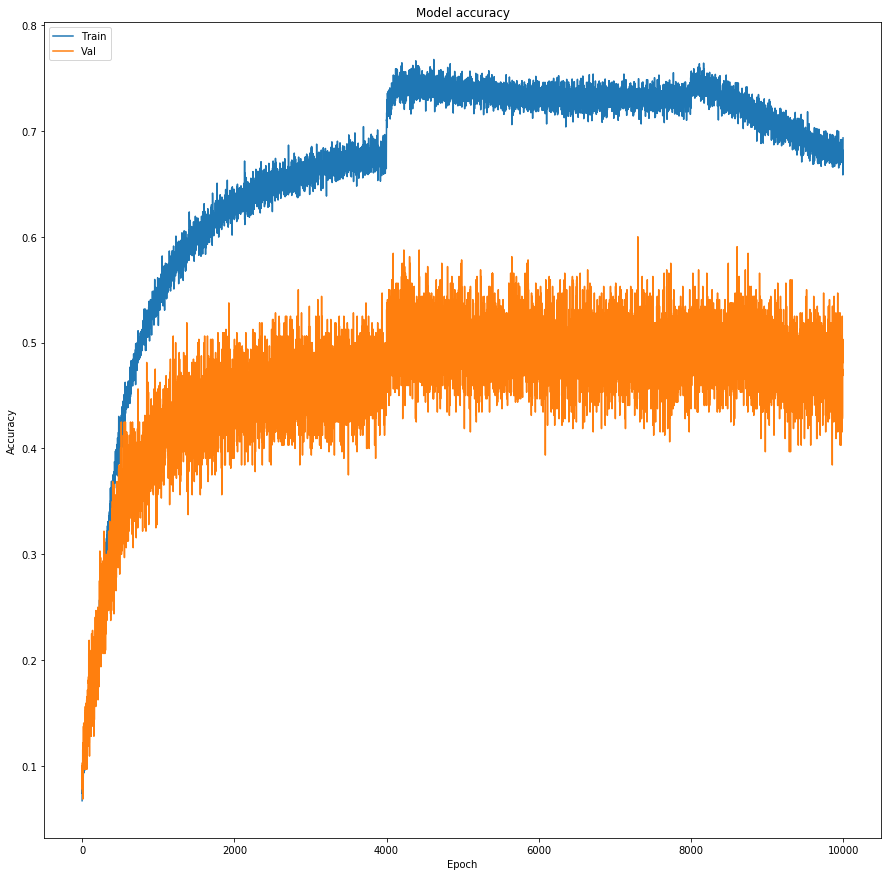

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize = (15,15))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

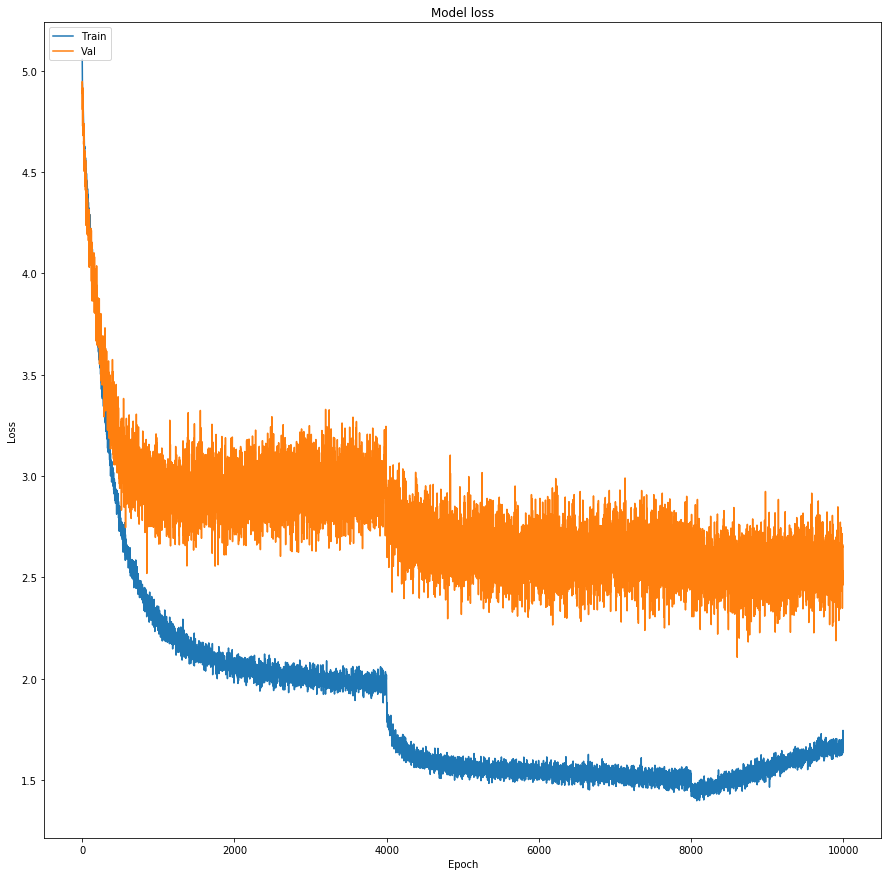

In [13]:
# Plot training & validation loss values
plt.figure(figsize = (15,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [14]:
scores = model.evaluate_generator(generator=testing_batches,verbose=1,steps=testing_batches2.samples//batch_size)
print(scores)


16904/16904 [==============================] - 1395s 83ms/step
[2.442882448604081, 0.4939492871509702, 0.7718642776857548]


In [15]:
#SGD Optimizer Parameters
base_lr = 0.001
momentum = 0.9

epochs = 1000#120 # 450000
gamma = 0.1
stepsize = 400#40 # 100000

filepath2 = 'saved_models/caffenet_single_flow_final_after_training.hdf5'
checkpointer2 = ModelCheckpoint(filepath=filepath2,verbose=1,save_best_only=True)
# early_stopper = EarlyStopping(patience=30)
# tensorboard = TensorBoard(log_dir='logs')
loss_history2 = LossHistory()
lrate2 = LearningRateScheduler(step_decay,verbose=1)


model2 = freeze_all_but_mid_and_top(model)
history2, model2 = train_model(model, epochs, training_batches, validation_batches,
                             [loss_history2,lrate2, checkpointer2])

Epoch 1/1000

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 39s 393ms/step - loss: 2.4446 - acc: 0.4862 - top_k_categorical_accuracy: 0.7841 - val_loss: 3.1491 - val_acc: 0.3281 - val_top_k_categorical_accuracy: 0.6312

Epoch 00001: val_loss improved from inf to 3.14911, saving model to saved_models/caffenet_single_flow_final_after_training.hdf5
Epoch 2/1000

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 349ms/step - loss: 2.2925 - acc: 0.5169 - top_k_categorical_accuracy: 0.8119 - val_loss: 2.9164 - val_acc: 0.3844 - val_top_k_categorical_accuracy: 0.6687

Epoch 00002: val_loss improved from 3.14911 to 2.91641, saving model to saved_models/caffenet_single_flow_final_after_training.hdf5
Epoch 3/1000

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 344ms/step - loss: 2.3049 - acc: 0.5156 - to


Epoch 00023: val_loss did not improve from 2.59367
Epoch 24/1000

Epoch 00024: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 341ms/step - loss: 2.0958 - acc: 0.5831 - top_k_categorical_accuracy: 0.8422 - val_loss: 2.8162 - val_acc: 0.4250 - val_top_k_categorical_accuracy: 0.7312

Epoch 00024: val_loss did not improve from 2.59367
Epoch 25/1000

Epoch 00025: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 343ms/step - loss: 2.0409 - acc: 0.6031 - top_k_categorical_accuracy: 0.8534 - val_loss: 2.9564 - val_acc: 0.4156 - val_top_k_categorical_accuracy: 0.7094

Epoch 00025: val_loss did not improve from 2.59367
Epoch 26/1000

Epoch 00026: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 342ms/step - loss: 2.0506 - acc: 0.5909 - top_k_categorical_accuracy: 0.8569 - val_loss: 2.9799 - val_acc: 0.4031 - val_top_k_categorical_accuracy:

100/100 [==============================] - 34s 343ms/step - loss: 2.0432 - acc: 0.6116 - top_k_categorical_accuracy: 0.8694 - val_loss: 2.7887 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7406

Epoch 00048: val_loss did not improve from 2.59367
Epoch 49/1000

Epoch 00049: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 343ms/step - loss: 2.0665 - acc: 0.6081 - top_k_categorical_accuracy: 0.8597 - val_loss: 2.9788 - val_acc: 0.3969 - val_top_k_categorical_accuracy: 0.6719

Epoch 00049: val_loss did not improve from 2.59367
Epoch 50/1000

Epoch 00050: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 343ms/step - loss: 2.0146 - acc: 0.6134 - top_k_categorical_accuracy: 0.8600 - val_loss: 2.6606 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7406

Epoch 00050: val_loss did not improve from 2.59367
Epoch 51/1000

Epoch 00051: LearningRateScheduler setting learning rate to


Epoch 00072: val_loss did not improve from 2.59367
Epoch 73/1000

Epoch 00073: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 339ms/step - loss: 1.9949 - acc: 0.6303 - top_k_categorical_accuracy: 0.8691 - val_loss: 2.9235 - val_acc: 0.4062 - val_top_k_categorical_accuracy: 0.7312

Epoch 00073: val_loss did not improve from 2.59367
Epoch 74/1000

Epoch 00074: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 340ms/step - loss: 2.0095 - acc: 0.6266 - top_k_categorical_accuracy: 0.8741 - val_loss: 3.0887 - val_acc: 0.3969 - val_top_k_categorical_accuracy: 0.6969

Epoch 00074: val_loss did not improve from 2.59367
Epoch 75/1000

Epoch 00075: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 338ms/step - loss: 2.0240 - acc: 0.6300 - top_k_categorical_accuracy: 0.8731 - val_loss: 2.7838 - val_acc: 0.4313 - val_top_k_categorical_accuracy:

100/100 [==============================] - 34s 339ms/step - loss: 2.0174 - acc: 0.6206 - top_k_categorical_accuracy: 0.8631 - val_loss: 3.3150 - val_acc: 0.3750 - val_top_k_categorical_accuracy: 0.6469

Epoch 00097: val_loss did not improve from 2.59367
Epoch 98/1000

Epoch 00098: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 339ms/step - loss: 2.0259 - acc: 0.6203 - top_k_categorical_accuracy: 0.8678 - val_loss: 2.7556 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7250

Epoch 00098: val_loss did not improve from 2.59367
Epoch 99/1000

Epoch 00099: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 338ms/step - loss: 2.0059 - acc: 0.6341 - top_k_categorical_accuracy: 0.8688 - val_loss: 2.9254 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.7500

Epoch 00099: val_loss did not improve from 2.59367
Epoch 100/1000

Epoch 00100: LearningRateScheduler setting learning rate t

100/100 [==============================] - 34s 341ms/step - loss: 2.0294 - acc: 0.6359 - top_k_categorical_accuracy: 0.8725 - val_loss: 2.9227 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.7438

Epoch 00145: val_loss did not improve from 2.59367
Epoch 146/1000

Epoch 00146: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 341ms/step - loss: 2.0123 - acc: 0.6341 - top_k_categorical_accuracy: 0.8784 - val_loss: 2.7858 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7438

Epoch 00146: val_loss did not improve from 2.59367
Epoch 147/1000

Epoch 00147: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 340ms/step - loss: 2.0003 - acc: 0.6297 - top_k_categorical_accuracy: 0.8787 - val_loss: 2.9565 - val_acc: 0.4219 - val_top_k_categorical_accuracy: 0.7188

Epoch 00147: val_loss did not improve from 2.59367
Epoch 148/1000

Epoch 00148: LearningRateScheduler setting learning rate

100/100 [==============================] - 34s 340ms/step - loss: 1.9637 - acc: 0.6525 - top_k_categorical_accuracy: 0.8884 - val_loss: 2.9202 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7281

Epoch 00193: val_loss did not improve from 2.59367
Epoch 194/1000

Epoch 00194: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 341ms/step - loss: 2.0865 - acc: 0.6200 - top_k_categorical_accuracy: 0.8700 - val_loss: 3.0873 - val_acc: 0.3937 - val_top_k_categorical_accuracy: 0.7000

Epoch 00194: val_loss did not improve from 2.59367
Epoch 195/1000

Epoch 00195: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 339ms/step - loss: 2.0776 - acc: 0.6319 - top_k_categorical_accuracy: 0.8681 - val_loss: 2.9084 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.7344

Epoch 00195: val_loss did not improve from 2.59367
Epoch 196/1000

Epoch 00196: LearningRateScheduler setting learning rate

100/100 [==============================] - 34s 341ms/step - loss: 1.9996 - acc: 0.6488 - top_k_categorical_accuracy: 0.8800 - val_loss: 2.9372 - val_acc: 0.4375 - val_top_k_categorical_accuracy: 0.7125

Epoch 00241: val_loss did not improve from 2.59367
Epoch 242/1000

Epoch 00242: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 342ms/step - loss: 2.0464 - acc: 0.6406 - top_k_categorical_accuracy: 0.8791 - val_loss: 3.0614 - val_acc: 0.3969 - val_top_k_categorical_accuracy: 0.7406

Epoch 00242: val_loss did not improve from 2.59367
Epoch 243/1000

Epoch 00243: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 342ms/step - loss: 2.0456 - acc: 0.6409 - top_k_categorical_accuracy: 0.8703 - val_loss: 2.8957 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7500

Epoch 00243: val_loss did not improve from 2.59367
Epoch 244/1000

Epoch 00244: LearningRateScheduler setting learning rate

100/100 [==============================] - 34s 342ms/step - loss: 2.0147 - acc: 0.6494 - top_k_categorical_accuracy: 0.8872 - val_loss: 2.9903 - val_acc: 0.4281 - val_top_k_categorical_accuracy: 0.7438

Epoch 00289: val_loss did not improve from 2.59367
Epoch 290/1000

Epoch 00290: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 341ms/step - loss: 2.0364 - acc: 0.6403 - top_k_categorical_accuracy: 0.8772 - val_loss: 3.0250 - val_acc: 0.4375 - val_top_k_categorical_accuracy: 0.7156

Epoch 00290: val_loss did not improve from 2.59367
Epoch 291/1000

Epoch 00291: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 343ms/step - loss: 1.9935 - acc: 0.6522 - top_k_categorical_accuracy: 0.8859 - val_loss: 2.7977 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7750

Epoch 00291: val_loss did not improve from 2.59367
Epoch 292/1000

Epoch 00292: LearningRateScheduler setting learning rate

100/100 [==============================] - 34s 342ms/step - loss: 2.0344 - acc: 0.6522 - top_k_categorical_accuracy: 0.8794 - val_loss: 2.9340 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7125

Epoch 00337: val_loss did not improve from 2.59367
Epoch 338/1000

Epoch 00338: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 342ms/step - loss: 2.0144 - acc: 0.6509 - top_k_categorical_accuracy: 0.8769 - val_loss: 3.1083 - val_acc: 0.4094 - val_top_k_categorical_accuracy: 0.7094

Epoch 00338: val_loss did not improve from 2.59367
Epoch 339/1000

Epoch 00339: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 342ms/step - loss: 1.9719 - acc: 0.6619 - top_k_categorical_accuracy: 0.8884 - val_loss: 3.0858 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.6969

Epoch 00339: val_loss did not improve from 2.59367
Epoch 340/1000

Epoch 00340: LearningRateScheduler setting learning rate

100/100 [==============================] - 34s 336ms/step - loss: 2.0329 - acc: 0.6547 - top_k_categorical_accuracy: 0.8872 - val_loss: 2.8319 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7406

Epoch 00385: val_loss did not improve from 2.59367
Epoch 386/1000

Epoch 00386: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 336ms/step - loss: 1.9925 - acc: 0.6584 - top_k_categorical_accuracy: 0.8866 - val_loss: 3.0104 - val_acc: 0.4313 - val_top_k_categorical_accuracy: 0.7219

Epoch 00386: val_loss did not improve from 2.59367
Epoch 387/1000

Epoch 00387: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 1.9956 - acc: 0.6672 - top_k_categorical_accuracy: 0.8841 - val_loss: 2.5970 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.8031

Epoch 00387: val_loss did not improve from 2.59367
Epoch 388/1000

Epoch 00388: LearningRateScheduler setting learning rate

100/100 [==============================] - 34s 336ms/step - loss: 1.7751 - acc: 0.7159 - top_k_categorical_accuracy: 0.9163 - val_loss: 2.8749 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7188

Epoch 00433: val_loss did not improve from 2.59367
Epoch 434/1000

Epoch 00434: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.7346 - acc: 0.7247 - top_k_categorical_accuracy: 0.9200 - val_loss: 2.6481 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.8031

Epoch 00434: val_loss did not improve from 2.59367
Epoch 435/1000

Epoch 00435: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.7743 - acc: 0.7188 - top_k_categorical_accuracy: 0.9116 - val_loss: 2.9796 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7406

Epoch 00435: val_loss did not improve from 2.59367
Epoch 436/1000

Epoch 00436: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 339ms/step - loss: 1.7400 - acc: 0.7216 - top_k_categorical_accuracy: 0.9147 - val_loss: 2.9210 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7656

Epoch 00457: val_loss did not improve from 2.56689
Epoch 458/1000

Epoch 00458: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.7515 - acc: 0.7219 - top_k_categorical_accuracy: 0.9172 - val_loss: 2.6461 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.8000

Epoch 00458: val_loss did not improve from 2.56689
Epoch 459/1000

Epoch 00459: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.7272 - acc: 0.7269 - top_k_categorical_accuracy: 0.9216 - val_loss: 2.7117 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.7594

Epoch 00459: val_loss did not improve from 2.56689
Epoch 460/1000

Epoch 00460: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 338ms/step - loss: 1.6921 - acc: 0.7291 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.9031 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7375

Epoch 00505: val_loss did not improve from 2.44079
Epoch 506/1000

Epoch 00506: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.6909 - acc: 0.7172 - top_k_categorical_accuracy: 0.9219 - val_loss: 2.6804 - val_acc: 0.5312 - val_top_k_categorical_accuracy: 0.7719

Epoch 00506: val_loss did not improve from 2.44079
Epoch 507/1000

Epoch 00507: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.6791 - acc: 0.7319 - top_k_categorical_accuracy: 0.9241 - val_loss: 2.8133 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7406

Epoch 00507: val_loss did not improve from 2.44079
Epoch 508/1000

Epoch 00508: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 337ms/step - loss: 1.7060 - acc: 0.7278 - top_k_categorical_accuracy: 0.9109 - val_loss: 2.8705 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7688

Epoch 00553: val_loss did not improve from 2.44079
Epoch 554/1000

Epoch 00554: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 335ms/step - loss: 1.6481 - acc: 0.7353 - top_k_categorical_accuracy: 0.9309 - val_loss: 2.8305 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7312

Epoch 00554: val_loss did not improve from 2.44079
Epoch 555/1000

Epoch 00555: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.6470 - acc: 0.7434 - top_k_categorical_accuracy: 0.9256 - val_loss: 2.6170 - val_acc: 0.5219 - val_top_k_categorical_accuracy: 0.7562

Epoch 00555: val_loss did not improve from 2.44079
Epoch 556/1000

Epoch 00556: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 339ms/step - loss: 1.6365 - acc: 0.7491 - top_k_categorical_accuracy: 0.9241 - val_loss: 2.7605 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7625

Epoch 00601: val_loss did not improve from 2.44079
Epoch 602/1000

Epoch 00602: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.6612 - acc: 0.7284 - top_k_categorical_accuracy: 0.9281 - val_loss: 2.8816 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7562

Epoch 00602: val_loss did not improve from 2.44079
Epoch 603/1000

Epoch 00603: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.6780 - acc: 0.7325 - top_k_categorical_accuracy: 0.9166 - val_loss: 2.6886 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7469

Epoch 00603: val_loss did not improve from 2.44079
Epoch 604/1000

Epoch 00604: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 340ms/step - loss: 1.6413 - acc: 0.7306 - top_k_categorical_accuracy: 0.9281 - val_loss: 2.9837 - val_acc: 0.4281 - val_top_k_categorical_accuracy: 0.7031

Epoch 00649: val_loss did not improve from 2.44079
Epoch 650/1000

Epoch 00650: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.6417 - acc: 0.7269 - top_k_categorical_accuracy: 0.9281 - val_loss: 2.7054 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7594

Epoch 00650: val_loss did not improve from 2.44079
Epoch 651/1000

Epoch 00651: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.6555 - acc: 0.7378 - top_k_categorical_accuracy: 0.9241 - val_loss: 2.6093 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7688

Epoch 00651: val_loss did not improve from 2.44079
Epoch 652/1000

Epoch 00652: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 336ms/step - loss: 1.5810 - acc: 0.7509 - top_k_categorical_accuracy: 0.9338 - val_loss: 2.8032 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7406

Epoch 00697: val_loss did not improve from 2.44079
Epoch 698/1000

Epoch 00698: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.6232 - acc: 0.7366 - top_k_categorical_accuracy: 0.9253 - val_loss: 2.6233 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7812

Epoch 00698: val_loss did not improve from 2.44079
Epoch 699/1000

Epoch 00699: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 336ms/step - loss: 1.6300 - acc: 0.7238 - top_k_categorical_accuracy: 0.9247 - val_loss: 2.8203 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7469

Epoch 00699: val_loss did not improve from 2.44079
Epoch 700/1000

Epoch 00700: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 337ms/step - loss: 1.6221 - acc: 0.7319 - top_k_categorical_accuracy: 0.9269 - val_loss: 2.6070 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7812

Epoch 00745: val_loss did not improve from 2.44079
Epoch 746/1000

Epoch 00746: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5567 - acc: 0.7500 - top_k_categorical_accuracy: 0.9269 - val_loss: 2.6656 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7656

Epoch 00746: val_loss did not improve from 2.44079
Epoch 747/1000

Epoch 00747: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.6036 - acc: 0.7313 - top_k_categorical_accuracy: 0.9313 - val_loss: 2.7076 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7562

Epoch 00747: val_loss did not improve from 2.44079
Epoch 748/1000

Epoch 00748: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 338ms/step - loss: 1.5957 - acc: 0.7362 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.6819 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.7562

Epoch 00793: val_loss did not improve from 2.44079
Epoch 794/1000

Epoch 00794: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.6165 - acc: 0.7387 - top_k_categorical_accuracy: 0.9169 - val_loss: 2.8083 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7469

Epoch 00794: val_loss did not improve from 2.44079
Epoch 795/1000

Epoch 00795: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.5713 - acc: 0.7466 - top_k_categorical_accuracy: 0.9309 - val_loss: 2.6436 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7688

Epoch 00795: val_loss did not improve from 2.44079
Epoch 796/1000

Epoch 00796: LearningRateScheduler setting learning ra


Epoch 00816: val_loss did not improve from 2.44079
Epoch 817/1000

Epoch 00817: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5266 - acc: 0.7506 - top_k_categorical_accuracy: 0.9325 - val_loss: 2.6515 - val_acc: 0.5406 - val_top_k_categorical_accuracy: 0.7625

Epoch 00817: val_loss did not improve from 2.44079
Epoch 818/1000

Epoch 00818: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5882 - acc: 0.7481 - top_k_categorical_accuracy: 0.9209 - val_loss: 2.6767 - val_acc: 0.5219 - val_top_k_categorical_accuracy: 0.7594

Epoch 00818: val_loss did not improve from 2.44079
Epoch 819/1000

Epoch 00819: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 339ms/step - loss: 1.6028 - acc: 0.7394 - top_k_categorical_accuracy: 0.9272 - val_loss: 2.73

100/100 [==============================] - 34s 337ms/step - loss: 1.5857 - acc: 0.7362 - top_k_categorical_accuracy: 0.9284 - val_loss: 2.5926 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7781

Epoch 00862: val_loss did not improve from 2.37660
Epoch 863/1000

Epoch 00863: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5675 - acc: 0.7387 - top_k_categorical_accuracy: 0.9319 - val_loss: 2.7318 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7406

Epoch 00863: val_loss did not improve from 2.37660
Epoch 864/1000

Epoch 00864: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.5798 - acc: 0.7422 - top_k_categorical_accuracy: 0.9234 - val_loss: 2.8649 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.7219

Epoch 00864: val_loss did not improve from 2.37660
Epoch 865/1000

Epoch 00865: LearningR

100/100 [==============================] - 34s 337ms/step - loss: 1.5865 - acc: 0.7384 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.7231 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7844

Epoch 00908: val_loss did not improve from 2.37660
Epoch 909/1000

Epoch 00909: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.5456 - acc: 0.7416 - top_k_categorical_accuracy: 0.9347 - val_loss: 2.6520 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7750

Epoch 00909: val_loss did not improve from 2.37660
Epoch 910/1000

Epoch 00910: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5635 - acc: 0.7375 - top_k_categorical_accuracy: 0.9306 - val_loss: 2.7492 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7562

Epoch 00910: val_loss did not improve from 2.37660
Epoch 911/1000

Epoch 00911: LearningR

100/100 [==============================] - 34s 337ms/step - loss: 1.5638 - acc: 0.7444 - top_k_categorical_accuracy: 0.9316 - val_loss: 2.5294 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.8063

Epoch 00954: val_loss did not improve from 2.34895
Epoch 955/1000

Epoch 00955: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 336ms/step - loss: 1.5731 - acc: 0.7372 - top_k_categorical_accuracy: 0.9291 - val_loss: 2.8426 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7438

Epoch 00955: val_loss did not improve from 2.34895
Epoch 956/1000

Epoch 00956: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5121 - acc: 0.7509 - top_k_categorical_accuracy: 0.9363 - val_loss: 2.7157 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7656

Epoch 00956: val_loss did not improve from 2.34895
Epoch 957/1000

Epoch 00957: LearningR

100/100 [==============================] - 34s 337ms/step - loss: 1.5709 - acc: 0.7444 - top_k_categorical_accuracy: 0.9247 - val_loss: 2.7515 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7344

Epoch 01000: val_loss did not improve from 2.34895


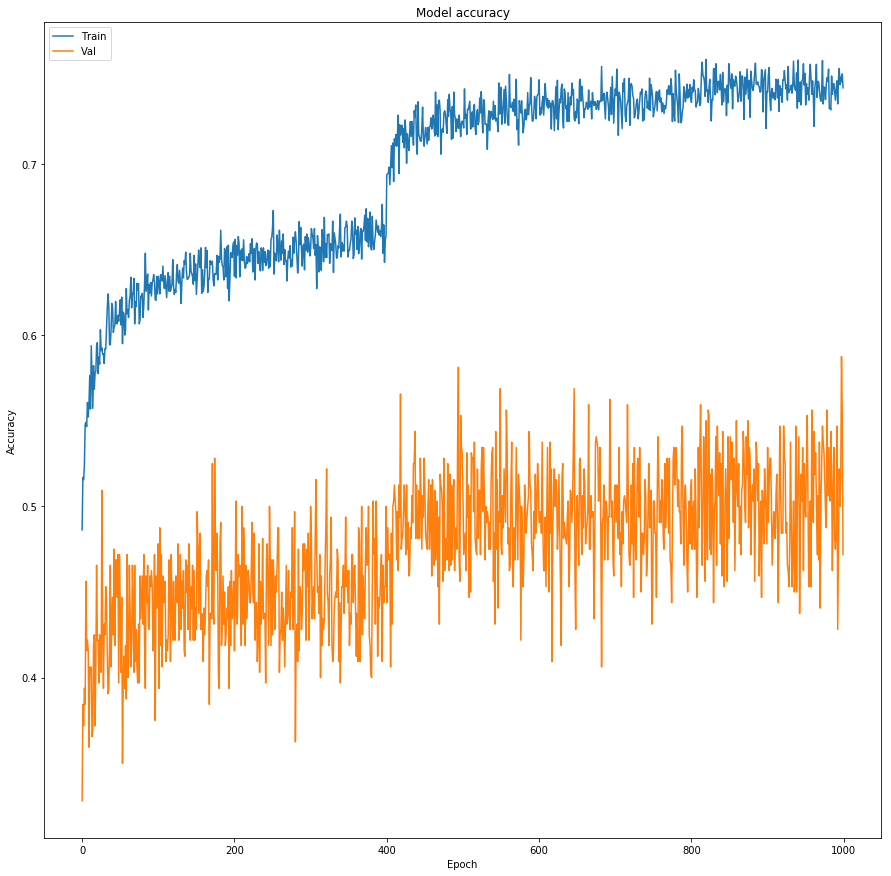

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize = (15,15))
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

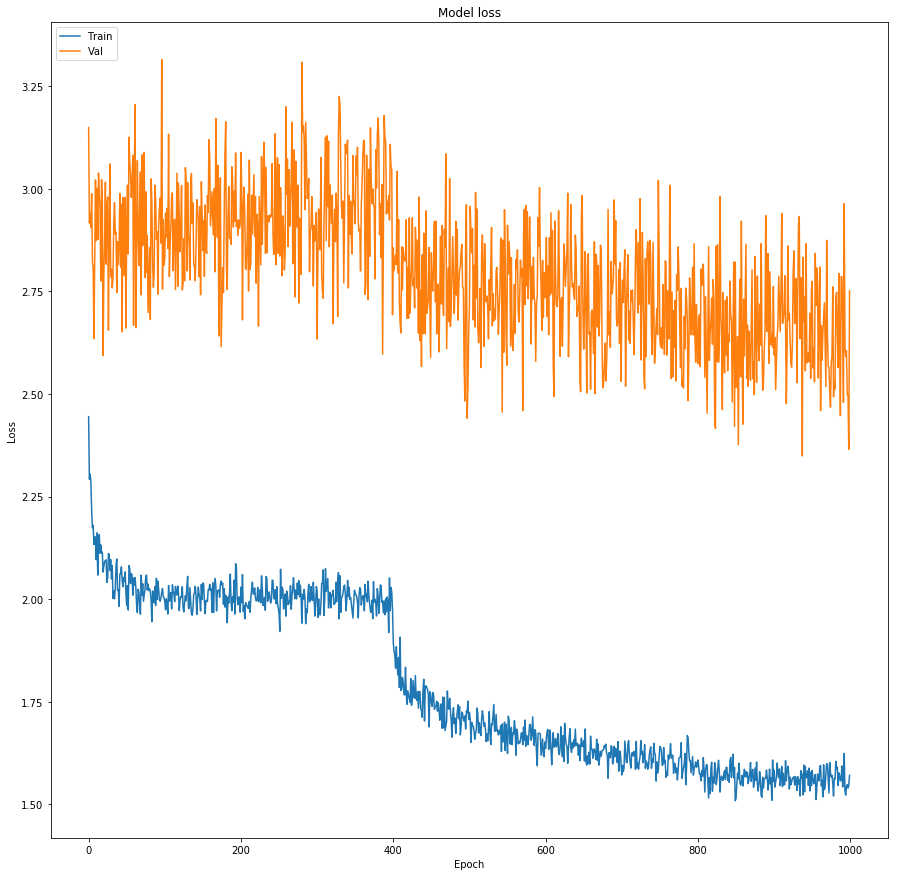

In [17]:
# Plot training & validation loss values
plt.figure(figsize = (15,15))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [18]:
scores2 = model2.evaluate_generator(generator=testing_batches,verbose=1,steps=testing_batches2.samples//batch_size)
print(scores2)


16904/16904 [==============================] - 1396s 83ms/step
[2.5865315837546032, 0.5132617388621349, 0.7820700772953293]


In [19]:
model2.save_weights('saved_models/single_flow_final_oristika.h5')

In [20]:
#SGD Optimizer Parameters
base_lr = 0.001
momentum = 0.9

epochs = 1000#120 # 450000
gamma = 0.1
stepsize = 400#40 # 100000

filepath3 = 'saved_models/caffenet_single_flow_final_after_training_after_training.hdf5'
checkpointer3 = ModelCheckpoint(filepath=filepath2,verbose=1,save_best_only=True)
# early_stopper = EarlyStopping(patience=30)
# tensorboard = TensorBoard(log_dir='logs')
loss_history3 = LossHistory()
lrate3 = LearningRateScheduler(step_decay,verbose=1)


model3 = freeze_all_but_mid_and_top(model2)
history3, model3 = train_model(model2, epochs, training_batches, validation_batches,
                             [loss_history3,lrate3, checkpointer3])

Epoch 1/1000

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 39s 387ms/step - loss: 1.8375 - acc: 0.6819 - top_k_categorical_accuracy: 0.8869 - val_loss: 2.7409 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 2.74095, saving model to saved_models/caffenet_single_flow_final_after_training.hdf5
Epoch 2/1000

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 344ms/step - loss: 1.8873 - acc: 0.6562 - top_k_categorical_accuracy: 0.8863 - val_loss: 3.0382 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.6875

Epoch 00002: val_loss did not improve from 2.74095
Epoch 3/1000

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 348ms/step - loss: 1.8697 - acc: 0.6634 - top_k_categorical_accuracy: 0.8866 - val_loss: 3.0365 - val_acc: 0.4094 - val_top_k

100/100 [==============================] - 35s 348ms/step - loss: 1.9778 - acc: 0.6594 - top_k_categorical_accuracy: 0.8825 - val_loss: 2.8433 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7219

Epoch 00025: val_loss did not improve from 2.74095
Epoch 26/1000

Epoch 00026: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 349ms/step - loss: 1.9609 - acc: 0.6594 - top_k_categorical_accuracy: 0.8847 - val_loss: 3.0180 - val_acc: 0.4094 - val_top_k_categorical_accuracy: 0.7594

Epoch 00026: val_loss did not improve from 2.74095
Epoch 27/1000

Epoch 00027: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 348ms/step - loss: 1.9450 - acc: 0.6613 - top_k_categorical_accuracy: 0.8838 - val_loss: 2.8498 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7438

Epoch 00027: val_loss did not improve from 2.74095
Epoch 28/1000

Epoch 00028: LearningRateScheduler setting learning rate to


Epoch 00049: val_loss did not improve from 2.74095
Epoch 50/1000

Epoch 00050: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 343ms/step - loss: 1.9490 - acc: 0.6587 - top_k_categorical_accuracy: 0.8959 - val_loss: 2.8069 - val_acc: 0.4688 - val_top_k_categorical_accuracy: 0.7531

Epoch 00050: val_loss did not improve from 2.74095
Epoch 51/1000

Epoch 00051: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 340ms/step - loss: 1.9370 - acc: 0.6597 - top_k_categorical_accuracy: 0.8953 - val_loss: 3.0945 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.7188

Epoch 00051: val_loss did not improve from 2.74095
Epoch 52/1000

Epoch 00052: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 341ms/step - loss: 2.0137 - acc: 0.6431 - top_k_categorical_accuracy: 0.8841 - val_loss: 2.9442 - val_acc: 0.4313 - val_top_k_categorical_accuracy:

100/100 [==============================] - 34s 341ms/step - loss: 2.0177 - acc: 0.6453 - top_k_categorical_accuracy: 0.8878 - val_loss: 3.0104 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7000

Epoch 00074: val_loss did not improve from 2.74095
Epoch 75/1000

Epoch 00075: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 341ms/step - loss: 2.0069 - acc: 0.6522 - top_k_categorical_accuracy: 0.8834 - val_loss: 2.7831 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7375

Epoch 00075: val_loss did not improve from 2.74095
Epoch 76/1000

Epoch 00076: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 342ms/step - loss: 1.9399 - acc: 0.6719 - top_k_categorical_accuracy: 0.8941 - val_loss: 2.9900 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7156

Epoch 00076: val_loss did not improve from 2.74095
Epoch 77/1000

Epoch 00077: LearningRateScheduler setting learning rate to


Epoch 00098: val_loss did not improve from 2.74095
Epoch 99/1000

Epoch 00099: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 341ms/step - loss: 1.9892 - acc: 0.6591 - top_k_categorical_accuracy: 0.8841 - val_loss: 3.0398 - val_acc: 0.4375 - val_top_k_categorical_accuracy: 0.7094

Epoch 00099: val_loss did not improve from 2.74095
Epoch 100/1000

Epoch 00100: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 339ms/step - loss: 2.0132 - acc: 0.6525 - top_k_categorical_accuracy: 0.8863 - val_loss: 3.0309 - val_acc: 0.4156 - val_top_k_categorical_accuracy: 0.7219

Epoch 00100: val_loss did not improve from 2.74095
Epoch 101/1000

Epoch 00101: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 337ms/step - loss: 1.9852 - acc: 0.6541 - top_k_categorical_accuracy: 0.8894 - val_loss: 2.9584 - val_acc: 0.4437 - val_top_k_categorical_accurac

100/100 [==============================] - 34s 338ms/step - loss: 2.0050 - acc: 0.6600 - top_k_categorical_accuracy: 0.8828 - val_loss: 2.6965 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.7750

Epoch 00123: val_loss did not improve from 2.63153
Epoch 124/1000

Epoch 00124: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 338ms/step - loss: 1.9952 - acc: 0.6644 - top_k_categorical_accuracy: 0.8872 - val_loss: 2.9726 - val_acc: 0.4719 - val_top_k_categorical_accuracy: 0.7063

Epoch 00124: val_loss did not improve from 2.63153
Epoch 125/1000

Epoch 00125: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 34s 340ms/step - loss: 1.9635 - acc: 0.6681 - top_k_categorical_accuracy: 0.8872 - val_loss: 2.9255 - val_acc: 0.4281 - val_top_k_categorical_accuracy: 0.7688

Epoch 00125: val_loss did not improve from 2.63153
Epoch 126/1000

Epoch 00126: LearningRateScheduler setting learning rate

100/100 [==============================] - 60s 597ms/step - loss: 1.9871 - acc: 0.6591 - top_k_categorical_accuracy: 0.8950 - val_loss: 2.9713 - val_acc: 0.4281 - val_top_k_categorical_accuracy: 0.7656

Epoch 00171: val_loss did not improve from 2.63153
Epoch 172/1000

Epoch 00172: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 60s 597ms/step - loss: 1.9852 - acc: 0.6525 - top_k_categorical_accuracy: 0.8934 - val_loss: 2.9220 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7375

Epoch 00172: val_loss did not improve from 2.63153
Epoch 173/1000

Epoch 00173: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 60s 598ms/step - loss: 1.9758 - acc: 0.6709 - top_k_categorical_accuracy: 0.8856 - val_loss: 3.0871 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.7094

Epoch 00173: val_loss did not improve from 2.63153
Epoch 174/1000

Epoch 00174: LearningRateScheduler setting learning rate

100/100 [==============================] - 60s 600ms/step - loss: 2.0613 - acc: 0.6534 - top_k_categorical_accuracy: 0.8747 - val_loss: 2.7940 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7656

Epoch 00219: val_loss did not improve from 2.63153
Epoch 220/1000

Epoch 00220: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 58s 582ms/step - loss: 2.0261 - acc: 0.6566 - top_k_categorical_accuracy: 0.8878 - val_loss: 2.8590 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7562

Epoch 00220: val_loss did not improve from 2.63153
Epoch 221/1000

Epoch 00221: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 59s 587ms/step - loss: 1.9572 - acc: 0.6697 - top_k_categorical_accuracy: 0.8972 - val_loss: 3.0601 - val_acc: 0.4219 - val_top_k_categorical_accuracy: 0.7156

Epoch 00221: val_loss did not improve from 2.63153
Epoch 222/1000

Epoch 00222: LearningRateScheduler setting learning rate

100/100 [==============================] - 59s 586ms/step - loss: 1.9865 - acc: 0.6597 - top_k_categorical_accuracy: 0.8906 - val_loss: 2.8918 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7625

Epoch 00267: val_loss did not improve from 2.63153
Epoch 268/1000

Epoch 00268: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 58s 584ms/step - loss: 1.9796 - acc: 0.6766 - top_k_categorical_accuracy: 0.8950 - val_loss: 2.8553 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7469

Epoch 00268: val_loss did not improve from 2.63153
Epoch 269/1000

Epoch 00269: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 59s 585ms/step - loss: 1.9752 - acc: 0.6737 - top_k_categorical_accuracy: 0.8897 - val_loss: 3.2027 - val_acc: 0.4188 - val_top_k_categorical_accuracy: 0.7125

Epoch 00269: val_loss did not improve from 2.63153
Epoch 270/1000

Epoch 00270: LearningRateScheduler setting learning rate

100/100 [==============================] - 58s 581ms/step - loss: 1.9657 - acc: 0.6781 - top_k_categorical_accuracy: 0.9006 - val_loss: 2.9768 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7500

Epoch 00315: val_loss did not improve from 2.63153
Epoch 316/1000

Epoch 00316: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 59s 594ms/step - loss: 2.0042 - acc: 0.6606 - top_k_categorical_accuracy: 0.8903 - val_loss: 2.8364 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7781

Epoch 00316: val_loss did not improve from 2.63153
Epoch 317/1000

Epoch 00317: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 59s 585ms/step - loss: 2.0043 - acc: 0.6734 - top_k_categorical_accuracy: 0.8900 - val_loss: 3.1492 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.7000

Epoch 00317: val_loss did not improve from 2.63153
Epoch 318/1000

Epoch 00318: LearningRateScheduler setting learning rate

100/100 [==============================] - 59s 590ms/step - loss: 2.0236 - acc: 0.6569 - top_k_categorical_accuracy: 0.8847 - val_loss: 2.9998 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7188

Epoch 00363: val_loss did not improve from 2.63153
Epoch 364/1000

Epoch 00364: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 59s 587ms/step - loss: 1.9734 - acc: 0.6813 - top_k_categorical_accuracy: 0.9009 - val_loss: 2.8958 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.7312

Epoch 00364: val_loss did not improve from 2.63153
Epoch 365/1000

Epoch 00365: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 59s 586ms/step - loss: 1.9917 - acc: 0.6672 - top_k_categorical_accuracy: 0.8922 - val_loss: 2.9026 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.7438

Epoch 00365: val_loss did not improve from 2.63153
Epoch 366/1000

Epoch 00366: LearningRateScheduler setting learning rate

100/100 [==============================] - 34s 342ms/step - loss: 1.8295 - acc: 0.7091 - top_k_categorical_accuracy: 0.9141 - val_loss: 2.6473 - val_acc: 0.5344 - val_top_k_categorical_accuracy: 0.8000

Epoch 00411: val_loss did not improve from 2.57424
Epoch 412/1000

Epoch 00412: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 342ms/step - loss: 1.7731 - acc: 0.7313 - top_k_categorical_accuracy: 0.9203 - val_loss: 2.9601 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7250

Epoch 00412: val_loss did not improve from 2.57424
Epoch 413/1000

Epoch 00413: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 340ms/step - loss: 1.8390 - acc: 0.7159 - top_k_categorical_accuracy: 0.9056 - val_loss: 3.0146 - val_acc: 0.4531 - val_top_k_categorical_accuracy: 0.7312

Epoch 00413: val_loss did not improve from 2.57424
Epoch 414/1000

Epoch 00414: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 342ms/step - loss: 1.6768 - acc: 0.7456 - top_k_categorical_accuracy: 0.9316 - val_loss: 2.5236 - val_acc: 0.5906 - val_top_k_categorical_accuracy: 0.7969

Epoch 00459: val_loss improved from 2.57424 to 2.52364, saving model to saved_models/caffenet_single_flow_final_after_training.hdf5
Epoch 460/1000

Epoch 00460: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 342ms/step - loss: 1.7805 - acc: 0.7212 - top_k_categorical_accuracy: 0.9150 - val_loss: 2.6330 - val_acc: 0.5437 - val_top_k_categorical_accuracy: 0.7906

Epoch 00460: val_loss did not improve from 2.52364
Epoch 461/1000

Epoch 00461: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 342ms/step - loss: 1.7635 - acc: 0.7284 - top_k_categorical_accuracy: 0.9216 - val_loss: 3.0116 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7031

Epoch 00461: val_loss did not improve fr

100/100 [==============================] - 34s 341ms/step - loss: 1.7571 - acc: 0.7272 - top_k_categorical_accuracy: 0.9200 - val_loss: 3.0410 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7375

Epoch 00483: val_loss did not improve from 2.52364
Epoch 484/1000

Epoch 00484: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 343ms/step - loss: 1.7583 - acc: 0.7278 - top_k_categorical_accuracy: 0.9159 - val_loss: 2.9441 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7500

Epoch 00484: val_loss did not improve from 2.52364
Epoch 485/1000

Epoch 00485: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 342ms/step - loss: 1.7153 - acc: 0.7366 - top_k_categorical_accuracy: 0.9219 - val_loss: 2.9459 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7438

Epoch 00485: val_loss did not improve from 2.52364
Epoch 486/1000

Epoch 00486: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 342ms/step - loss: 1.7030 - acc: 0.7334 - top_k_categorical_accuracy: 0.9197 - val_loss: 2.6961 - val_acc: 0.5219 - val_top_k_categorical_accuracy: 0.7969

Epoch 00531: val_loss did not improve from 2.52364
Epoch 532/1000

Epoch 00532: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 342ms/step - loss: 1.7190 - acc: 0.7300 - top_k_categorical_accuracy: 0.9194 - val_loss: 2.6323 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.8031

Epoch 00532: val_loss did not improve from 2.52364
Epoch 533/1000

Epoch 00533: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 343ms/step - loss: 1.7103 - acc: 0.7278 - top_k_categorical_accuracy: 0.9237 - val_loss: 2.4944 - val_acc: 0.5594 - val_top_k_categorical_accuracy: 0.7937

Epoch 00533: val_loss improved from 2.52364 to 2.49445, saving model to saved_models/caffenet_single_flow_final_after_tra

100/100 [==============================] - 34s 340ms/step - loss: 1.6731 - acc: 0.7391 - top_k_categorical_accuracy: 0.9297 - val_loss: 2.8694 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7375

Epoch 00555: val_loss did not improve from 2.49445
Epoch 556/1000

Epoch 00556: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 341ms/step - loss: 1.6766 - acc: 0.7419 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.7000 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7906

Epoch 00556: val_loss did not improve from 2.49445
Epoch 557/1000

Epoch 00557: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 342ms/step - loss: 1.6885 - acc: 0.7366 - top_k_categorical_accuracy: 0.9244 - val_loss: 2.6867 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7906

Epoch 00557: val_loss did not improve from 2.49445
Epoch 558/1000

Epoch 00558: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 338ms/step - loss: 1.6451 - acc: 0.7469 - top_k_categorical_accuracy: 0.9278 - val_loss: 2.7921 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7719

Epoch 00603: val_loss did not improve from 2.49445
Epoch 604/1000

Epoch 00604: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.6614 - acc: 0.7453 - top_k_categorical_accuracy: 0.9275 - val_loss: 2.8677 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7406

Epoch 00604: val_loss did not improve from 2.49445
Epoch 605/1000

Epoch 00605: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 337ms/step - loss: 1.6777 - acc: 0.7444 - top_k_categorical_accuracy: 0.9269 - val_loss: 2.7161 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7562

Epoch 00605: val_loss did not improve from 2.49445
Epoch 606/1000

Epoch 00606: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 338ms/step - loss: 1.6374 - acc: 0.7491 - top_k_categorical_accuracy: 0.9275 - val_loss: 2.8295 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.7438

Epoch 00651: val_loss did not improve from 2.42115
Epoch 652/1000

Epoch 00652: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 338ms/step - loss: 1.6631 - acc: 0.7438 - top_k_categorical_accuracy: 0.9216 - val_loss: 3.0430 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.7375

Epoch 00652: val_loss did not improve from 2.42115
Epoch 653/1000

Epoch 00653: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 339ms/step - loss: 1.6819 - acc: 0.7328 - top_k_categorical_accuracy: 0.9216 - val_loss: 2.9122 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7281

Epoch 00653: val_loss did not improve from 2.42115
Epoch 654/1000

Epoch 00654: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 340ms/step - loss: 1.6377 - acc: 0.7384 - top_k_categorical_accuracy: 0.9250 - val_loss: 2.6520 - val_acc: 0.5000 - val_top_k_categorical_accuracy: 0.7594

Epoch 00699: val_loss did not improve from 2.42115
Epoch 700/1000

Epoch 00700: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 340ms/step - loss: 1.6155 - acc: 0.7506 - top_k_categorical_accuracy: 0.9306 - val_loss: 2.6342 - val_acc: 0.5125 - val_top_k_categorical_accuracy: 0.7688

Epoch 00700: val_loss did not improve from 2.42115
Epoch 701/1000

Epoch 00701: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 340ms/step - loss: 1.5971 - acc: 0.7531 - top_k_categorical_accuracy: 0.9353 - val_loss: 2.7142 - val_acc: 0.5156 - val_top_k_categorical_accuracy: 0.7500

Epoch 00701: val_loss did not improve from 2.42115
Epoch 702/1000

Epoch 00702: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 340ms/step - loss: 1.6049 - acc: 0.7541 - top_k_categorical_accuracy: 0.9319 - val_loss: 2.6414 - val_acc: 0.5312 - val_top_k_categorical_accuracy: 0.7750

Epoch 00747: val_loss did not improve from 2.42115
Epoch 748/1000

Epoch 00748: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 342ms/step - loss: 1.6379 - acc: 0.7359 - top_k_categorical_accuracy: 0.9225 - val_loss: 2.7654 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7656

Epoch 00748: val_loss did not improve from 2.42115
Epoch 749/1000

Epoch 00749: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 342ms/step - loss: 1.6254 - acc: 0.7369 - top_k_categorical_accuracy: 0.9262 - val_loss: 2.6589 - val_acc: 0.5094 - val_top_k_categorical_accuracy: 0.7781

Epoch 00749: val_loss did not improve from 2.42115
Epoch 750/1000

Epoch 00750: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 341ms/step - loss: 1.6137 - acc: 0.7472 - top_k_categorical_accuracy: 0.9294 - val_loss: 2.7699 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7781

Epoch 00795: val_loss did not improve from 2.42115
Epoch 796/1000

Epoch 00796: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 343ms/step - loss: 1.5975 - acc: 0.7500 - top_k_categorical_accuracy: 0.9306 - val_loss: 2.6259 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7688

Epoch 00796: val_loss did not improve from 2.42115
Epoch 797/1000

Epoch 00797: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 342ms/step - loss: 1.5796 - acc: 0.7469 - top_k_categorical_accuracy: 0.9331 - val_loss: 2.7282 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7656

Epoch 00797: val_loss did not improve from 2.42115
Epoch 798/1000

Epoch 00798: LearningRateScheduler setting learning ra

100/100 [==============================] - 34s 342ms/step - loss: 1.5658 - acc: 0.7559 - top_k_categorical_accuracy: 0.9356 - val_loss: 2.6496 - val_acc: 0.5062 - val_top_k_categorical_accuracy: 0.7781

Epoch 00841: val_loss did not improve from 2.38942
Epoch 842/1000

Epoch 00842: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 342ms/step - loss: 1.5574 - acc: 0.7537 - top_k_categorical_accuracy: 0.9378 - val_loss: 2.5668 - val_acc: 0.5375 - val_top_k_categorical_accuracy: 0.7781

Epoch 00842: val_loss did not improve from 2.38942
Epoch 843/1000

Epoch 00843: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 341ms/step - loss: 1.5644 - acc: 0.7641 - top_k_categorical_accuracy: 0.9303 - val_loss: 2.6783 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7438

Epoch 00843: val_loss did not improve from 2.38942
Epoch 844/1000

Epoch 00844: LearningR

100/100 [==============================] - 34s 338ms/step - loss: 1.5898 - acc: 0.7500 - top_k_categorical_accuracy: 0.9328 - val_loss: 2.6471 - val_acc: 0.5406 - val_top_k_categorical_accuracy: 0.7656

Epoch 00887: val_loss did not improve from 2.38942
Epoch 888/1000

Epoch 00888: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 337ms/step - loss: 1.5734 - acc: 0.7475 - top_k_categorical_accuracy: 0.9309 - val_loss: 2.6196 - val_acc: 0.5156 - val_top_k_categorical_accuracy: 0.7812

Epoch 00888: val_loss did not improve from 2.38942
Epoch 889/1000

Epoch 00889: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 339ms/step - loss: 1.5900 - acc: 0.7466 - top_k_categorical_accuracy: 0.9309 - val_loss: 2.5591 - val_acc: 0.5156 - val_top_k_categorical_accuracy: 0.7969

Epoch 00889: val_loss did not improve from 2.38942
Epoch 890/1000

Epoch 00890: LearningR

100/100 [==============================] - 34s 341ms/step - loss: 1.5708 - acc: 0.7525 - top_k_categorical_accuracy: 0.9284 - val_loss: 2.7578 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7656

Epoch 00933: val_loss did not improve from 2.38942
Epoch 934/1000

Epoch 00934: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 349ms/step - loss: 1.5859 - acc: 0.7447 - top_k_categorical_accuracy: 0.9303 - val_loss: 2.7029 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7500

Epoch 00934: val_loss did not improve from 2.38942
Epoch 935/1000

Epoch 00935: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 344ms/step - loss: 1.5584 - acc: 0.7575 - top_k_categorical_accuracy: 0.9331 - val_loss: 2.8200 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7469

Epoch 00935: val_loss did not improve from 2.38942
Epoch 936/1000

Epoch 00936: LearningR

100/100 [==============================] - 36s 364ms/step - loss: 1.5615 - acc: 0.7597 - top_k_categorical_accuracy: 0.9372 - val_loss: 2.6272 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7844

Epoch 00979: val_loss did not improve from 2.37725
Epoch 980/1000

Epoch 00980: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 345ms/step - loss: 1.5718 - acc: 0.7475 - top_k_categorical_accuracy: 0.9319 - val_loss: 2.7650 - val_acc: 0.5188 - val_top_k_categorical_accuracy: 0.7438

Epoch 00980: val_loss did not improve from 2.37725
Epoch 981/1000

Epoch 00981: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 344ms/step - loss: 1.5451 - acc: 0.7591 - top_k_categorical_accuracy: 0.9350 - val_loss: 2.5938 - val_acc: 0.5250 - val_top_k_categorical_accuracy: 0.7875

Epoch 00981: val_loss did not improve from 2.37725
Epoch 982/1000

Epoch 00982: LearningR

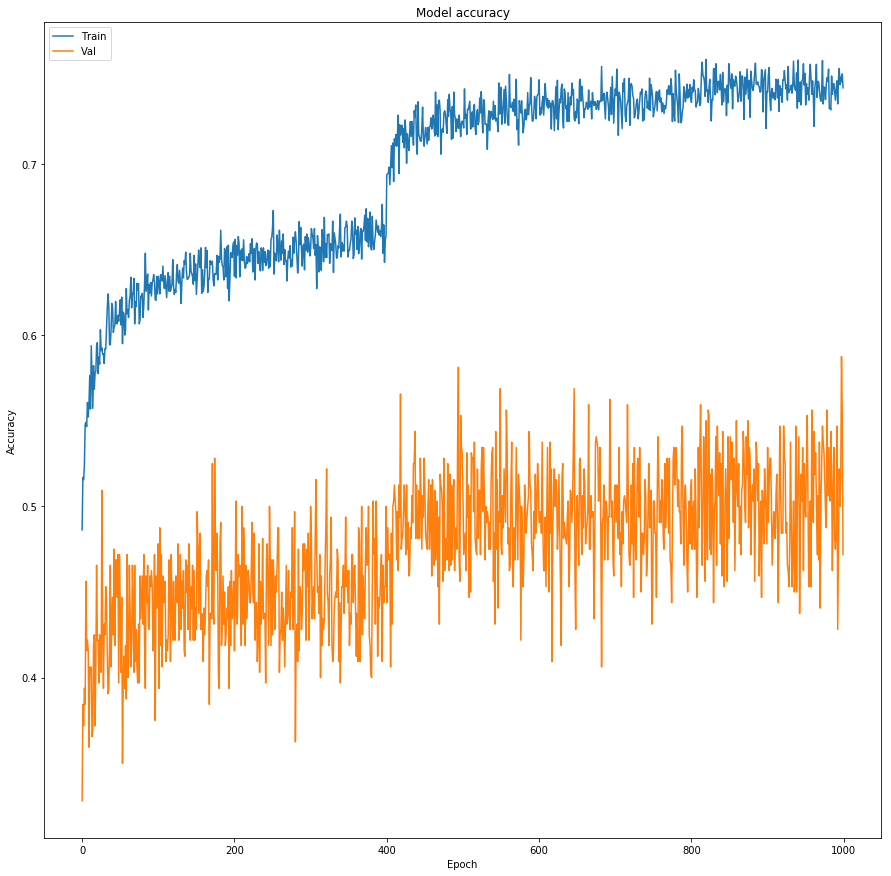

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize = (15,15))
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

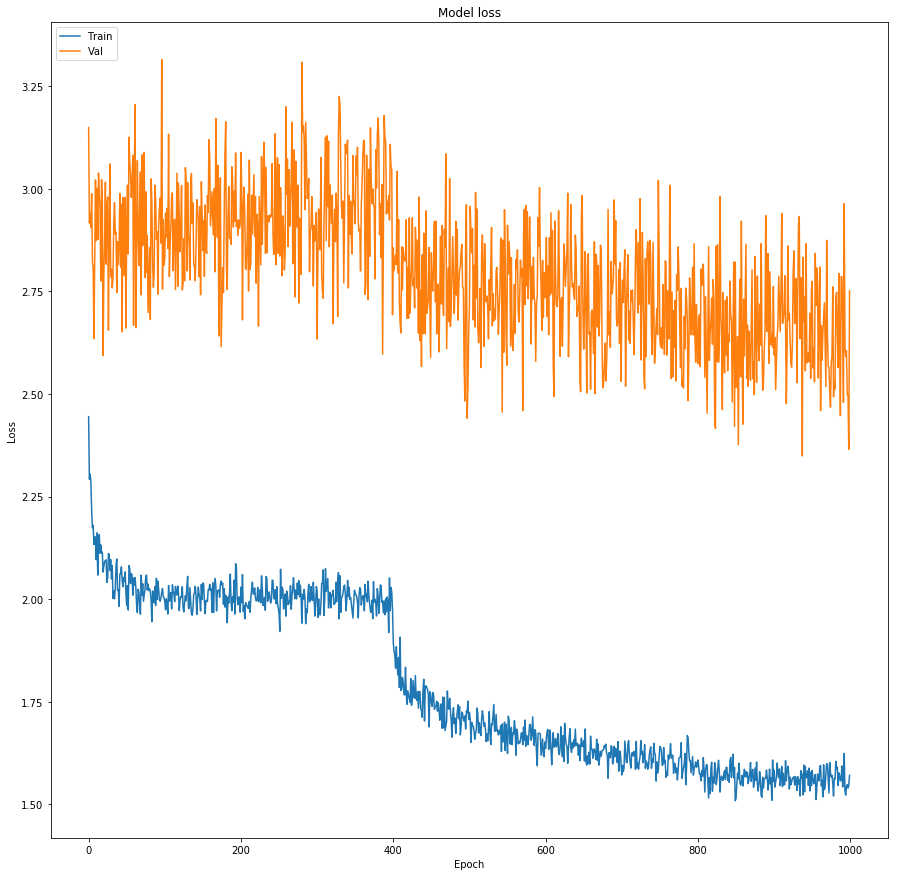

In [22]:
# Plot training & validation loss values
plt.figure(figsize = (15,15))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [23]:
scores3 = model3.evaluate_generator(generator=testing_batches,verbose=1,steps=testing_batches2.samples//batch_size)
print(scores3)

16904/16904 [==============================] - 1411s 83ms/step
[2.600390272792645, 0.5200613033053681, 0.7859671631698719]


In [24]:
model3.save_weights('saved_models/caffenet_single_flow_extra.h5')